In this notebook we determine the magnitude and color based selection of the spectroscopic calibration sample using the `fuji` dataset. We also estimate the $p(z)$ of the ELGs.

Author: Tanveer Karim
Last Updated: October 6 2022

**Note**: This notebook should be run with DESI master kernel. 

In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
#from astropy.convolution import convolve, Gaussian1DKernel

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-talk")

%matplotlib inline

## Import data

### DESI SV3 `fuji` data

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
## Note that we are importing the different target masks for different surveys by the same name.
## This is to allow you to run the same cells in the tutorial for different surveys bitmasks.
## Please make sure to uncomment the required survey and comment out the rest, 
## and rerun this cell, to make sure everything runs smoothly.
#from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask    # For the main survey
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV1
#from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV2
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV3a

In [3]:
# Release directory path

specprod = 'fuji'
survey_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'

Read in redshift catalogue

In [4]:
survey = 'sv3'
faprgrm = 'dark' 

zcat = Table.read(f'{survey_dir}/zcatalog/zpix-{survey}-{faprgrm}.fits', hdu="ZCATALOG")

We select targets that are ELGs, not QSOs, have reliable redshift (ZWARN == 0) and have a good SNR (DELTACHI2 >= 36)

In [5]:
# Targeting information about the DESI targetting is stored in the desi_target columns - 
desi_target = zcat['SV3_DESI_TARGET']

# Masks for different targets
elg_tgtmask = desi_mask['ELG']
#qso_tgtmask = desi_mask['QSO']

# Good redshifts
#is_zwarn = (zcat['ZWARN'] == 0) & (zcat['COADD_FIBERSTATUS'] == 0)
is_coadd = (zcat['COADD_FIBERSTATUS'] == 0)

# Proper spectype
#is_notstar = zcat['SPECTYPE'] != 'STAR' #1% OF ELGs are stars

# Good signal
#is_deltachi2 = zcat['DELTACHI2'] >= 36

# Selecting candidates - 
#is_elg = (desi_target & elg_tgtmask != 0) & is_coadd #& is_notstar & (desi_target & qso_tgtmask == 0) #dont include qso + elg samples

#select good elgs based on zwarn and deltachi2
#is_good_elg = is_elg & is_cod & is_deltachi2

#select relevant rows
#zcat_elg = zcat[is_elg]

# Number of sources
#n_elg = len(zcat_elg)

#print(f'Number of ELGs: {n_elg}')

### Convert magnitudes and calculate colours for histogram analysis
We will use the 2D histogram on the $g-r$ vs $r-z$ space to decide whether certain cuts cluster in a particular fashion. 

#### Milky Way Transmission for the ELGs
We need to correct the magnitudes for Milky Way dust extinction

In [6]:
from desiutil.dust import mwdust_transmission

In [7]:
len(zcat[(desi_target & elg_tgtmask != 0)])

397288

In [8]:
#bands = np.array(['G', 'R', 'Z', 'W1', 'W2'])
bands = np.array(['G', 'R', 'Z'])
is_good_photsys = ~zcat['PHOTSYS'].mask # some photsys are masked
zcat_good_photsys = zcat[is_good_photsys & ((desi_target & elg_tgtmask != 0))]

In [9]:
#mw_transmission_dict = {}

for band in bands:
    #mw_transmission_dict[band] = np.zeros(len(zcat_elg))
    zcat_good_photsys['MW_TRANSMISSION_' + band] = np.zeros(len(zcat_good_photsys))
    for i in range(len(zcat_good_photsys)):
        zcat_good_photsys['MW_TRANSMISSION_' + band][i] = mwdust_transmission(zcat_good_photsys['EBV'][i], band, zcat_good_photsys['PHOTSYS'][i])

#### Convert nanomaggies to proper magnitude unit

In [10]:
def nmgy2mag(nmgy, ivar=None):
    """
    Name:
        nmgy2mag
    Purpose:
        Convert SDSS nanomaggies to a log10 magnitude.  Also convert
        the inverse variance to mag err if sent.  The basic formulat
        is 
            mag = 22.5-2.5*log_{10}(nanomaggies)
    Calling Sequence:
        mag = nmgy2mag(nmgy)
        mag,err = nmgy2mag(nmgy, ivar=ivar)
    Inputs:
        nmgy: SDSS nanomaggies.  The return value will have the same
            shape as this array.
    Keywords:
        ivar: The inverse variance.  Must have the same shape as nmgy.
            If ivar is sent, then a tuple (mag,err) is returned.
    Outputs:
        The magnitudes.  If ivar= is sent, then a tuple (mag,err)
        is returned.
    Notes:
        The nano-maggie values are clipped to be between 
            [0.001,1.e11]
        which corresponds to a mag range of 30 to -5
    """
    nmgy = np.array(nmgy, ndmin=1, copy=False)

    nmgy_clip = np.clip(nmgy,1e-5,1e11)

    mag = nmgy_clip.copy()
    mag[:] = 22.5-2.5*np.log10(nmgy_clip)

    if ivar is not None:

        ivar = np.array(ivar, ndmin=1, copy=False)
        if ivar.shape != nmgy.shape:
            raise ValueError("ivar must be same shape as input nmgy array")

        err = mag.copy()
        err[:] = np.inf

        w=np.where( ivar > 0 )

        if w[0].size > 0:
            err[w] = np.sqrt(1.0/ivar[w])

            a = 2.5/np.log(10)
            err[w] *= a/nmgy_clip[w]

        return mag, err
    else:
        return mag

In [11]:
for band in bands:
    zcat_good_photsys['MAG_' + band] = nmgy2mag(zcat_good_photsys['FLUX_' + band]/zcat_good_photsys['MW_TRANSMISSION_' + band])

zcat_good_photsys['gfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_G']/zcat_good_photsys['MW_TRANSMISSION_G'])
zcat_good_photsys['rfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_R']/zcat_good_photsys['MW_TRANSMISSION_R'])
zcat_good_photsys['zfib'] = nmgy2mag(zcat_good_photsys['FIBERFLUX_Z']/zcat_good_photsys['MW_TRANSMISSION_Z'])
zcat_good_photsys['g-r'] = zcat_good_photsys['MAG_G'] - zcat_good_photsys['MAG_R']
zcat_good_photsys['r-z'] = zcat_good_photsys['MAG_R'] - zcat_good_photsys['MAG_Z']

## Test 1: Does `COADD_FIBERSTATUS` cluster?

In [12]:
range2d = np.array([[0.10, 1.75], [-0.5, .6]])
vmin = 0
vmax = 250
nbins = 100

### Condition for selecting COADD_FIBERSTATUS

In [13]:
is_coadd_good_photsys = (zcat_good_photsys['COADD_FIBERSTATUS'] == 0)

In [13]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

NameError: name 'nbins' is not defined

<Figure size 504x504 with 0 Axes>

### Observation
`COADD_FIBERSTATUS != 0` does not have any particular trend. So we can safely apply this cut. 

Thus we select ELGs that meet the cut:

In [14]:
is_elg = (zcat_good_photsys['SV3_DESI_TARGET'] & elg_tgtmask != 0) & is_coadd_good_photsys

zcat_elg = zcat_good_photsys[is_elg]

# Number of sources
n_elg = len(zcat_elg)

print(f'Number of ELGs: {n_elg}')

Number of ELGs: 390901


## When grouped by `MORPHTYPE` what is the dndz and what is the distribution of `SPECTYPE`?

Understand how the columns work. Relevant columns are: `SHAPE_R`, `SHAPE_E1`, `SHAPE_E2`, `SERSIC`

In [15]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    print(f"% of {morph} is {(zcat_elg['MORPHTYPE'] == morph).sum()/len(zcat_elg['MORPHTYPE']) * 100}")

% of DEV is 2.216929606217431
% of EXP is 7.143240871729671
% of PSF is 37.37288981097516
% of REX is 53.15028613382928
% of SER is 0.11665357724845932


In [16]:
flag = (zcat_elg['MORPHTYPE'] == 'REX')

In [17]:
col = 'SHAPE_R'
print(zcat_elg[flag][col].mean())
print(zcat_elg[flag][col].std(ddof = 1))

0.40262064
0.17454337


### Distribution of `SPECTYPE`

In [18]:
for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    zcat_elg[flag]['SPECTYPE']
    print(f"Morph type: {morph}")
    print("-------")
    for spec in np.unique(zcat_elg[flag]['SPECTYPE']):
        print(f"% of {spec} is {(zcat_elg[flag]['SPECTYPE'] == spec).sum()/len(zcat_elg[flag]['SPECTYPE']) * 100}")
    print("-----")

Morph type: DEV
-------
% of GALAXY is 94.38033694899607
% of QSO is 5.285021924763443
% of STAR is 0.33464112624048004
-----
Morph type: EXP
-------
% of GALAXY is 99.24793181248434
% of QSO is 0.5622605020950471
% of STAR is 0.189807685420621
-----
Morph type: PSF
-------
% of GALAXY is 88.32440054486587
% of QSO is 11.275848614904408
% of STAR is 0.39975084022971985
-----
Morph type: REX
-------
% of GALAXY is 98.8698770245229
% of QSO is 1.081510360262797
% of STAR is 0.04861261521430462
-----
Morph type: SER
-------
% of GALAXY is 87.5
% of QSO is 10.964912280701753
% of STAR is 1.5350877192982455
-----


### Distribution of redshift

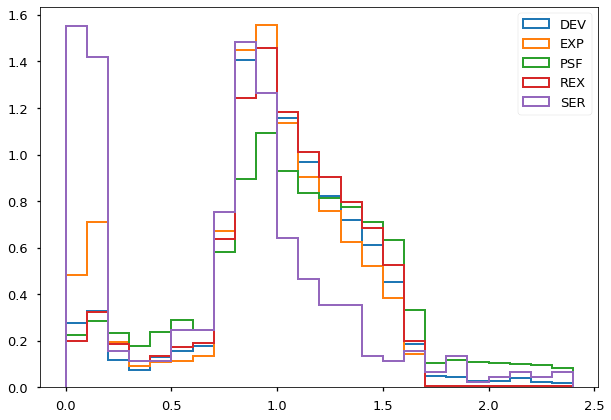

In [19]:
plt.figure(figsize = (10, 7))

for morph in np.unique(zcat_elg['MORPHTYPE']):
    flag = (zcat_elg['MORPHTYPE'] == morph)
    plt.hist(zcat_elg[flag]['Z'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)
    
plt.legend(loc = 'best')

### Distribution of `SPECTYPE` in shape relatd features of interest

`SHAPE_R` is 0 in PSF

#### Distribution of `SPECTYPE` in `SHAPE_R`

Text(0.5, 0.01, 'SHAPE_R')

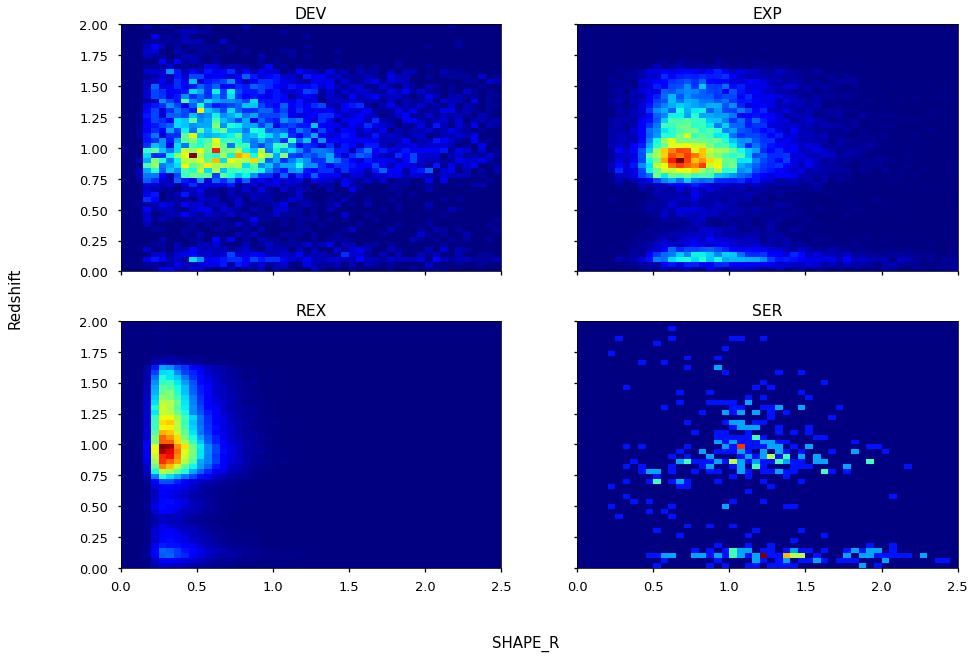

In [80]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey = True, figsize = (15, 10))

ii = 0

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    
    if(ii == 0):
        coord = (0,0)
    elif(ii == 1):
        coord = (0,1)
    elif(ii == 2):
        coord = (1,0)
    elif(ii == 3):
        coord = (1,1)
        
    axs[coord].hist2d(zcat_elg[flag]['SHAPE_R'], zcat_elg[flag]['Z'], 
                 bins = 50, cmap = plt.cm.jet, range = np.array([[0, 2.5], [0, 2]]));
    axs[coord].set_title(morph)
    
    ii += 1

# hide tick and tick label of the big axis
fig.supylabel('Redshift', fontsize = 15)
fig.supxlabel('SHAPE_R', fontsize = 15)

#### Distribution in `SHAPE_E1` and `SHAPE_E2`

In [20]:
for morph in ['DEV', 'EXP', 'REX', 'SER']:
    print(morph)
    flag = (zcat_elg['MORPHTYPE'] == morph)
    print(zcat_elg[flag]['SHAPE_E1'].std(ddof = 1))

DEV
0.2562722
EXP
0.27485916
REX
0.0
SER
0.35186917


Text(0.5, 0.01, 'SHAPE_R1')

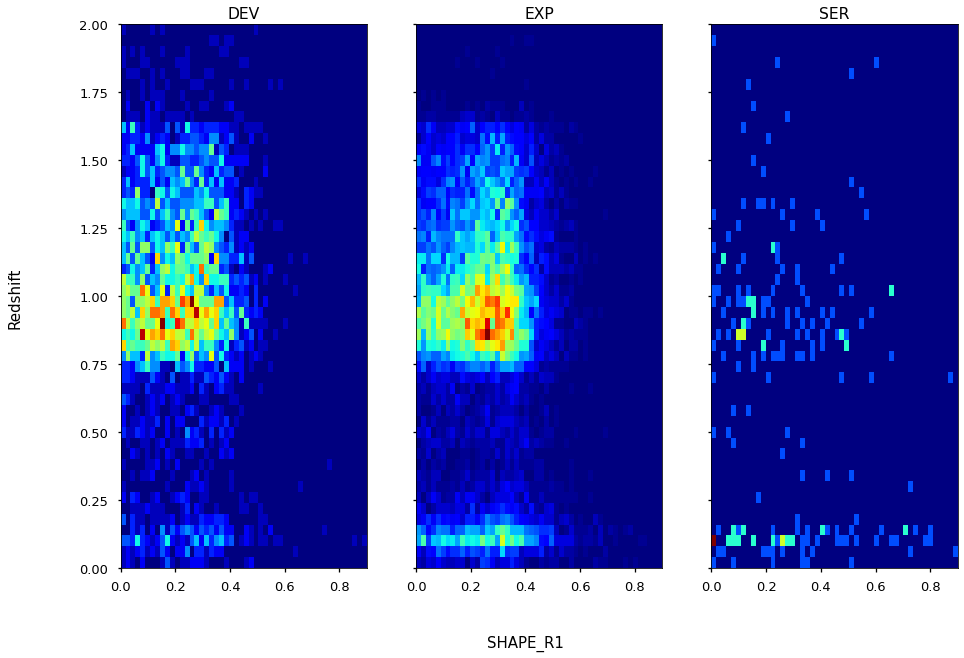

In [20]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey = True, figsize = (15, 10))

ii = 0

for morph in ['DEV', 'EXP', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
        
    axs[ii].hist2d(zcat_elg[flag]['SHAPE_E1'], zcat_elg[flag]['Z'], 
                 bins = 50, cmap = plt.cm.jet, range = np.array([[0, 0.9], [0, 2]]));
    axs[ii].set_title(morph)
    
    ii += 1

# hide tick and tick label of the big axis
fig.supylabel('Redshift', fontsize = 15)
fig.supxlabel('SHAPE_R1', fontsize = 15)

In [ ]:
plt.figure(figsize = (10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    plt.hist2d(zcat_elg[flag]['SHAPE_R'], zcat_elg[flag]['Z'], bins = 50, 
               histtype= 'step', range = np.array([[0, 2.5], [0, 2.]])
             label = morph, lw = 2, density = True)
    
plt.legend(loc = 'best')

Mean of DEV in SHAPE_R: 1.116983413696289
Mean of EXP in SHAPE_R: 0.9024718403816223
Mean of REX in SHAPE_R: 0.4026206433773041
Mean of SER in SHAPE_R: 1.2961056232452393


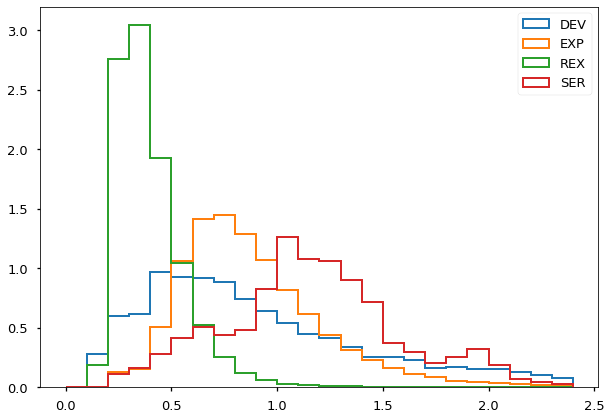

In [73]:
plt.figure(figsize = (10, 7))

for morph in ['DEV', 'EXP', 'REX', 'SER']:
    flag = (zcat_elg['MORPHTYPE'] == morph)
    print(f"Mean of {morph} in SHAPE_R: {zcat_elg[flag]['SHAPE_R'].mean()}")
    plt.hist(zcat_elg[flag]['SHAPE_R'], bins = np.arange(0, 2.5, 0.1), histtype= 'step', 
             label = morph, lw = 2, density = True)
    
plt.legend(loc = 'best')

### Flag for removing Sersic galaxies as they are low-z 

In [19]:
is_not_sersic = (zcat_elg['MORPHTYPE'] != 'SER')
zcat_elg = zcat_elg[is_not_sersic]

## Test 2: Does `FOII_SNR` vs `DELTACHI2` cut cluster?

### Anand's [OII] flux dataset

We use this dataset to apply the FOII_SNR vs DELTACHI2 cut

In [20]:
# augment [OII] flux for the training galaxies

#relevant emline.fits files generated by Anand Raichoor
from astropy.table import Table, vstack
from glob import glob
fns=sorted(glob("/global/cfs/cdirs/desi/spectro/redux/fuji/healpix/sv3/dark/*/*/emline*fits"))

# those all have unique targetids, and no overlap
e = vstack([Table.read(fn,"EMLINEFIT") for fn in fns], metadata_conflicts="silent")

In [21]:
# check if TARGETID are unique 

def duplicate_test(A):
    return np.any(np.diff(np.sort(A, axis=0), axis=0) == 0)

print(duplicate_test(zcat_elg['TARGETID']))
print(duplicate_test(e['TARGETID']))

False
False


In [22]:
# then match by TARGETID

from desitarget.geomask import match, match_to

is_in_elg_cat = match_to(e['TARGETID'], zcat_elg['TARGETID'])
e_elg = e[is_in_elg_cat]

In [23]:
#verify that the ordering of the sliced Table matches zcat_elg

(zcat_elg['TARGETID']== e_elg['TARGETID']).sum() - len(zcat_elg)

0

In [24]:
#augment zcat_elg table
zcat_elg['OII_FLUX'] = e_elg['OII_FLUX']
zcat_elg['OII_FLUX_IVAR'] = e_elg['OII_FLUX_IVAR']
zcat_elg['OII_SNR'] = zcat_elg['OII_FLUX'] * np.sqrt(zcat_elg['OII_FLUX_IVAR'])
zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])
zcat_elg['log10_DELTACHI2'] = np.log10(zcat_elg['DELTACHI2'])

/tmp/ipykernel_24696/3030149548.py:5: RuntimeWarning: invalid value encountered in log10
  zcat_elg['log10_OII_SNR'] = np.log10(zcat_elg['OII_SNR'])


## Are the TARGETID in `zcat_elg` unique?

In [25]:
len(zcat_elg['TARGETID'])

390445

In [26]:
len(np.unique(zcat_elg['TARGETID']))

390445

In [27]:
len(zcat['TARGETID'])

862947

In [28]:
len(np.unique(zcat['TARGETID']))

862947

If the `TARGETID` were not unique, then the numbers would not be the same as the length of the second array would be smaller. 

### astropy casting issue
Note this interesting situation where converting masked values into numpy casts it as 1. We need to get rid of rows with masked values because these galaxies cannot be used for flux based selection. 

In [30]:
print(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)])
print(np.array(zcat_elg['log10_OII_SNR'][(zcat_elg['OII_FLUX'].mask)]))

log10_OII_SNR
-------------
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
          ...
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
           --
Length = 20199 rows
[1. 1. 1. ... 1. 1. 1.]


### Selection based on unmasked OII_FLUX

In [20]:
# zcat_elg = zcat_elg[~(zcat_elg['log10_OII_SNR'].mask)]
# print(len(zcat_elg))

In [29]:
# selection cut of Anand
def oii_sel(x):
    return 0.9 - 0.2 * x
tmpx = np.arange(-1,6, .5)

### OII_FLUX vs DELTACHI2

We check the distribution to define the cut 

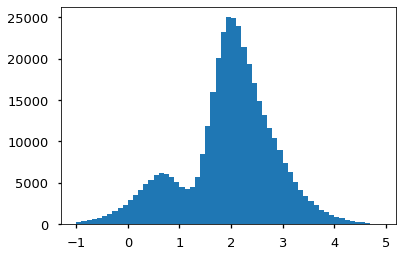

In [30]:
plt.hist(np.log10(zcat_elg['DELTACHI2']), bins = np.arange(-1, 5, .1));

In [ ]:
# my selection cut 
def oii_sel_new(x):
    y = np.ones_like(x)
    y[x < 1] = 0.75
    y[x>=1] = 1.5 - 0.75*x[x >= 1]
    
    return y

In [ ]:
plt.hist(zcat_elg['log10_OII_SNR'], bins = np.arange(-1,2, 0.05));

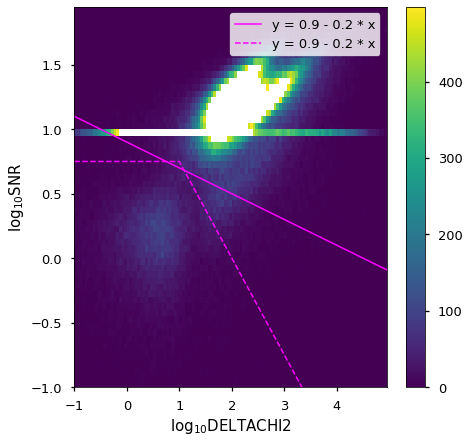

In [24]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_elg['log10_DELTACHI2'], zcat_elg['log10_OII_SNR'], 
           bins = [np.arange(-1, 5, .05), np.arange(-1,2, .05)], cmax = 500);
plt.plot(tmpx, oii_sel(tmpx), c = 'magenta', lw = 1.5, ls = 'solid', 
          label = 'y = 0.9 - 0.2 * x')
plt.plot(tmpx, oii_sel_new(tmpx), c = 'magenta', lw = 1.5, ls = 'dashed', 
          label = 'y = 0.9 - 0.2 * x')
plt.xlabel(r"$\log_{10} {\rm DELTACHI2}$", fontsize = 15)
plt.ylabel(r"$\log_{10} {\rm SNR}$", fontsize = 15)
plt.legend(loc = 'best')
plt.colorbar()

We make a plot similar to Anand's target selection paper showing relationship with redshift.

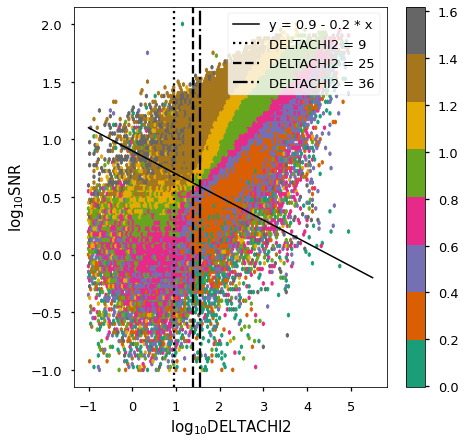

In [25]:
plt.figure(figsize = (7,7))
plt.hexbin(zcat_elg['log10_DELTACHI2'], zcat_elg['log10_OII_SNR'],
           gridsize = (120,60), extent=(-1,5,-1,2), 
          cmap = 'Dark2', marginals=False, C = zcat_elg['Z'])
plt.plot(tmpx, oii_sel(tmpx), c = 'k', lw = 1.5, ls = 'solid', 
        label = 'y = 0.9 - 0.2 * x')
# plt.plot(tmpx, oii_sel_new(tmpx), c = 'k', lw = 1.5, ls = 'dashed', 
#          label = 'sel new')
plt.axvline(np.log10(9), c = 'k', ls = 'dotted', label = 'DELTACHI2 = 9')
plt.axvline(np.log10(25), c = 'k', ls = 'dashed', label = 'DELTACHI2 = 25')
plt.axvline(np.log10(36), c = 'k', ls = 'dashdot', label = 'DELTACHI2 = 36')
plt.legend(loc = 'best')
plt.xlabel(r"$\log_{10} {\rm DELTACHI2}$", fontsize = 15)
plt.ylabel(r"$\log_{10} {\rm SNR}$", fontsize = 15)
plt.colorbar()

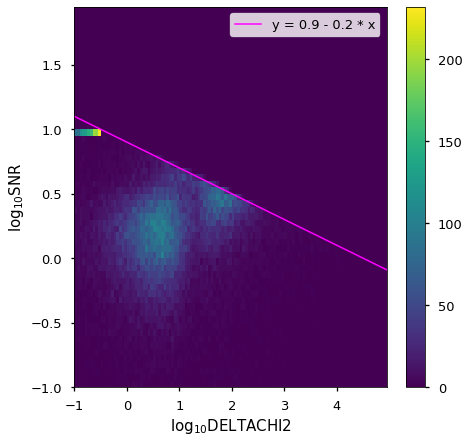

In [26]:
#contour of ELGs below selection 
tmpsel = (zcat_elg['log10_OII_SNR']) < oii_sel(zcat_elg['log10_DELTACHI2'])

plt.figure(figsize = (7,7))
plt.hist2d(zcat_elg['log10_DELTACHI2'][tmpsel], zcat_elg['log10_OII_SNR'][tmpsel], 
           bins = [np.arange(-1, 5, .05), np.arange(-1,2, .05)]);
plt.plot(tmpx, oii_sel(tmpx), c = 'magenta', lw = 1.5, ls = 'solid', 
          label = 'y = 0.9 - 0.2 * x')
plt.xlabel(r"$\log_{10} {\rm DELTACHI2}$", fontsize = 15)
plt.ylabel(r"$\log_{10} {\rm SNR}$", fontsize = 15)
plt.legend(loc = 'best')
plt.colorbar()

## Apply [O II] flux based cut

In [30]:
zcat_elg['Z'].max()

5.953989547733417

In [31]:
# # apply oii flux based selection
is_oii_good = (zcat_elg['log10_OII_SNR']) > oii_sel(zcat_elg['log10_DELTACHI2'])
# print(is_oii_good.sum()/len(zcat_elg))
# zcat_elg = zcat_elg[is_oii_good]
# print(f'Size of the training sample: {len(zcat_elg)}')

Note that we need to classify bad regions where QSOs and SPECTYPE STAR cluster (if any)

### `fuji` ELG redshift distribution

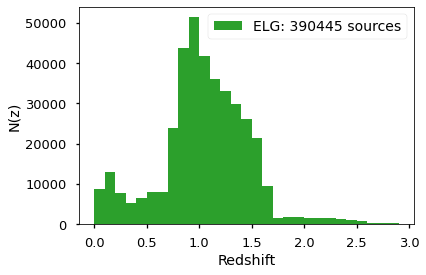

In [37]:
# Now let us look at the distribution of redshifts -

#fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 3, 0.1)

plt.ylabel("N(z)")
plt.xlabel("Redshift")
hist_full = plt.hist(zcat_elg['Z'], color = 'C2', bins = bins, label = f'ELG: {len(zcat_elg)} sources')
plt.legend(fontsize = 14)

In [31]:
Redshift_Ledge = hist_full[1][:-1]
Redshift_mid = Redshift_Ledge + np.diff(hist_full[1])/2
nz = hist_full[0]

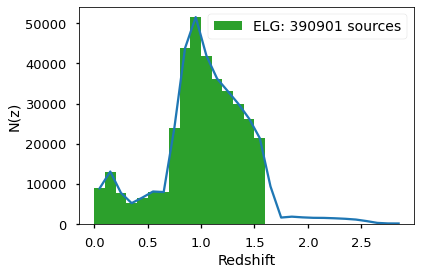

In [32]:
# Now let us look at the distribution of redshifts -

#fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 1.7, 0.1)

plt.ylabel("N(z)")
plt.xlabel("Redshift")
hist_full = plt.hist(zcat_elg['Z'], color = 'C2', bins = bins, label = f'ELG: {len(zcat_elg)} sources')
plt.plot(Redshift_mid, nz)
plt.legend(fontsize = 14)

In [27]:
#save n(z) distribution for the full sample
df_nz = pd.DataFrame(np.vstack((Redshift_Ledge, Redshift_mid, nz)).T, columns=['Redshift_Ledge', 'Redshift_mid', 'dndz'])

np.save("../dat/nz_fuji_all_numbercount", df_nz)

## FDR cut for plotting purposes

In [32]:
#DEFINE FDR CUT FOR PLOTTING PURPOSES

def fdr_plot(axs):
    #rz 0.15 cut 
    rz3_x = .15 * np.ones(10)
    rz3_y = np.linspace(-.5, .18, 10)
    
    #rz 1.6 cut
    rz16_x = 1.6 * np.ones(100)
    rz16_y = np.linspace(-.5, -.32, 100)
    
    #star/lowz cut
    lowz_x = np.arange(0.15, 15/17, .01)
    #lowzSouth_y = 1.15 * lowz_x -.15
    #lowzNorth_y = 1.15 * lowz_x -.20
    lowz_y = 0.5 * lowz_x + 0.1
    
    # [O II] cut
    OIIx = np.arange(15/17, 1.6, .01)
    OIIy = -1.2 * OIIx + 1.6
       
    axs.plot(rz3_x, rz3_y, c = 'magenta')
    axs.plot(rz16_x, rz16_y, c = 'k')
    axs.plot(OIIx, OIIy, c = 'y', label = '[O II] cut')
    axs.plot(lowz_x, lowz_y, c = 'r', label = 'lowz cut')
    #axs.legend(loc = 'best')

## Statistics of bad ELGs

In [33]:
#define flag for galaxies with no OII flux or negative OII flux
is_bad_flux = zcat_elg['log10_OII_SNR'].mask

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


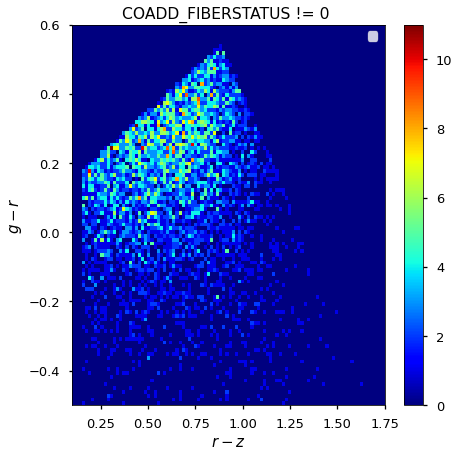

In [34]:
plt.figure(figsize = (7,7))
plt.hist2d(zcat_good_photsys['r-z'][~is_coadd_good_photsys], zcat_good_photsys['g-r'][~is_coadd_good_photsys], 
            bins = 100, cmap = plt.cm.jet, range = range2d, vmin = vmin);
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.title("COADD_FIBERSTATUS != 0 ")
plt.legend(loc = 'best')
plt.colorbar()

Text(0.02, 0.5, 'g-r')

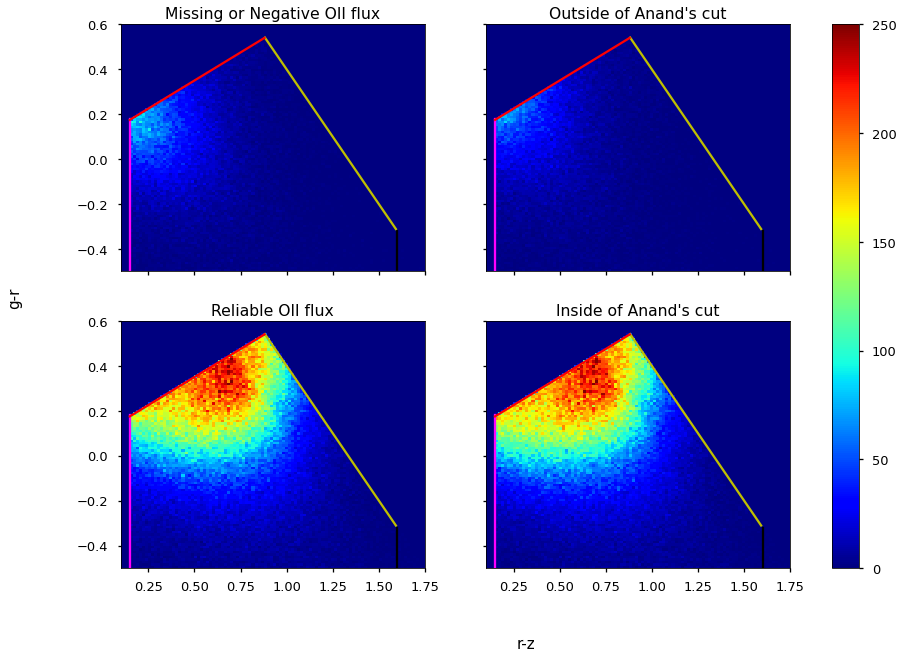

In [39]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (15, 10))

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing or Negative OII flux")
fdr_plot(axs[0,0])

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Inside of Anand's cut")
fdr_plot(axs[1,1])

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux")
fdr_plot(axs[1,0])

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Outside of Anand's cut")
fdr_plot(axs[0,1])

#add common colorbar
fig.colorbar(im[3], ax=axs.ravel().tolist())

# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 15)
fig.supylabel('g-r', fontsize = 15)

### Observation
Unreliable OII flux measurements and Anand's cut coincides. But the relative density is low. We have to measure the relative occurance of failure modes in those regions compared to outside. 

## Test 3: Does `SPECTYPE != GALAXY` cluster?

In [34]:
np.unique(zcat_elg['SPECTYPE'])

<Column name='SPECTYPE' dtype='bytes6' length=3>
GALAXY
   QSO
  STAR

What percentage of misclassified `SPECTYPE` are STAR and QSO?

In [35]:
print(f"frac of QSO: {(zcat_elg['SPECTYPE'] == 'QSO').sum()/len(zcat_elg) * 100}")
print(f"frac of STAR: {(zcat_elg['SPECTYPE'] == 'STAR').sum()/len(zcat_elg) * 100}")

frac of QSO: 4.952041900907939
frac of STAR: 0.19644252071354482


In [36]:
is_spectype = (zcat_elg['SPECTYPE'] == 'GALAXY')

Text(0.02, 0.5, 'g-r')

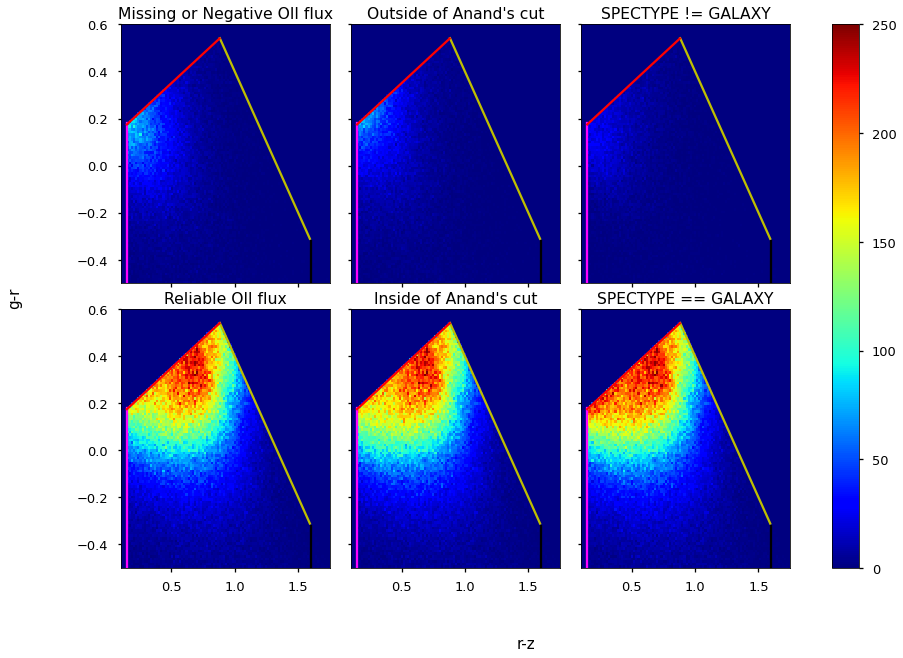

In [40]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0, 0].hist2d(zcat_elg['r-z'][is_bad_flux], zcat_elg['g-r'][is_bad_flux], 
                 bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,0].set_title("Missing or Negative OII flux")
fdr_plot(axs[0,0])

axs[1,1].hist2d(zcat_elg['r-z'][is_oii_good], zcat_elg['g-r'][is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,1].set_title("Inside of Anand's cut")
fdr_plot(axs[1,1])

axs[1,0].hist2d(zcat_elg['r-z'][~is_bad_flux], zcat_elg['g-r'][~is_bad_flux], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,0].set_title("Reliable OII flux")
fdr_plot(axs[1,0])

im = axs[0,1].hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,1].set_title("Outside of Anand's cut")
fdr_plot(axs[0,1])

axs[0,2].hist2d(zcat_elg['r-z'][~is_spectype], zcat_elg['g-r'][~is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[0,2].set_title("SPECTYPE != GALAXY")
fdr_plot(axs[0,2])

axs[1,2].hist2d(zcat_elg['r-z'][is_spectype], zcat_elg['g-r'][is_spectype], 
                bins = nbins, cmap = plt.cm.jet, range = range2d, vmin = vmin, vmax = vmax);
axs[1,2].set_title("SPECTYPE == GALAXY")
fdr_plot(axs[1,2])

#add common colorbar
fig.colorbar(im[3], ax=axs.ravel().tolist())

# hide tick and tick label of the big axis
fig.supxlabel('r-z', fontsize = 15)
fig.supylabel('g-r', fontsize = 15)

### Observation
Yes they cluster the same way.

## Does $g_{\rm fib} < 24.1$ cluster? 

Text(0.5, 1.0, 'zfib')

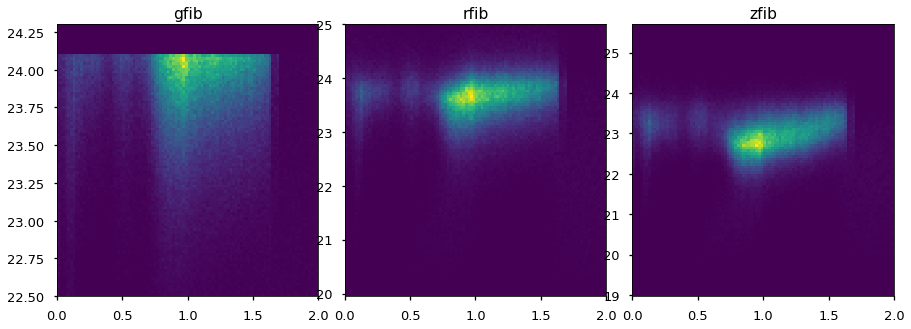

In [46]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0].hist2d(zcat_elg['Z'], zcat_elg['gfib'], bins = 100, range = np.array([[0, 2], [22.5, 24.3]]));
axs[0].set_title("gfib")

axs[1].hist2d(zcat_elg['Z'], zcat_elg['rfib'], bins = 100, range = np.array([[0, 2], [19.95, 25]]));
axs[1].set_title("rfib")

axs[2].hist2d(zcat_elg['Z'], zcat_elg['zfib'], bins = 100, range = np.array([[0, 2], [18.97, 25.7]]));
axs[2].set_title("zfib")


## Trend of g-band magnitude vs redshift

Text(0.5, 1.0, 'z')

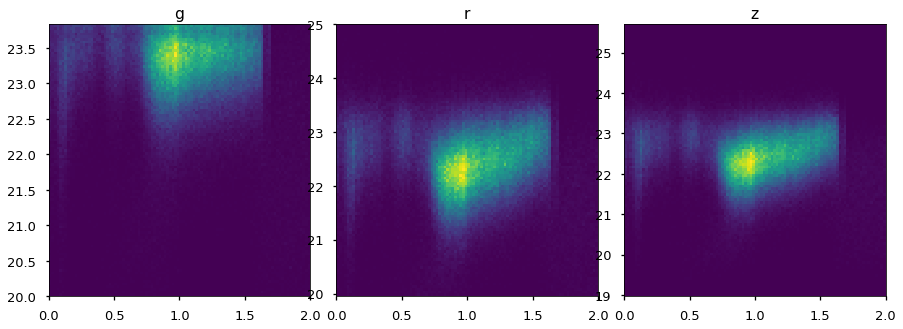

In [36]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0].hist2d(zcat_elg['Z'], zcat_elg['MAG_G'], bins = 100, range = np.array([[0, 2], [20, 23.83]]));
axs[0].set_title("g")

axs[1].hist2d(zcat_elg['Z'], zcat_elg['MAG_Z'], bins = 100, range = np.array([[0, 2], [19.95, 25]]));
axs[1].set_title("r")

axs[2].hist2d(zcat_elg['Z'], zcat_elg['MAG_Z'], bins = 100, range = np.array([[0, 2], [18.97, 25.7]]));
axs[2].set_title("z")


Here we are ask the question *What fraction of objects below the $g$-magnitude threshold are low-z interlopers compared to fraction of objects above the threshold?* This question allows us to investigate whether making a more conservative $g$-band cut can help in getting rid of more low-z interlopers. 

We also ask a complementary question: *What fraction of objects from the total sample have to be discarded to get a purer sample?* This question allows us to balance our aggressiveness with the cut with the number of samples left. 

We finally ask the question: *What fraction of objects below and above the threshold are `SPECTYPE != GALAXY`. This answers the question whether by imposing these cuts, we can smartly get rid of stars and QSOs. To do this, we modify the definition of `misc_bad_bin` where we do not make exclusions based on `SPECTYPE`.

In [41]:
zcat_elg['MAG_G'].min()

19.999120826061034

In [42]:
g_threshold = 22.1
misc_bad_bin_notspec = is_bad_flux | (~(is_oii_good.filled(False))) #bad bin definition except spec type
tmpsel = (zcat_elg['MAG_G'] < g_threshold) #& (~misc_bad_bin_notspec)
tmpselneg = (zcat_elg['MAG_G'] >= g_threshold) #& (~misc_bad_bin_notspec)
print(f'% of SV3 sample discarded due to threshold: {tmpsel.sum()/len(tmpsel) * 100}')
#plt.hist2d(zcat_elg['Z'], zcat_elg['MAG_G'], bins = 100, range = np.array([[0, 2], [20.5, 23.83]]));

% of SV3 sample discarded due to threshold: 4.522531982737645


Text(0.5, 1.0, 'g threshold: 22.1')

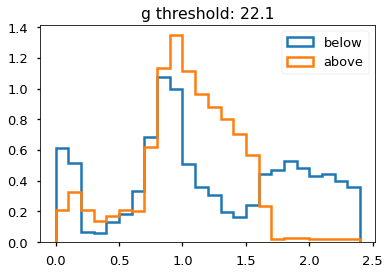

In [41]:
plt.hist(zcat_elg['Z'][tmpsel], bins = np.arange(0, 2.5, 0.1), histtype= 'step', label = 'below', lw = 2.5, density = True)
plt.hist(zcat_elg['Z'][tmpselneg], bins = np.arange(0, 2.5, 0.1), histtype= 'step', label = 'above', lw = 2.5, density = True)
plt.legend(loc = 'best')
plt.title(f"g threshold: {g_threshold}")

In [49]:
print(f"% of obj below threshold with z < 0.6: {(zcat_elg['Z'][tmpsel] < 0.6).sum()/len(zcat_elg['Z'][tmpsel]) * 100}")
print(f"% of obj above thredshold with z < 0.6: {(zcat_elg['Z'][tmpselneg] < 0.6).sum()/len(zcat_elg['Z'][tmpselneg]) * 100}")

print(f"% of obj below threshold with z > 1.6: {(zcat_elg['Z'][tmpsel] > 1.6).sum()/len(zcat_elg['Z'][tmpsel]) * 100}")
print(f"% of obj above thredshold with z > 1.6: {(zcat_elg['Z'][tmpselneg] > 1.6).sum()/len(zcat_elg['Z'][tmpselneg]) * 100}")

% of obj below threshold with z < 0.6: 15.539698720126854
% of obj above thredshold with z < 0.6: 12.895567710247407
% of obj below threshold with z > 1.6: 38.91720466644014
% of obj above thredshold with z > 1.6: 4.525104147945074


### What is the g-band cut off to remove low-z and high-z interlopers?
We notice that g-band is a good indicator of both low-z and high-z interlopers. We can make g-band cut stronger to remove these interlopers.

In [54]:
def interloper_percentange_counter(g_threshold):
    """Return percentage of interlopers below and above the threshold"""
    
    selbelow = (zcat_elg['MAG_G'] < g_threshold)# & (~misc_bad_bin_notspec)
    selabove = (zcat_elg['MAG_G'] >= g_threshold)# & (~misc_bad_bin_notspec)
    
    percentage_interloper_below_low = np.round((zcat_elg['Z'][selbelow] < 0.6).sum()/len(zcat_elg['Z'][selbelow]) * 100, 2)
    percentage_interloper_above_low = np.round((zcat_elg['Z'][selabove] < 0.6).sum()/len(zcat_elg['Z'][selabove]) * 100, 2)

    percentage_interloper_below_hi = np.round((zcat_elg['Z'][selbelow] > 1.6).sum()/len(zcat_elg['Z'][selbelow]) * 100, 2)
    percentage_interloper_above_hi = np.round((zcat_elg['Z'][selabove] > 1.6).sum()/len(zcat_elg['Z'][selabove]) * 100, 2)

    
    print(f"threshold mag {np.round(g_threshold,2)} -- % below the threshold {np.round(selbelow.sum()/len(selbelow) * 100, 2)} -- below % {percentage_interloper_below_low} -- above % {percentage_interloper_above_low}")
    print(f"threshold mag {np.round(g_threshold,2)} -- below % {percentage_interloper_below_hi} -- above % {percentage_interloper_above_hi}")
    
    return percentage_interloper_below_low, percentage_interloper_above_low

In [57]:
g_threshold_arr = np.arange(20.1, 23., 0.1)
yarr = np.zeros((len(g_threshold_arr),2))

for i in range(len(g_threshold_arr)):
    yarr[i] = interloper_percentange_counter(g_threshold_arr[i])

threshold mag 20.1 -- % below the threshold 0.07 -- below % 19.77 -- above % 13.01
threshold mag 20.1 -- below % 61.24 -- above % 6.04
threshold mag 20.2 -- % below the threshold 0.13 -- below % 19.57 -- above % 13.01
threshold mag 20.2 -- below % 60.66 -- above % 6.01
threshold mag 20.3 -- % below the threshold 0.21 -- below % 18.2 -- above % 13.0
threshold mag 20.3 -- below % 60.89 -- above % 5.97
threshold mag 20.4 -- % below the threshold 0.29 -- below % 17.87 -- above % 13.0
threshold mag 20.4 -- below % 60.42 -- above % 5.92
threshold mag 20.5 -- % below the threshold 0.39 -- below % 17.37 -- above % 13.0
threshold mag 20.5 -- below % 60.29 -- above % 5.87
threshold mag 20.6 -- % below the threshold 0.49 -- below % 17.09 -- above % 12.99
threshold mag 20.6 -- below % 60.18 -- above % 5.81
threshold mag 20.7 -- % below the threshold 0.59 -- below % 16.08 -- above % 13.0
threshold mag 20.7 -- below % 59.81 -- above % 5.76
threshold mag 20.8 -- % below the threshold 0.72 -- below % 

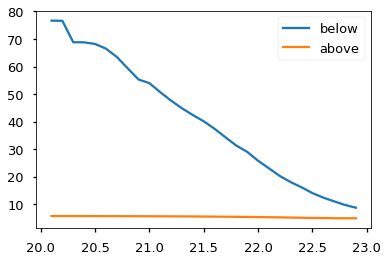

In [54]:
plt.plot(g_threshold_arr, yarr[:,0], label = "below")
plt.plot(g_threshold_arr, yarr[:,1], label = "above")
plt.legend(loc = 'best')

In [42]:
for typ in ['GALAXY', 'QSO', 'STAR']:
    print(typ)
    print(f"% obj below threshold: {(zcat_elg[tmpsel]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpsel]) * 100}")
    print(f"% obj above threshold: {(zcat_elg[tmpselneg]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpselneg]) * 100}")
    print("----")

GALAXY
% obj below threshold: 48.90701098652169
% obj above threshold: 97.027793351163
----
QSO
% obj below threshold: 50.11892626571526
% obj above threshold: 2.812598078795666
----
STAR
% obj below threshold: 0.9740627477630536
% obj above threshold: 0.15960857004133727
----


### What is the histogram of `SPECTYPE` as a function of `MAG_G`?

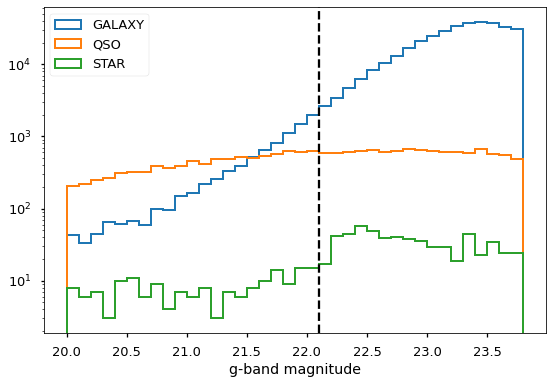

In [40]:
plt.figure(figsize=(9, 6))
for typ in ['GALAXY', 'QSO', 'STAR']:
    tmpflag = (zcat_elg['SPECTYPE'] == typ)# & (~misc_bad_bin_notspec)
    plt.hist(zcat_elg[tmpflag]['MAG_G'], bins = np.arange(20, 23.83, 0.1), label = typ, histtype= 'step',
            lw = 2, density = False)
plt.axvline(g_threshold, c = 'k', ls = '--')
plt.legend(loc = 'upper left')
plt.xlabel("g-band magnitude")
plt.yscale("log")

## $g_{\rm fib}$ cut off and its impact on dndz

% of SV3 sample discarded due to g_fib threshold: 1.0925994698357002


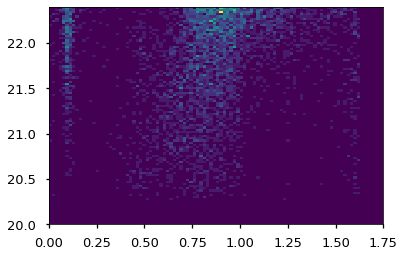

In [41]:
g_fib_threshold = 22.4
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) & (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) & (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')
plt.hist2d(zcat_elg['Z'][tmpsel_fib], zcat_elg['gfib'][tmpsel_fib], bins = 100, 
           range = np.array([[0, 1.75], [20, g_fib_threshold]]));

Text(0.5, 1.0, 'gfib threshold: 22.4')

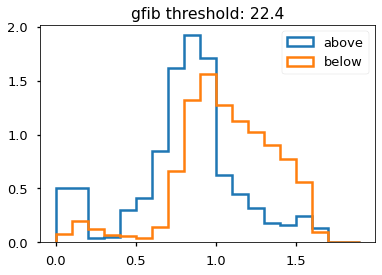

In [42]:
plt.hist(zcat_elg['Z'][tmpsel_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'above', lw = 2.5, density = True)
plt.hist(zcat_elg['Z'][tmpselneg_fib], bins = np.arange(0, 2, 0.1), histtype= 'step', label = 'below', lw = 2.5, density = True)
plt.legend(loc = 'best')
plt.title(f"gfib threshold: {g_fib_threshold}")

Text(0, 0.5, 'Count')

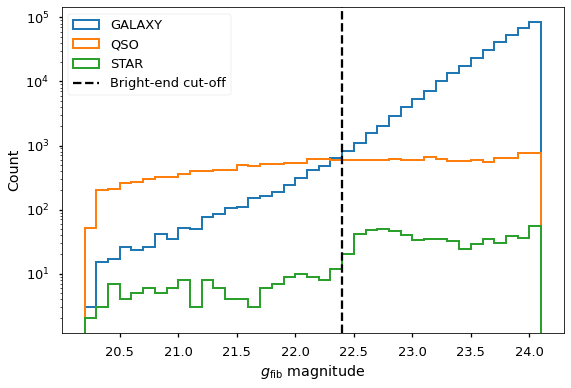

In [43]:
plt.figure(figsize=(9, 6))
for typ in ['GALAXY', 'QSO', 'STAR']:
    tmpflag = (zcat_elg['SPECTYPE'] == typ)# & (~misc_bad_bin_notspec)
    plt.hist(zcat_elg[tmpflag]['gfib'], bins = np.arange(20.2, 24.1, 0.1), label = typ, histtype= 'step',
            lw = 2, density = False)
plt.yscale("log")
plt.axvline(g_fib_threshold, c = 'k', ls = '--', label = 'Bright-end cut-off')
plt.legend(loc = 'upper left')
plt.xlabel(r"$g_{\rm fib}$ magnitude")
plt.ylabel("Count")
#plt.savefig("../plots/gfib_cut.pdf", bbox_inches = 'tight', dpi = 450)

Text(0.5, 1.0, 'Distribution for objects with 1.1 < z < 1.6')

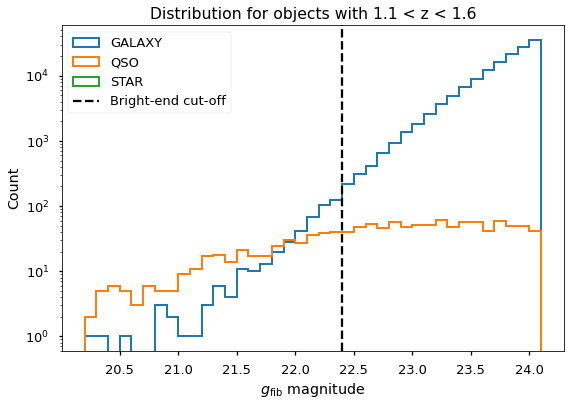

In [43]:
plt.figure(figsize=(9, 6))
for typ in ['GALAXY', 'QSO', 'STAR']:
    tmpflag = (zcat_elg['SPECTYPE'] == typ) & ((zcat_elg['Z'] > 1.1) & (zcat_elg['Z'] < 1.6)) # & (~misc_bad_bin_notspec)
    plt.hist(zcat_elg[tmpflag]['gfib'], bins = np.arange(20.2, 24.1, 0.1), label = typ, histtype= 'step',
            lw = 2, density = False)
plt.yscale("log")
plt.axvline(g_fib_threshold, c = 'k', ls = '--', label = 'Bright-end cut-off')
plt.legend(loc = 'upper left')
plt.xlabel(r"$g_{\rm fib}$ magnitude")
plt.ylabel("Count")
plt.title("Distribution for objects with 1.1 < z < 1.6")
#plt.savefig("../plots/gfib_cut.pdf", bbox_inches = 'tight', dpi = 450)

In [44]:
#g_fib_threshold = 22.4
tmpsel_fib = (zcat_elg['gfib'] < g_fib_threshold) & (~misc_bad_bin_notspec)
tmpselneg_fib = (zcat_elg['gfib'] >= g_fib_threshold) & (~misc_bad_bin_notspec)

print(f'% of SV3 sample discarded due to g_fib threshold: {tmpsel_fib.sum()/len(tmpsel_fib) * 100}')

% of SV3 sample discarded due to g_fib threshold: 1.0925994698357002


In [45]:
for typ in ['GALAXY', 'QSO', 'STAR']:
    print(typ)
    print(f"% obj below threshold: {(zcat_elg[tmpsel_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpsel_fib]) * 100}")
    print(f"% obj above threshold: {(zcat_elg[tmpselneg_fib]['SPECTYPE'] == typ).sum()/len(zcat_elg[tmpselneg_fib]) * 100}")
    print("----")

GALAXY
% obj below threshold: 62.89263947491796
% obj above threshold: 99.80333645172524
----
QSO
% obj below threshold: 36.94327238631036
% obj above threshold: 0.19222496124772095
----
STAR
% obj below threshold: 0.16408813877168307
% obj above threshold: 0.004438587027034409
----


In [ ]:
def interloper_percentange_counter_fib(g_fib_threshold):
    """Return percentage of interlopers below and above the threshold"""
    
    selbelow = (zcat_elg['MAG_G'] < g_fib_threshold) & (~misc_bad_bin)
    selabove = (zcat_elg['MAG_G'] >= g_fib_threshold) & (~misc_bad_bin)
    
    percentage_interloper_below = np.round((zcat_elg['Z'][selbelow] < 0.6).sum()/len(zcat_elg['Z'][selbelow]) * 100, 2)
    percentage_interloper_above = np.round((zcat_elg['Z'][selabove] < 0.6).sum()/len(zcat_elg['Z'][selabove]) * 100, 2)
    
    print(f"threshold mag {g_threshold} -- % below the threshold {np.round(selbelow.sum()/len(selbelow) * 100, 2)} -- below % {percentage_interloper_below} -- above % {percentage_interloper_above}")
    
    return percentage_interloper_below, percentage_interloper_above

## Test 4: What fraction of ELGs inside the bad region is reliable vs outside? 
Should we simply get rid of it?

We at first define a circle cut that we can implement to roughly assess the boundary of the bad ELGs. We then use this boundary definition to roughly calculate the fraction of ELGs 

In [83]:
def circle_cut(r, h, k):
    theta = np.linspace( 0 , 2 * np.pi , 150 )
    
    x = r * np.cos(theta) + h
    y = r * np.sin(theta) + k
    
    return x, y

In [84]:
tmpxx, tmpyy = circle_cut(.15, .15, .18)

In [85]:
is_in_circle = ((zcat_elg['r-z'] - .15)**2 + (zcat_elg['g-r'] - .18)**2 < .15**2)

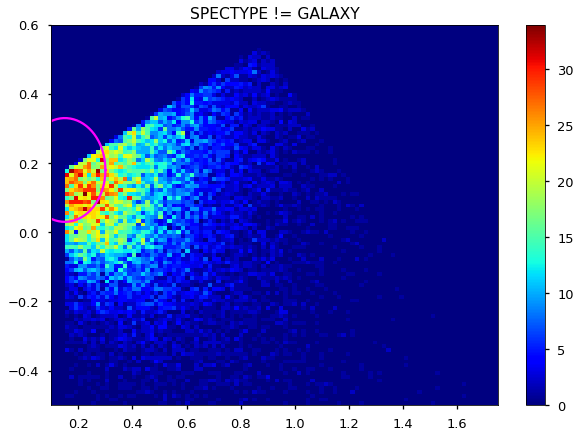

In [86]:
plt.figure(figsize = (10, 7))
plt.hist2d(zcat_elg['r-z'][~is_spectype], zcat_elg['g-r'][~is_spectype], 
           bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0);
# plt.hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
#             bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0);
plt.title("SPECTYPE != GALAXY")
plt.colorbar()
#

_plot()
plt.plot(tmpxx, tmpyy, c = 'magenta')

In [87]:
#helper function to round ratio to two decimals
def ratio_rounder(num, denom):
    return np.round(num/denom, 2)

In [88]:
print(f"Missing or Negative flux -- %bad/total inside: {ratio_rounder(((is_bad_flux) & is_in_circle).sum(), is_in_circle.sum())} -- %bad/total outside: {ratio_rounder(((is_bad_flux) & (~is_in_circle)).sum(), (~is_in_circle).sum())}")
print(f"Anand's cut -- %bad/total inside: {ratio_rounder(((~is_oii_good.filled(False)) & is_in_circle).sum(), is_in_circle.sum())} -- %bad/total outside: {ratio_rounder(((~is_oii_good) & (~is_in_circle)).sum(), (~is_in_circle).sum())}")
print(f'SPECTYPE != GALAXY -- %bad/total inside: {ratio_rounder(((~is_spectype) & is_in_circle).sum(), is_in_circle.sum())} -- %bad/total outside: {ratio_rounder(((~is_spectype) & (~is_in_circle)).sum(), (~is_in_circle).sum())}')
print(f'Total bad -- %bad/total inside: {ratio_rounder((((~is_spectype) & is_in_circle) | ((~is_oii_good.filled(False)) & is_in_circle) | ((is_bad_flux) & is_in_circle)).sum(), is_in_circle.sum())} -- %bad/total outside: {ratio_rounder((((~is_spectype) & ~is_in_circle) | ((~is_oii_good.filled(False)) & ~is_in_circle) | ((is_bad_flux) & ~is_in_circle)).sum(), (~is_in_circle).sum())}')

Missing or Negative flux -- %bad/total inside: 0.35 -- %bad/total outside: 0.12
Anand's cut -- %bad/total inside: 0.59 -- %bad/total outside: 0.09
SPECTYPE != GALAXY -- %bad/total inside: 0.12 -- %bad/total outside: 0.05
Total bad -- %bad/total inside: 0.61 -- %bad/total outside: 0.22


## Redshift distribution on the $g-r$ vs $r-z$ colour space

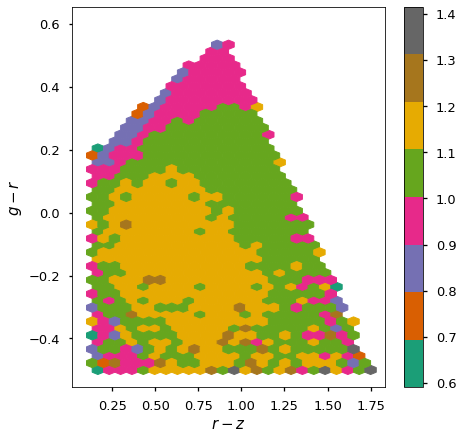

In [51]:
plt.figure(figsize = (7,7))
plt.hexbin(zcat_elg['r-z'], zcat_elg['g-r'],
           gridsize = (25,25), extent=range2d.flatten(), 
          cmap = 'Dark2', marginals=False, C = zcat_elg['Z'])
# plt.legend(loc = 'best')
plt.xlabel(r"$r-z$", fontsize = 15)
plt.ylabel(r"$g-r$", fontsize = 15)
plt.colorbar()

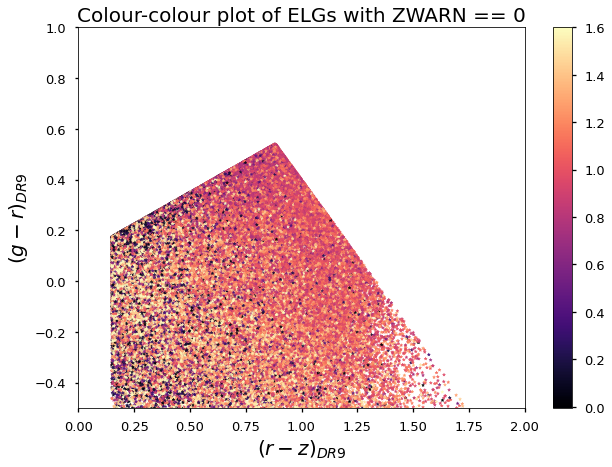

In [52]:
fs = 20
plt.figure(figsize=(10, 7))
#

_plot()
plt.scatter(zcat_elg['r-z'], zcat_elg['g-r'], marker = "*", s = 10, c = zcat_elg['Z'], cmap = 'magma', vmax = 1.6)
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.title("Colour-colour plot of ELGs with ZWARN == 0", fontsize = fs)
plt.ylim([-.5, 1])
plt.xlim([-0., 2.])
plt.colorbar()

### Observations: 
- The range $1.25 < r - z < 1.6$ is missing data and these galaxies should be masked as we do not have a good photo-z calibration.
- Apply a cut at $g - r = -0.4$ because there are pixels in the bottom part where data is missing. 

## Tomographic binning
- Make four colour bins with spec- $z < 0.6$, $0.6 < z < 1.1$, $1.1 < z < 1.6$ and $z > 1.6$ and OII Flux/DELTACHI2 based cut 
- Look at clustering of these bins on the colour-colour space
- Apply appropriate boundary cuts
- Construct the $n(z)$ from each of these bins

In [46]:
# #make bins
# pivot = 1.1
# misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Anand's cut
# lowz_interloper_bin = zcat_elg['Z'] < 0.6
# tomo_1_bin = (zcat_elg['Z'] > 0.6) & (zcat_elg['Z'] < pivot)
# tomo_2_bin = (zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)

# #bin categories; 0 = lowz, 1 = 1st tomo bin, 2 = 2nd tomo bin, 3 = highz
# bin_cat = -99 * np.ones(len(zcat_elg))

# #the ordering is important because ELGs in misc bad bin have redshift so if misc_bad_bin is not executed first, assignment of label bins will be wrong. Order of importance: misc_bad_bin, lowz, tomo1, tomo2
# for i in range(len(zcat_elg)):
#     if(misc_bad_bin[i]):
#         bin_cat[i] = 3
#     elif(lowz_interloper_bin[i]):
#         bin_cat[i] = 0
#     elif(tomo_1_bin[i]):
#         bin_cat[i] = 1
#     elif(tomo_2_bin[i]):
#         bin_cat[i] = 2

In [37]:
# three bins, low-z interloper, highz (1.1 < z < 1.65) and bad 
pivot = 0.6
misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Anand's cut
lowz_interloper_bin = (zcat_elg['Z'] < pivot) & (~misc_bad_bin)
main_bin = ((zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)) & (~misc_bad_bin)

#bin categories; 0 = lowz, 1 = 1st tomo bin, 2 = 2nd tomo bin, 3 = highz
bin_cat = -99 * np.ones(len(zcat_elg))

#assign labels
bin_cat[misc_bad_bin] = 2 #bad bin label
bin_cat[lowz_interloper_bin] = 0 
bin_cat[main_bin] = 1

# #the ordering is important because ELGs in misc bad bin have redshift so if misc_bad_bin is not executed first, assignment of label bins will be wrong. Order of importance: misc_bad_bin, lowz, tomo1, tomo2
# for i in range(len(zcat_elg)):
#     if(misc_bad_bin[i]):
#         bin_cat[i] = 2
#     elif(lowz_interloper_bin[i]):
#         bin_cat[i] = 0
#     elif(highz_bin[i]):
#         bin_cat[i] = 1

In [38]:
# # make bins with only tomo2 as the focus 
# pivot = 1.1
# misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) | (zcat_elg['Z'] < pivot) #either spectype does not match GALAXY, flux is missing or negative or does not meet Anand's cut
# tomo_2_bin = (zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65) & (~misc_bad_bin)

# #bin categories; 0 = bad or lowz, 1 = high tomo bin
# bin_cat = -99 * np.ones(len(zcat_elg))
# bin_cat[tomo_2_bin] = 1
# bin_cat[misc_bad_bin] = 0

In [39]:
for i in range(len(np.unique(bin_cat))):
    print(f"% of ELGs in bin {i} is: {(bin_cat == i).sum()/len(bin_cat)}")

% of ELGs in bin 0 is: 0.04320967101640436
% of ELGs in bin 1 is: 0.7123205573128097
% of ELGs in bin 2 is: 0.2444697716707859


In [40]:
zcat_elg['bin_label'] = bin_cat.astype(int)

In [41]:
len(zcat_elg['TARGETID'])

390445

In [42]:
len(np.unique(zcat_elg['TARGETID']))

390445

In [43]:
zcat_elg[zcat_elg['Z'] <= 1.65]['Z'].max()

1.6499620832804696

#### What fraction of ELGs have $z > 2$? 
These do not seem to be good redshift because ELGs do not have any signature in the optical range for these galaxies. How did they pass ZWARN == 0?

In [45]:
tmp = zcat_elg['Z'][zcat_elg['Z'] > 1.7]
print(f'# of ELGs in this category: {len(tmp)}')
print(f'fraction of total ELGs with ZWARN == 0 : {len(tmp)/len(zcat_elg)}')

# of ELGs in this category: 14359
fraction of total ELGs with ZWARN == 0 : 0.036733085870847094


Text(0.5, 1.0, 'z > 1.6 ELGs')

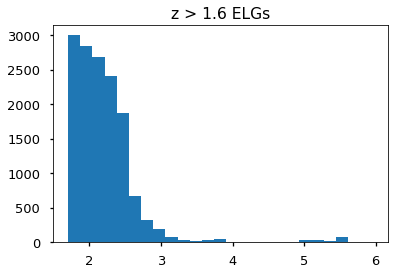

In [46]:
plt.hist(tmp, bins = 25);
plt.title("z > 1.6 ELGs")

### Problems to solve 
- How to remove ELGs that passed COADD_FIBERSTATUS == 0 but have redshift that are not good?
    - Check ZWARN !=0 and make a label to classify them. 
 - One approach is to take Anand's definition of OII flux as an additional cut and see what happens.
  - If we do this, we then also need to model where the ELGs that do not pass Anand's definition lie on the color space. 
  - The underlying issue is that while Anand's selection is good to get *redshift completeness*, at the same time with DR9 we do not have access to [O II] flux and cannot apply this cut, making it difficult to interpret. Because imagine a target in DR9 that is more like a target that does not pass Anand's selection. Then we are grossly mis-assigning the redshift. 
- Where do each of the tomographic bins reside on the parameter space?
- Where do the ZWARN != 0 reside on the parameter space? 
- Where do the SPECTYPE != ELG reside on the parameter space?
- How do we classify the tomographic bins?
    - Test with Naive Bayes, SVM, Random Forest
         - Random Forest tends to do the best 

#### What fraction of ELGs did not pass redshift sanity check, i.e. ZWARN != 0?

In [47]:
is_elg_bad_z = is_elg & (~is_zwarn)
zcat_elg_bad_z = zcat[is_elg_bad_z]
print(f"Total number of ELGs with unreliable redshift: {len(zcat_elg_bad_z)}")
print(f"Fraction of the total sample: {len(zcat_elg_bad_z)/(len(zcat_elg_bad_z) + len(zcat_elg))}")

mw_transmission_bad_z_dict = {}

for band in bands:
    mw_transmission_bad_z_dict[band] = np.zeros(len(zcat_elg_bad_z))
    for i in range(len(zcat_elg_bad_z)):
        mw_transmission_bad_z_dict[band][i] = mwdust_transmission(zcat_elg_bad_z['EBV'][i], band, zcat_elg_bad_z['PHOTSYS'][i])

NameError: name 'is_zwarn' is not defined

In [48]:
mag_bad = {}
for band in bands:
    mag_bad[band], mag_bad[band + 'err'] = nmgy2mag(zcat_elg_bad_z['FLUX_' + band]/mw_transmission_bad_z_dict[band],
                                                                    ivar = zcat_elg_bad_z['FLUX_IVAR_' + band])
    
mag_bad['g-r'] = mag_bad['G'] - mag_bad['R']
mag_bad['r-z'] = mag_bad['R'] - mag_bad['Z']

NameError: name 'zcat_elg_bad_z' is not defined

#### Where do the tomographic bins reside?

##### Histogram of bad redshift ELGs

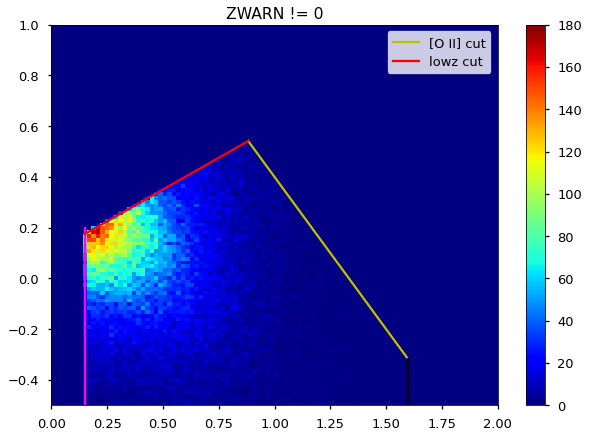

In [20]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_bad['r-z'], mag_bad['g-r'], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 180, vmin = 0);
plt.title("ZWARN != 0")
plt.colorbar()
fdr_plot()

##### Histogram of other bands

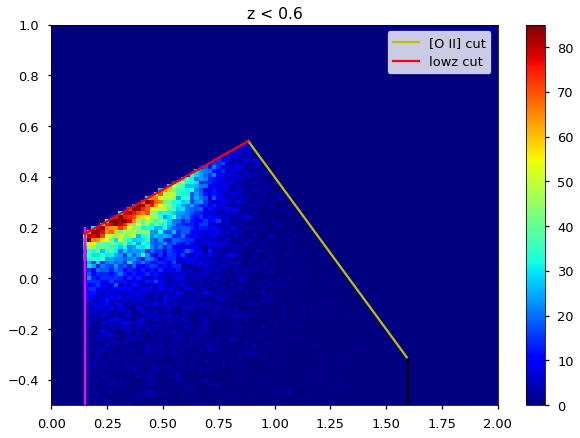

In [21]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][lowz_bad_bin], mag_good['g-r'][lowz_bad_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
           vmin = 0, vmax = 85);
plt.title("z < 0.6")
plt.colorbar()
fdr_plot()

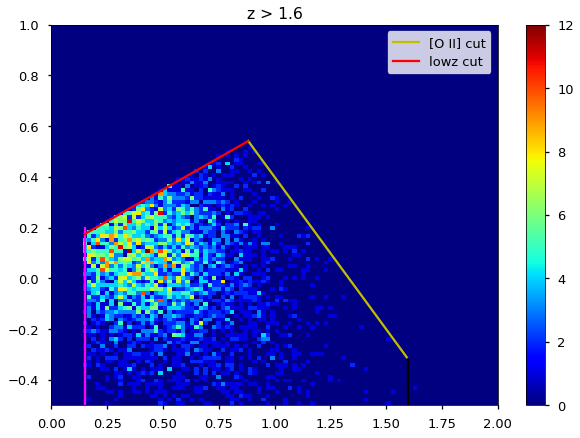

In [22]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][highz_bad_bin], mag_good['g-r'][highz_bad_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmin = 0);
plt.title("z > 1.6")
plt.colorbar()
fdr_plot()

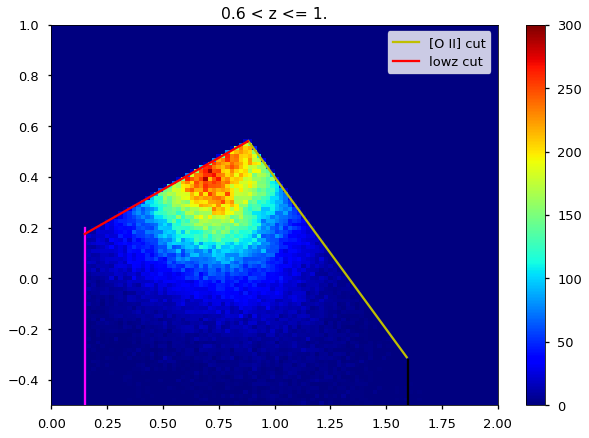

In [23]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][tomo_1_bin], mag_good['g-r'][tomo_1_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 300, vmin = 0);
plt.title("0.6 < z <= 1.")
plt.colorbar()
fdr_plot()

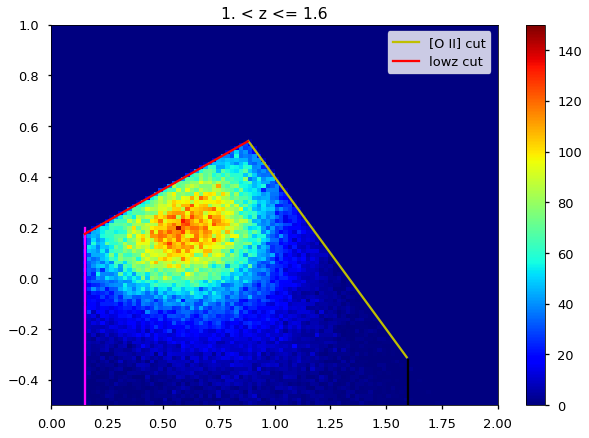

In [24]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][tomo_2_bin], mag_good['g-r'][tomo_2_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 150, vmin = 0);
plt.title("1. < z <= 1.6")
plt.colorbar()
fdr_plot()

##### Q: What redshift ELGs are at the bottom part of the plot?

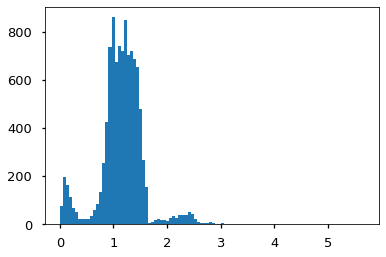

In [25]:
plt.hist(zcat_elg[(mag_good['g-r'] < -0.2) & (mag_good['g-r'] > -0.4)]['Z'], bins = 100);

## Additional colour-colour cuts to get a purer sample
- Based on the plots above, we can push the cuts around in a way that avoids the redshift-deficient, low-redshift interlopers and high-redshift interlopers.

In [26]:
#define cuts to test 

def starcut(intercept):
    lowz_x = np.arange(0.15, 4/9, .01)
    lowz_y = 0.5 * lowz_x + intercept
    
    return lowz_x, lowz_y
    
def oii(intercept):
    OIIx = np.arange(15/17, 1.6, .01)
    OIIy = -1.2 * OIIx + intercept
    
    return OIIx, OIIy

In [27]:
def circle_cut(r, h, k):
    theta = np.linspace( 0 , 2 * np.pi , 150 )
    
    x = r * np.cos(theta) + h
    y = r * np.sin(theta) + k
    
    return x, y

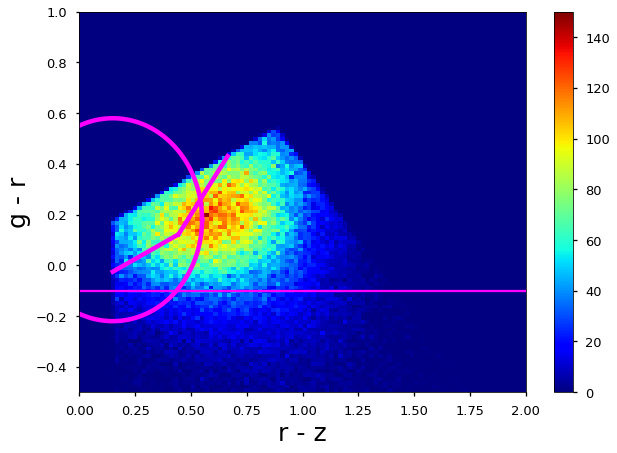

In [28]:
tmpx, tmpy = starcut(-.1)
tmpxx, tmpyy = circle_cut(.4, .15, .18)

plt.figure(figsize = (10, 7))
# plt.hist2d(mag_bad['r-z'], mag_bad['g-r'], 
#           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
#           vmax = 180);
# plt.hist2d(mag_good['r-z'][lowz_bad_bin], mag_good['g-r'][lowz_bad_bin], 
#            bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
#           vmax = 85);
plt.axhline(-0.1, c = 'magenta')
plt.plot(np.arange(4/9, 2/3, 0.01), np.arange(4/9, 2/3, 0.01) * 1.4 - 0.5, lw = 4.5, c = 'magenta')
plt.hist2d(mag_good['r-z'][tomo_2_bin], mag_good['g-r'][tomo_2_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 150);
plt.plot(tmpx, tmpy, c = 'magenta', lw = 4.5)
plt.plot(tmpxx, tmpyy, c = 'magenta', lw = 4.5)
#plt.title("ZWARN != 0")
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.colorbar()
plt.show()

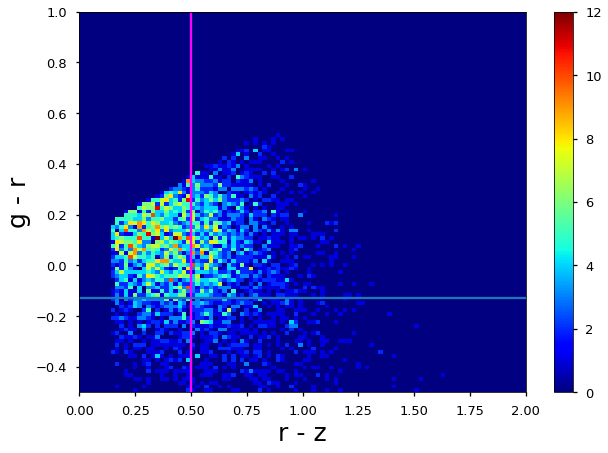

In [29]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][highz_bad_bin], mag_good['g-r'][highz_bad_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]]);
# plt.hist2d(rz[tomo_2_bin], gr[tomo_2_bin], 
#            bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]]);
plt.axvline(0.5, c = 'magenta')
plt.axhline(-.13)
plt.colorbar()
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.show()

### New cuts
Based on the loci of ZWARN != 0, z < 0.6 and z > 1.6, we draw boundaries that gets rid of them as much as possible.

In [30]:
#is_not_lowz = (rz > 0.5) | (gr < 0.5 * rz + 0.04) 
is_not_lowz = (mag_good['g-r'] < 0.5 * mag_good['r-z'] - 0.1) | (mag_good['g-r'] < 1.4 * mag_good['r-z'] - 0.5)
is_not_highz = (mag_good['r-z'] > 0.5) | (mag_good['g-r'] < -0.13) 
is_not_incomplete = (mag_good['g-r'] > -.5) & (mag_good['g-r'] < 1) & (mag_good['r-z'] < 1.25) & (mag_good['r-z'] > 0) #well behaved region
is_not_circle = ((mag_good['r-z'] - .15)**2 + (mag_good['g-r'] - .18)**2 > .4**2) | (mag_good['g-r'] < -.1)
#s_not_badz = is_not_lowz & is_not_highz & is_not_incomplete
is_not_badz = is_not_lowz & is_not_incomplete & is_not_circle

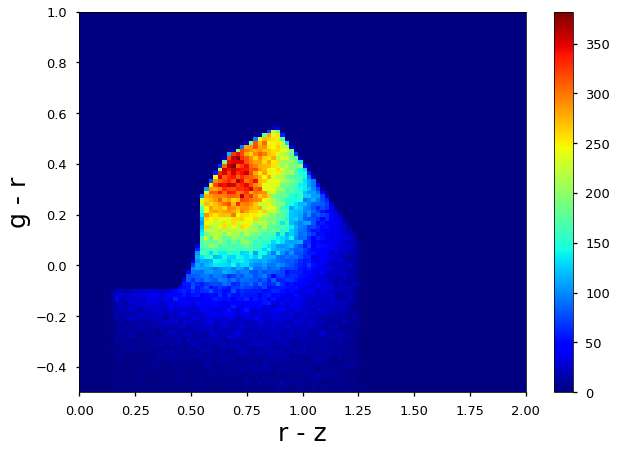

In [31]:
#remove low-z and bad redshift loci
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][is_not_badz], mag_good['g-r'][is_not_badz], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]]);
plt.colorbar()
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.show()

### Redshift distribution with the new color-color selection

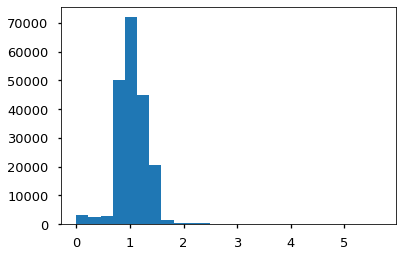

In [32]:
plt.hist(zcat_elg['Z'][is_not_badz], bins = 25);

In [33]:
print(f"Total frac of ELGs after colour selections: {np.sum(is_not_badz)/len(is_not_badz)}")

Total frac of ELGs after colour selections: 0.721337158067663


### Histogram of tomographic bins based on new color-color cut

#### ZWARN != 0

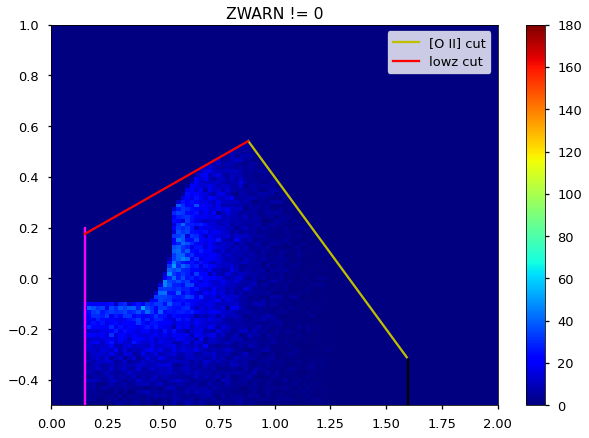

In [34]:
#selection for galaxies with ZWARN != 0 
# is_not_lowz2 = (rz_bad > .5) | (gr_bad < 0.5 * rz_bad + 0.05)  
# is_not_highz2 = (rz_bad > 0.50) | (gr_bad < -0.18) 
# is_not_badz2 = is_not_lowz2 & is_not_highz2

is_not_lowz2 = (mag_bad['g-r'] < 0.5 * mag_bad['r-z'] - 0.1) | (mag_bad['g-r'] < 1.4 * mag_bad['r-z'] - 0.5)
is_not_highz2 = (mag_bad['r-z'] > 0.5) | (mag_bad['g-r'] < -0.15) 
is_not_incomplete2 = (mag_bad['g-r'] > -.5) & (mag_bad['g-r'] < 1) & (mag_bad['r-z'] < 1.25) & (mag_bad['r-z'] > 0) #parts of the colour-colour space that do not have enough points

#is_badz = is_not_lowz2 & is_not_highz2 & is_not_incomplete2
is_not_circle2= ((mag_bad['r-z'] - .15)**2 + (mag_bad['g-r'] - .18)**2 > .4**2) | (mag_bad['g-r'] < -.1)
is_badz = is_not_lowz2 & is_not_incomplete2 & is_not_circle2

plt.figure(figsize = (10, 7))
plt.hist2d(mag_bad['r-z'][is_badz], mag_bad['g-r'][is_badz], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
           vmin = 0, vmax = 180);
plt.title("ZWARN != 0")
plt.colorbar()
fdr_plot()

In [35]:
print(f'Fraction of ELGs without redshift before new cut: {is_not_incomplete2.sum()/(is_not_incomplete2.sum() + is_not_incomplete.sum())}')
print(f'Fraction of ELGs without redshift after new cut: {is_badz.sum()/(is_badz.sum() + is_not_badz.sum())}')

Fraction of ELGs without redshift before new cut: 0.1775088357493506
Fraction of ELGs without redshift after new cut: 0.1090147595690833


In [36]:
(.1765 - .1079)/.1765

0.3886685552407932

#### Low redshift interlopers

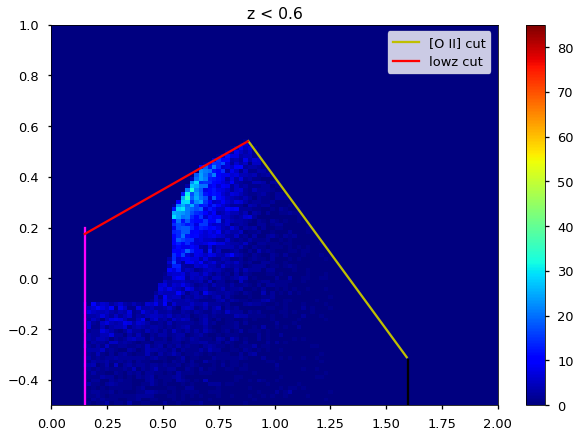

In [37]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][lowz_bad_bin & is_not_badz], mag_good['g-r'][lowz_bad_bin & is_not_badz], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
           vmin = 0, vmax = 85);
plt.title("z < 0.6")
plt.colorbar()
fdr_plot()

#### First Tomographic Bin

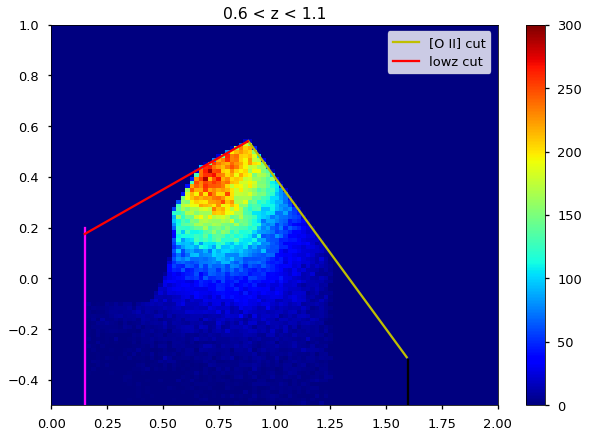

In [38]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][tomo_1_bin & is_not_badz], mag_good['g-r'][tomo_1_bin & is_not_badz], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 300);
plt.title("0.6 < z < 1.1")
plt.colorbar()
fdr_plot()

#### Second Tomographic Bin

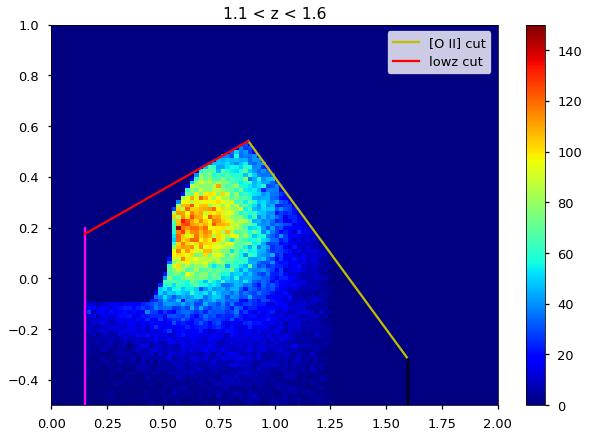

In [39]:
plt.figure(figsize = (10, 7))
plt.hist2d(mag_good['r-z'][tomo_2_bin & is_not_badz], mag_good['g-r'][tomo_2_bin & is_not_badz], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]],
          vmax = 150);
plt.title("1.1 < z < 1.6")
plt.colorbar()
fdr_plot()

### Where are the ZWARN == 0, $z<0.6$ and $z>1.6$ after the new cut?

In [40]:
plt.figure(figsize = (10, 7))
plt.scatter(rz[~is_not_lowz | ~is_not_highz], gr[~is_not_lowz | ~is_not_highz], 
           c = zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], cmap = plt.cm.jet, vmax = 1.6, vmin = 0);
plt.title("1.1 < z < 1.6")
plt.colorbar()
fdr_plot()

NameError: name 'rz' is not defined

<Figure size 720x504 with 0 Axes>

In [ ]:
plt.hist(zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], bins = 100);
plt.title("Bad pixels")

/tmp/ipykernel_62972/2766652883.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], rz[~is_not_lowz | ~is_not_highz], bins = 100, range=[[0,3],[0.15,0.7]]);


Text(0, 0.5, 'r-z')

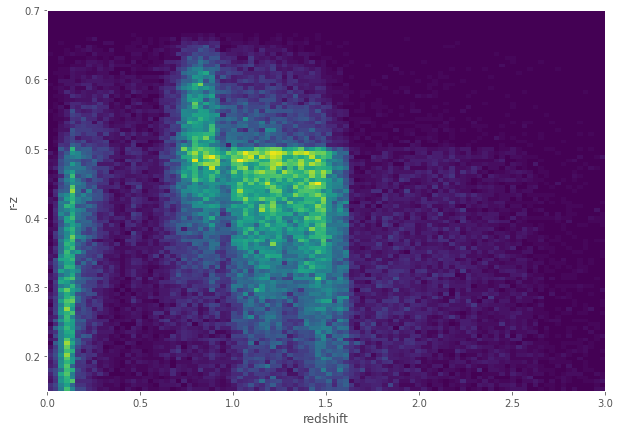

In [38]:
plt.figure(figsize = (10, 7))
plt.hist2d(zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], rz[~is_not_lowz | ~is_not_highz], bins = 100, range=[[0,3],[0.15,0.7]]);
plt.xlabel("redshift")
plt.ylabel("r-z")

/tmp/ipykernel_62972/1649645139.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(gr[~is_not_lowz | ~is_not_highz],zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], bins = 100, range=[[-.15,0.4],[0,2.5]]);


Text(0.5, 0, 'g-r')

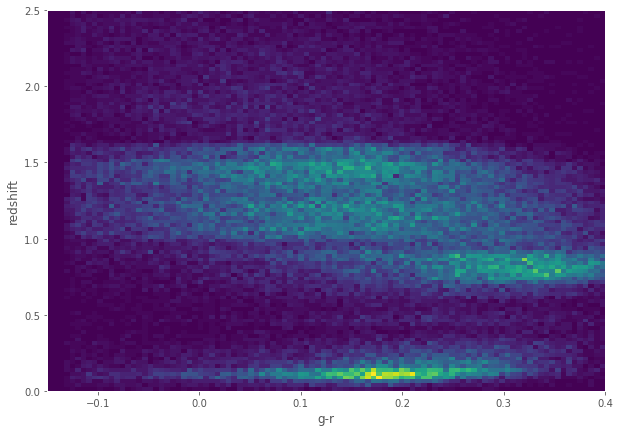

In [39]:
plt.figure(figsize = (10, 7))
plt.hist2d(gr[~is_not_lowz | ~is_not_highz],zcat_elg[~is_not_lowz | ~is_not_highz]['Z'], bins = 100, range=[[-.15,0.4],[0,2.5]]);
plt.ylabel("redshift")
plt.xlabel("g-r")

ZWARN != 0 galaxies in the cut out region

Text(0.5, 1.0, 'Bad pixels')

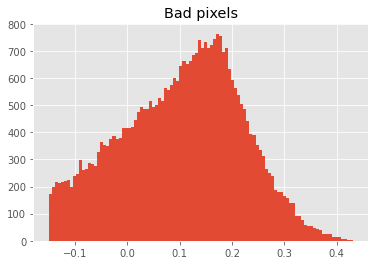

In [40]:
plt.hist(gr_bad[~is_not_lowz2 | ~is_not_highz2], bins = 100);
plt.title("Bad pixels")

Text(0.5, 1.0, 'Bad pixels')

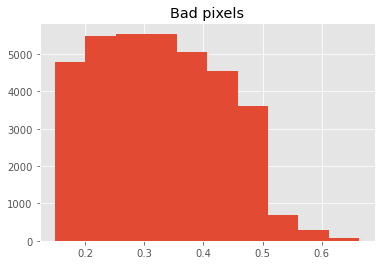

In [41]:
plt.hist(rz_bad[~is_not_lowz2 | ~is_not_highz2]);
plt.title("Bad pixels")

ZWARN != 0 in the new selected region

Text(0.5, 1.0, 'Good pixels')

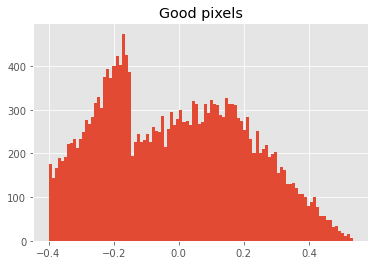

In [42]:
plt.hist(gr_bad[is_not_badz2], bins = 100);
plt.title("Good pixels")

Text(0.5, 1.0, 'Good pixels')

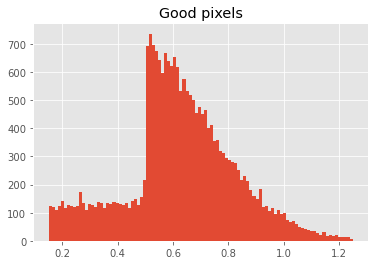

In [43]:
plt.hist(rz_bad[is_not_badz2], bins = 100);
plt.title("Good pixels")

/tmp/ipykernel_62972/4117412054.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(rz[is_not_badz], zcat_elg[is_not_badz]['Z'], bins = 100, range=[[0.5,1.2],[0,2]]);


Text(0.5, 1.0, 'Good pixels')

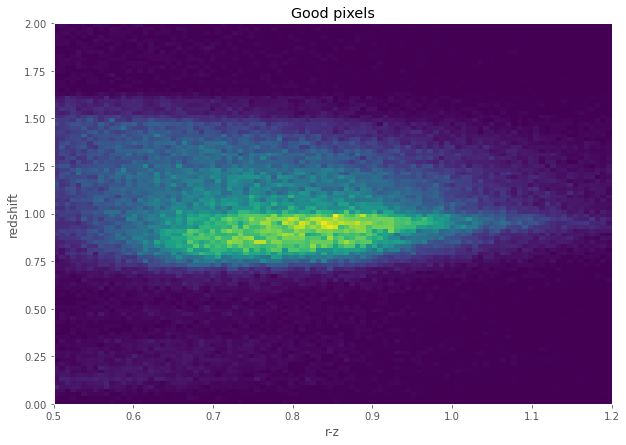

In [44]:
plt.figure(figsize = (10, 7))
plt.hist2d(rz[is_not_badz], zcat_elg[is_not_badz]['Z'], bins = 100, range=[[0.5,1.2],[0,2]]);
plt.ylabel("redshift")
plt.xlabel("r-z")
plt.title("Good pixels")

/tmp/ipykernel_62972/1998700672.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(gr[is_not_badz], zcat_elg[is_not_badz]['Z'], bins = 100, range=[[-0.15,0.5],[0,2]]);


Text(0.5, 1.0, 'Good pixels')

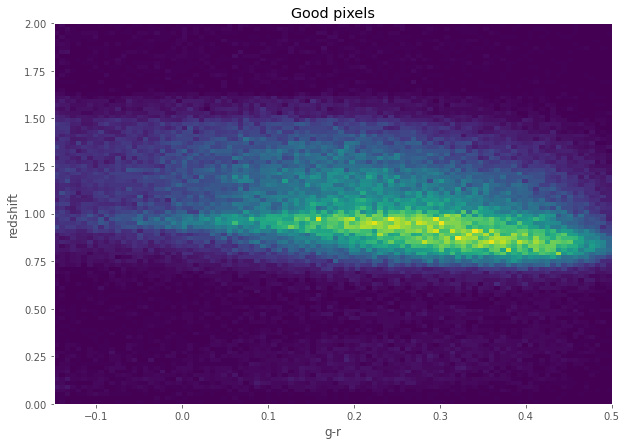

In [45]:
plt.figure(figsize = (10, 7))
plt.hist2d(gr[is_not_badz], zcat_elg[is_not_badz]['Z'], bins = 100, range=[[-0.15,0.5],[0,2]]);
plt.ylabel("redshift")
plt.xlabel("g-r")
plt.title("Good pixels")

In the bad region, what fraction are bad redshifts?

In [46]:
len(rz_bad[~is_not_lowz2 | ~is_not_highz2])/(len(rz_bad[~is_not_lowz2 | ~is_not_highz2]) + len(rz[~is_not_lowz | ~is_not_highz]))

0.3108248457396207

/tmp/ipykernel_51753/284799484.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(rz[(zcat_elg['Z'] < 0.8) & is_not_badz], gr[(zcat_elg['Z'] < 0.8) & is_not_badz], bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]] );


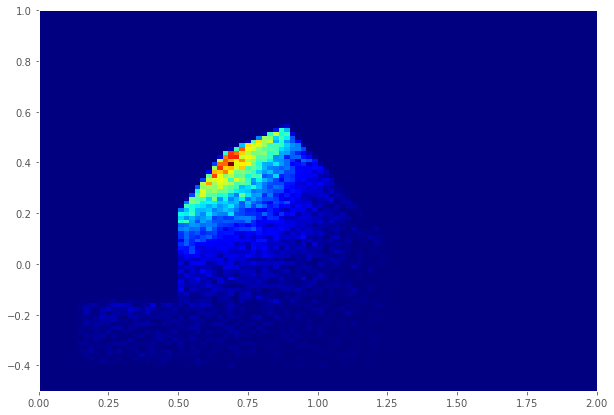

In [36]:
plt.figure(figsize = (10,7))
plt.hist2d(rz[(zcat_elg['Z'] < 0.8) & is_not_badz], gr[(zcat_elg['Z'] < 0.8) & is_not_badz], bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]] );

/tmp/ipykernel_51753/3299392566.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(rz[(zcat_elg['Z'] > 1.2) & is_not_badz], gr[(zcat_elg['Z'] > 1.2) & is_not_badz], bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]] );


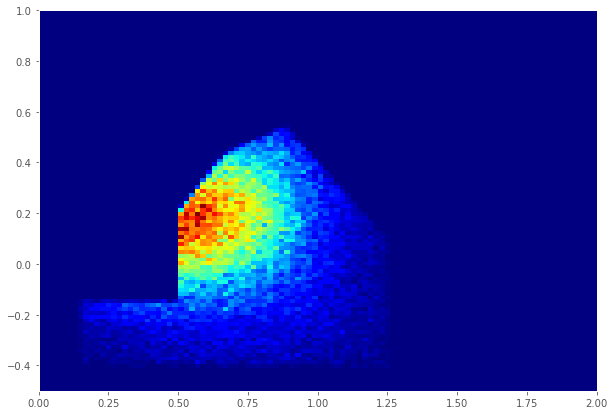

In [37]:
plt.figure(figsize = (10,7))
plt.hist2d(rz[(zcat_elg['Z'] > 1.2) & is_not_badz], gr[(zcat_elg['Z'] > 1.2) & is_not_badz], bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]] );

# Classification of the tomographic bins with `sklearn`

In [44]:
from sklearn.metrics import accuracy_score, roc_curve, plot_confusion_matrix, confusion_matrix, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Full sample with 2 labels
In this training, we do not make any colour cuts and use an additional label for bad pixels

In [71]:
zcat_elg['gfib'].min()

20.270901076160325

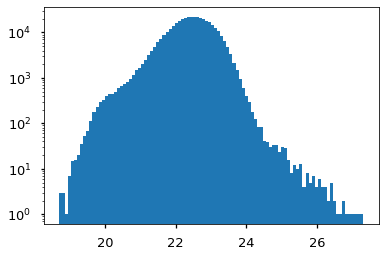

In [173]:
plt.hist(zcat_elg['MAG_Z'], bins = 100);
#plt.axvline(22.1, c = 'k')
#plt.axvline(0.1, c = 'k')
plt.yscale("log")

In [45]:
#only focus on region of interest in the colour-colour space
is_not_incomplete = (zcat_elg['g-r'] > -.4) & (zcat_elg['g-r'] < .5) & (zcat_elg['r-z'] < 1.25) & (zcat_elg['r-z'] > 0.1) & \
(zcat_elg['SHAPE_R'] < 1.5) & (zcat_elg['gfib'] >= 22.4) & (zcat_elg['zfib'] <= 25.5) & \
(zcat_elg['rfib'] <= 27.5) & (zcat_elg['MAG_R'] <= 27) & (zcat_elg['MAG_Z'] <= 25) #parts of the colour-colour space that do not have enough points
#is_not_incomplete2 = (mag_bad['g-r'] > -.5) & (mag_bad['g-r'] < .6) & (mag_bad['r-z'] < 1.25) & (mag_bad['r-z'] > 0) 

cond = is_not_incomplete & (~misc_bad_bin)
cond_bad = is_not_incomplete & misc_bad_bin

In [46]:
print(f"good: {cond.sum()}")
print(f"total: {(len(cond))}")
print(f"bad: {(cond_bad).sum()} and %: {(cond_bad).sum()/(len(cond)) * 100}")

good: 278767
total: 390445
bad: 79550 and %: 20.374188426026713


In [47]:
np.count_nonzero(cond==cond_bad)

32128

In [48]:
np.sum(cond[np.where(cond == cond_bad)])

0

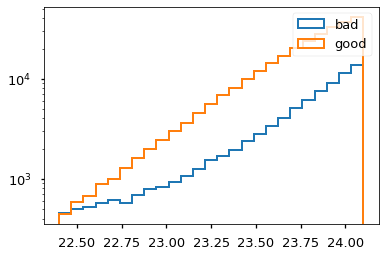

In [76]:
plt.hist(zcat_elg[cond_bad]['gfib'], histtype= 'step', lw = 2, bins = 25,
         density = False, label = 'bad')
plt.hist(zcat_elg[cond]['gfib'], histtype= 'step', lw = 2, bins = 25, density = False, label = 'good')
plt.legend(loc = 'best')
plt.yscale("log")

The overlaps between `cond` and `cond_bad` are only in `False` values. Since this implies they won't be counted into our sample, we do not care 

### Plot of the footprint
To be used in paper to show SV3 footprint

In [49]:
tmpdata = zcat_elg[cond | cond_bad] 
tmpdata.columns

<TableColumns names=('TARGETID','HEALPIX','SPGRPVAL','Z','ZERR','ZWARN','CHI2','COEFF','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','SV3_DESI_TARGET','SV3_BGS_TARGET','SV3_MWS_TARGET','SV3_SCND_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','PLATE_RA','PLATE_DEC','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','ME

Now we find the appropriate rosette numbers of the corresponding ELGs so that we may use this information for training purposes. In SV3 fuji, there are 20 tiles for ELGs. Our strategy is to use $80\% = 16$ of the tiles for training and the rest $4$ for testing. Because ${20 \choose 4} = 4845$, we can easily come up with that many unique dndz to get an estimation of dndz uncertainty. For the preliminary purposes, we will run this $100$ times. 

In [50]:
tmptmp = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/3.1/ELG_full_noveto.dat.fits')

is_in_lss_cat = match_to(tmptmp[1].data['TARGETID'], tmpdata['TARGETID'])
lss_elg = tmptmp[1].data[is_in_lss_cat]

We have to remove targets that do not match in the lss catalogue. 

In [51]:
len(tmpdata) - len(lss_elg)

4

In [52]:
tid_del = []
for tid in np.setdiff1d(tmpdata['TARGETID'], lss_elg['TARGETID']):
    tid_del.append(np.where(tmpdata['TARGETID'] == tid)[0][0])
    
tid_del = np.array(tid_del)
tmpdata.remove_rows(tid_del)

In [53]:
len(tmpdata)

358313

In [54]:
len(lss_elg)

358313

Verify that the rows match 

In [55]:
(tmpdata['TARGETID'] == lss_elg['TARGETID']).sum()

358313

Pass rosette number information from lss catalogue to our analysis catalogue. 

In [56]:
tmpdata['rosette_number'] = lss_elg['rosette_number']

In [57]:
import healpy as hp 

def radec2hpix(nside, ra, dec):
    """ 
    Function transforms RA,DEC to HEALPix index in ring ordering
    
    parameters
    ----------
    nside : int
    
    ra : array_like
        right ascention in deg
    
    dec : array_like
        declination in deg
    
    
    returns
    -------
    hpix : array_like
        HEALPix indices
    
    """
    hpix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    return hpix

def hpixsum(nside, ra, dec, weights=None):
    """
    Aggregates ra and dec onto HEALPix with nside and ring ordering.
    credit: Yu Feng, Ellie Kitanidis, ImagingLSS, UC Berkeley
    parameters
    ----------
    nside: int
    
    ra: array_like
        right ascention in degree.
    dec: array_like
        declination in degree.
    returns
    -------
    weight_hp: array_like
            
    """
    hpix = radec2hpix(nside, ra, dec)
    npix = hp.nside2npix(nside)
    weight_hp = np.bincount(hpix, weights=weights, minlength=npix)
    return weight_hp

### Footprint

In [59]:
footprint = hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)

/tmp/ipykernel_24696/1024485808.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  footprint = hpixsum(nside = 512, ra = np.array(tmpdata['TARGET_RA']), dec = np.array(tmpdata['TARGET_DEC'])).astype(np.float)


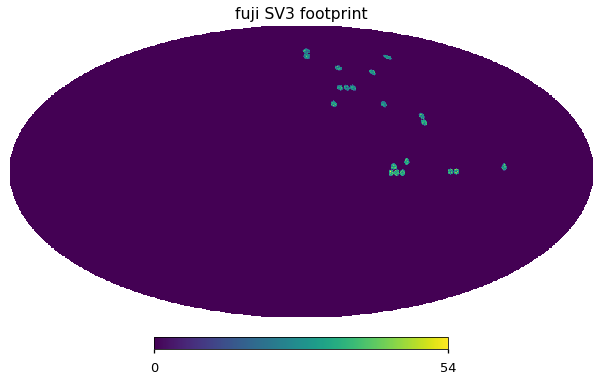

In [60]:
hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'fuji SV3 footprint')
#plt.savefig("../plots/sv3_footprint.pdf", dpi = 400, bbox_inches = 'tight')

### Test 4: What is the distribution of `SHAPE_R` as a function of redshift?

(array([1.6000e+01, 3.2760e+03, 4.6986e+04, 5.2067e+04, 3.4684e+04,
        2.1167e+04, 1.3146e+04, 8.4190e+03, 5.5950e+03, 3.8670e+03,
        2.7620e+03, 1.9910e+03, 1.4380e+03, 1.0440e+03, 7.0600e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 <BarContainer object of 19 artists>)

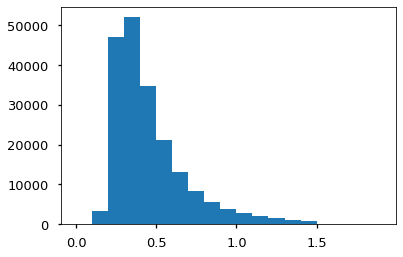

In [100]:
plt.hist(zcat_elg['SHAPE_R'][cond][zcat_elg['SHAPE_R'][cond] > 0], bins = np.arange(0, 2, 0.1))

What does SHAPE_R == 0 mean?

Text(0, 0.5, 'SHAPE_R')

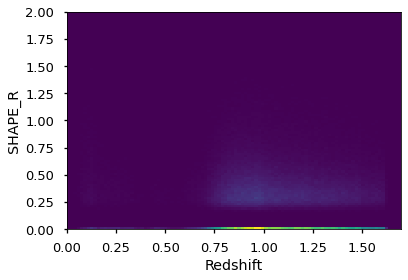

In [93]:
plt.hist2d(zcat_elg['Z'][cond], zcat_elg['SHAPE_R'][cond], 
           range = np.array([[0, 1.7], [0, 2]]), bins = 100);
plt.xlabel("Redshift")
plt.ylabel("SHAPE_R")

### Create training set

In [61]:
zcat_elg_complete = tmpdata[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 
                             'SPECTYPE', 'rosette_number', 'SHAPE_R', "MAG_G", "MAG_R", "MAG_Z", 
                             'g-r', 'r-z', 'gfib', 'rfib', 'zfib', 'Z', 'bin_label']]
#zcat_elg_complete['label'] = bin_cat[cond | cond_bad].astype(np.int64)

In [62]:
len(zcat_elg_complete)

358313

In [63]:
len(np.unique(np.array(zcat_elg_complete['TARGETID'])))

358313

In [64]:
df = zcat_elg_complete.to_pandas()
df = df.sample(frac = 1, replace = False, random_state = 45)
df = df.reset_index(drop = True)
df.head()

TARGETID   TARGET_RA  TARGET_DEC   SPECTYPE  rosette_number  \
0  39627848796866087  218.822388    2.605528  b'GALAXY'            10.0   
1  39628384589840559  194.662651   25.592893  b'GALAXY'            16.0   
2  39632946797217271  253.527872   33.291543  b'GALAXY'            14.0   
3  39633136434286068  235.753426   43.363868  b'GALAXY'            19.0   
4  39627781675417906  178.012754   -0.340894  b'GALAXY'             1.0   

    SHAPE_R      MAG_G      MAG_R      MAG_Z       g-r       r-z       gfib  \
0  0.176790  23.668826  23.612541  22.482231  0.056284  1.130311  24.014508   
1  0.000000  22.766482  22.582109  22.019256  0.184374  0.562853  23.038178   
2  0.000000  23.506282  23.663682  23.393062 -0.157400  0.270620  23.779713   
3  0.000000  22.540227  22.444829  21.923684  0.095397  0.521146  22.813928   
4  0.378707  23.208764  23.125669  22.574187  0.083095  0.551482  23.773104   

        rfib       zfib         Z  bin_label  
0  23.958223  22.827913  1.088039          1  
1  22.853805  22.290952  1.112025          1  
2  23.937113  23.666493  1.049998          1  
3  22.718531  22.197385  1.125659          1  
4  23.690008  23.138526  0.957281          1

In [65]:
df['Z']

5.953989547733417

In [66]:
df.loc[(df.bin_label == 2), 'Z'] = -99 #set all bad redshifts to -99 to distinguish

In [67]:
df['Z'].max()

1.6198079210989067

In [76]:
# #build dataframe

# #convert band magnitude to proper unirandom_state=ag_dict = {}
# mag_dict['g'] = np.concatenate((zcat_elg['MAG_G'][cond], zcat_elg['MAG_G'][cond_bad])) #combine both ZWARN == 0 and != 0
# mag_dict['r'] = np.concatenate((zcat_elg['MAG_R'][cond], zcat_elg['MAG_R'][cond_bad]))
# mag_dict['z'] = np.concatenate((zcat_elg['MAG_Z'][cond], zcat_elg['MAG_Z'][cond_bad]))
# mag_dict['gr'] = np.concatenate((zcat_elg['g-r'][cond], zcat_elg['g-r'][cond_bad]))
# mag_dict['rz'] = np.concatenate((zcat_elg['r-z'][cond], zcat_elg['r-z'][cond_bad]))
# mag_dict['shape_r'] = np.concatenate((zcat_elg['SHAPE_R'][cond], zcat_elg['SHAPE_R'][cond_bad]))
# mag_dict['gfib'] = np.concatenate((zcat_elg['gfib'][cond], zcat_elg['gfib'][cond_bad]))
# mag_dict['rfib'] = np.concatenate((zcat_elg['rfib'][cond], zcat_elg['rfib'][cond_bad]))
# mag_dict['zfib'] = np.concatenate((zcat_elg['zfib'][cond], zcat_elg['zfib'][cond_bad]))
# mag_dict['TARGETID'] = np.concatenate((zcat_elg['TARGETID'][cond], zcat_elg['TARGETID'][cond_bad]))
# mag_dict['SPECTYPE'] = np.concatenate((zcat_elg['SPECTYPE'][cond], zcat_elg['SPECTYPE'][cond_bad]))
# mag_dict['specz'] = np.concatenate((np.array(zcat_elg['Z'][cond]), -99*np.ones_like(zcat_elg['Z'][cond_bad])))
# mag_dict['label'] = np.concatenate((bin_cat[cond], bin_cat[cond_bad]))

# #mag_dict['g'] = np.concatenate((zcat_elg['MAG_G'][cond], ))
# #mag_dict['r'] = zcat_elg['MAG_R'][cond]
# #mag_dict['z'] = zcat_elg['MAG_Z'][cond]
# #mag_dict['gr'] = zcat_elg['g-r'][cond]
# #mag_dict['rz'] = zcat_elg['r-z'][cond]
# #mag_dict['shape_r']
# #mag_dict['specz'] = np.concatenate((zcat_elg['Z'][cond], -99*np.ones_like(zcat_elg['Z'][~cond])))
# #mag_dict['label'] = zcat_elg['bin_label'][cond]


# data_array = np.array([mag_dict['rz'], mag_dict['gr'], mag_dict['g'], mag_dict['r'],
#                        mag_dict['z'], mag_dict['shape_r'], mag_dict['gfib'], mag_dict['rfib'], mag_dict['zfib'],
#                        mag_dict['TARGETID'], 
#                        mag_dict['SPECTYPE'].astype(str), mag_dict['specz'], mag_dict['label'].astype(int)])
# df = pd.DataFrame(data_array.T, columns = ['r-z','g-r', 'g', 'r', 'z', 'shape_r', 'gfib', 'rfib', 'zfib',
#                                            'targetid', 'spectype',
#                                            'specz', 'redz_bin'])

# df = df.sample(frac=1)

# print(df)

In [75]:
df.groupby('bin_label').count()#/df.groupby('bin_label').count()['r-z'].sum()

TARGETID  TARGET_RA  TARGET_DEC  SPECTYPE  rosette_number  SHAPE_R  \
bin_label                                                                       
0             15052      15052       15052     15052           15052    15052   
1            263712     263712      263712    263712          263712   263712   
2             79549      79549       79549     79549           79549    79549   

            MAG_G   MAG_R   MAG_Z     g-r     r-z    gfib    rfib    zfib  \
bin_label                                                                   
0           15052   15052   15052   15052   15052   15052   15052   15052   
1          263712  263712  263712  263712  263712  263712  263712  263712   
2           79549   79549   79549   79549   79549   79549   79549   79549   

                Z  
bin_label          
0           15052  
1          263712  
2           79549

In [76]:
df.groupby('rosette_number').count()#/df.groupby('bin_label').count()['r-z'].sum()

TARGETID  TARGET_RA  TARGET_DEC  SPECTYPE  SHAPE_R  MAG_G  \
rosette_number                                                              
0.0                18622      18622       18622     18622    18622  18622   
1.0                19076      19076       19076     19076    19076  19076   
2.0                18828      18828       18828     18828    18828  18828   
3.0                16733      16733       16733     16733    16733  16733   
4.0                17016      17016       17016     17016    17016  17016   
5.0                19689      19689       19689     19689    19689  19689   
6.0                17073      17073       17073     17073    17073  17073   
7.0                17131      17131       17131     17131    17131  17131   
8.0                19928      19928       19928     19928    19928  19928   
9.0                20484      20484       20484     20484    20484  20484   
10.0               19342      19342       19342     19342    19342  19342   
11.0               17035      17035       17035     17035    17035  17035   
12.0               16355      16355       16355     16355    16355  16355   
13.0               16769      16769       16769     16769    16769  16769   
14.0               18045      18045       18045     18045    18045  18045   
15.0               15926      15926       15926     15926    15926  15926   
16.0               18140      18140       18140     18140    18140  18140   
17.0               20286      20286       20286     20286    20286  20286   
18.0               15676      15676       15676     15676    15676  15676   
19.0               16159      16159       16159     16159    16159  16159   

                MAG_R  MAG_Z    g-r    r-z   gfib   rfib   zfib      Z  \
rosette_number                                                           
0.0             18622  18622  18622  18622  18622  18622  18622  18622   
1.0             19076  19076  19076  19076  19076  19076  19076  19076   
2.0             18828  18828  18828  18828  18828  18828  18828  18828   
3.0             16733  16733  16733  16733  16733  16733  16733  16733   
4.0             17016  17016  17016  17016  17016  17016  17016  17016   
5.0             19689  19689  19689  19689  19689  19689  19689  19689   
6.0             17073  17073  17073  17073  17073  17073  17073  17073   
7.0             17131  17131  17131  17131  17131  17131  17131  17131   
8.0             19928  19928  19928  19928  19928  19928  19928  19928   
9.0             20484  20484  20484  20484  20484  20484  20484  20484   
10.0            19342  19342  19342  19342  19342  19342  19342  19342   
11.0            17035  17035  17035  17035  17035  17035  17035  17035   
12.0            16355  16355  16355  16355  16355  16355  16355  16355   
13.0            16769  16769  16769  16769  16769  16769  16769  16769   
14.0            18045  18045  18045  18045  18045  18045  18045  18045   
15.0            15926  15926  15926  15926  15926  15926  15926  15926   
16.0            18140  18140  18140  18140  18140  18140  18140  18140   
17.0            20286  20286  20286  20286  20286  20286  20286  20286   
18.0            15676  15676  15676  15676  15676  15676  15676  15676   
19.0            16159  16159  16159  16159  16159  16159  16159  16159   

                bin_label  
rosette_number             
0.0                 18622  
1.0                 19076  
2.0                 18828  
3.0                 16733  
4.0                 17016  
5.0                 19689  
6.0                 17073  
7.0                 17131  
8.0                 19928  
9.0                 20484  
10.0                19342  
11.0                17035  
12.0                16355  
13.0                16769  
14.0                18045  
15.0                15926  
16.0                18140  
17.0                20286  
18.0                15676  
19.0                16159

In [77]:
df.to_pickle("../dat/specz-good-data-df-single-tomo-classifier.pkl")

In [78]:
df.to_csv("../dat/specz-good-data-df-binary-classifier.csv")

### Standardize the dataset

In [79]:
df = pd.read_pickle("../dat/specz-good-data-df-single-tomo-classifier.pkl")

### split rosette into equal areas 

In [80]:
#split using mean of DEC 
tmptransformed = df.groupby("rosette_number").TARGET_DEC.transform(lambda x : x > x.mean()) 
df['half_rosetteID'] = 2*df.rosette_number + tmptransformed

In [81]:
df.columns

Index(['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'SPECTYPE', 'rosette_number',
       'SHAPE_R', 'MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib',
       'zfib', 'Z', 'bin_label', 'half_rosetteID'],
      dtype='object')

In [82]:
#reorder 
df = df[['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'SPECTYPE', 'rosette_number', 'half_rosetteID', 
         'SHAPE_R', 'MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib', 
         'zfib', 'Z', 'bin_label']]

In [83]:
df.to_pickle("../dat/specz-good-data-df-single-tomo-classifier.pkl")

In [84]:
df = pd.read_pickle("../dat/specz-good-data-df-single-tomo-classifier.pkl")

#### check whether split worked
We take the first half of `rosette_number == 0` and then the second half, plotting them on the sky. We also overlay the mean DEC of the same rosette number and see if it is in the middle. 

In [85]:
tmpdf0 = df[df['half_rosetteID'] == 0]
tmpdf1 = df[df['half_rosetteID'] == 1]
tmpdecmean = df.groupby("rosette_number")['TARGET_DEC'].mean()[0]

Text(0, 0.5, 'RA')

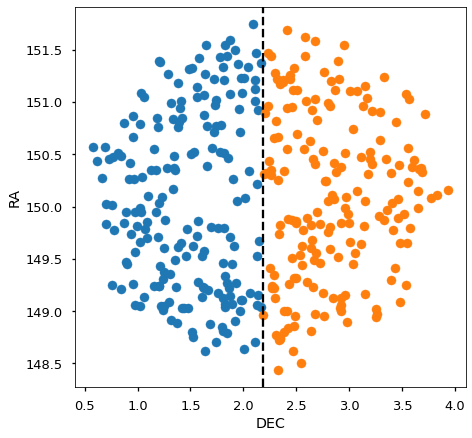

In [86]:
plt.figure(figsize=(7,7))
sample_rate = 50
plt.scatter(tmpdf0['TARGET_DEC'][::sample_rate], tmpdf0['TARGET_RA'][::sample_rate])
plt.scatter(tmpdf1['TARGET_DEC'][::sample_rate], tmpdf1['TARGET_RA'][::sample_rate])
plt.axvline(tmpdecmean, ls = '--', c = 'k')
plt.xlabel("DEC")
plt.ylabel("RA")

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle

#replace = True

#split into features and classes
X, y = df.drop(["bin_label"], axis=1), df["bin_label"].values

# per_cat_num =np.array([10000, 100000, 125000, 60000]) #number of objects to include per category

# # Create balanced training / test data set using undersampled majority class records
# X_sampled0, y_sampled0 = resample(X[y == 0], y[y == 0],
#                 replace=replace,
#                 n_samples=per_cat_num[0])

# X_sampled1, y_sampled1 = resample(X[y == 1], y[y == 1],
#                 replace=replace,
#                 n_samples=per_cat_num[1])

# X_sampled2, y_sampled2 = resample(X[y == 2], y[y == 2],
#                 replace=replace,
#                 n_samples=per_cat_num[2])

# X_sampled3, y_sampled3 = resample(X[y == 3], y[y == 3],
#                 replace=replace,
#                 n_samples=per_cat_num[3])

# X_sampled4, y_sampled4 = resample(X[y == 4], y[y == 4],
#                 replace=replace,
#                 n_samples=per_cat_num[4])

#combine
# X_sampled = np.vstack((X_sampled0, X_sampled1, X_sampled2, X_sampled3))#, X_sampled4))
# y_balanced = np.hstack((y_sampled0, y_sampled1, y_sampled2, y_sampled3))#, y_sampled4))

#scale features
sc = StandardScaler()
#X_balanced = sc.fit_transform(X[:, [0, 1, 2, 3, 4, 6, 7, 8]]) #drop the specz column for training, but keep it in X_sampled for plotting dndz
X_transformed = sc.fit_transform(X.iloc[:,7:-1])
X_transformed =  np.hstack((np.array(X.iloc[:,:7]), X_transformed)) #concatenate identifying information

# Create train/test sets
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, np.arange(0, len(X_transformed)), #last element is to track indices
#                                                                                  test_size=0.20, shuffle=True,
#                                                                                  stratify=y)

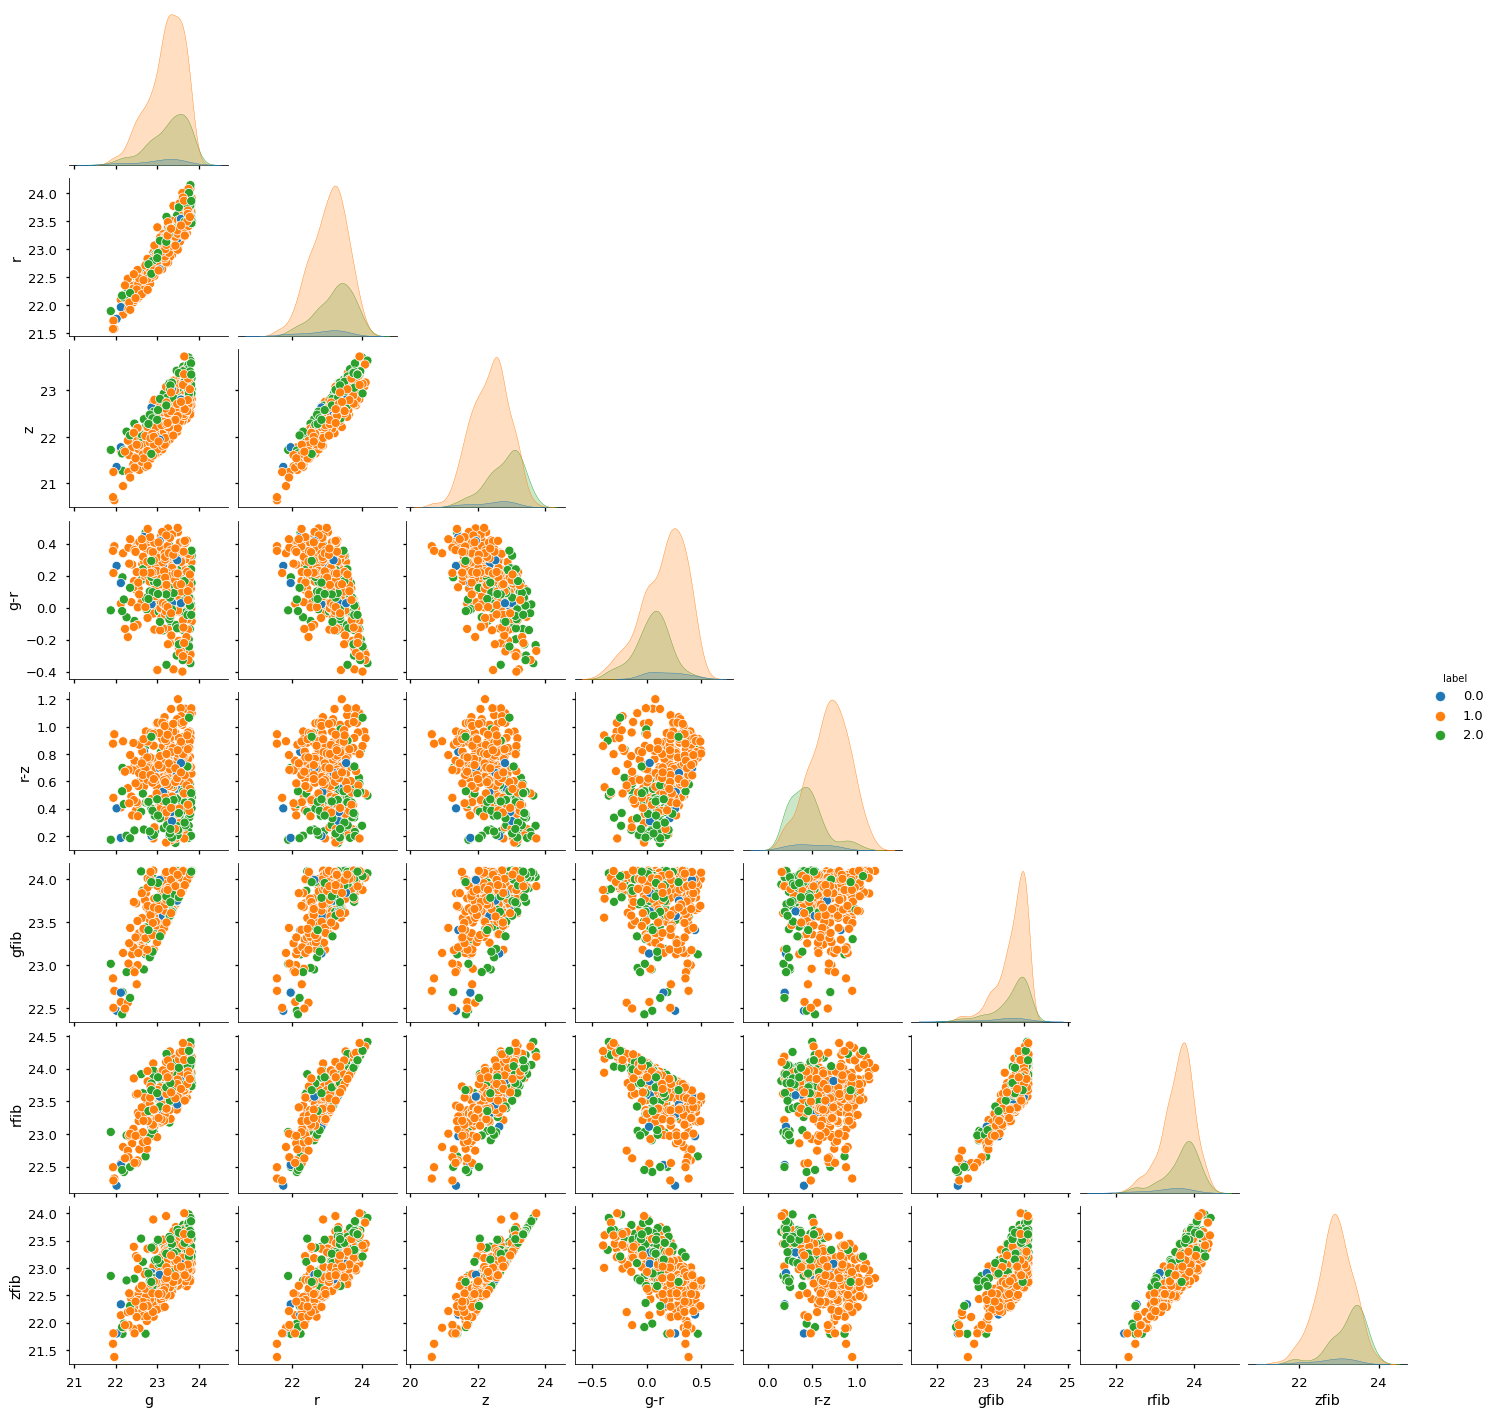

In [51]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.hstack((np.array(X.iloc[::1000,6:-1]), y[::1000].reshape(-1,1))), columns=['g','r','z', 'g-r', 'r-z', 
                                                                              'gfib', 'rfib', 'zfib', 'label']), 
             hue = 'label', palette="tab10", corner = True)

#### Randomly select rosettes for train and test
We want to split the rosettes into $16$ training and $4$ test tiles. We will use the principle of bootstrapping that has a better statistical behaviour than jackknifing. Our procedure is as follows:
- Split indices from 0 - 19 into sub-samples without replacement of test and training sets. We make this split at the beginning before boostrapping to ensure that the training and test rosettes are unique. 
- Next we sample the training and test indices sub-samples with the same size. This step is the boostrap step where we uniformly sample with replacement potential training and test rosettes. 
- This procedure is repeated $1000$ times to get a statistical distribution of the dndz. 

In [52]:
# #use a generator function to get unique permutations based on
# ##https://stackoverflow.com/questions/54050322/random-sample-of-n-distinct-permutations-of-a-list##

# import random

# k = 20
# n = 10

# mylist = list(range(0, k))

# def perm_generator(seq):
#     seen = set()
#     length = len(seq)
#     while True:
#         perm = tuple(random.sample(seq, length))
#         if perm not in seen:
#             seen.add(perm)
#             yield perm

# rand_perms = perm_generator(mylist)

# j = [next(rand_perms) for _ in range(n)]

# j = np.array(j)

In [88]:
# define indices range and size of the sub-samples
idxrange = np.arange(20*2)
tst_sz = 4*2
trn_sz = 16*2

In [89]:
# split indices without replacement into train and test sub-samples.
rng = np.random.default_rng(202305)
tmp_tst_rosetteID = rng.choice(idxrange, tst_sz, replace = False)
tmp_trn_rosetteID = np.setxor1d(idxrange, tmp_tst_rosetteID)
print(tmp_tst_rosetteID)
print(tmp_trn_rosetteID)

# within sub-samples, bootstrap indices of the rosettes with replacement. This is the boostrap step. 
# tmp_trn_rosetteID = rng.choice(tmp_trn_rosetteID, size = trn_sz, replace = True)
# tmp_tst_rosetteID = rng.choice(tmp_tst_rosetteID, size = tst_sz, replace = True)
# print(tmp_trn_rosetteID)
# print(tmp_tst_rosetteID)

[34 38 30 23  6 17 32  4]
[ 0  1  2  3  5  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25 26 27
 28 29 31 33 35 36 37 39]


In [90]:
#%%timeit 
# identify indices of test and training sets
indices_trn = []
indices_tst = []

for ii in range(len(tmp_trn_rosetteID)):
    indices_trn.append(np.where(X_transformed[:,5] == tmp_trn_rosetteID[ii])[0])
    
for ii in range(len(tmp_tst_rosetteID)):
    indices_tst.append(np.where(X_transformed[:,5] == tmp_tst_rosetteID[ii])[0])
    
#turn into numpy array
indices_trn = np.concatenate(indices_trn)
indices_tst = np.concatenate(indices_tst)

#shuffle indices
rng.shuffle(indices_trn)
rng.shuffle(indices_tst)

In [91]:
# stats of train to test ratio
print(len(indices_tst)/(len(indices_trn) + len(indices_tst)))

0.20004297918300482


In [92]:
# sub-sample the indices to sub-sample at the data level rather than rosette level 
# indices_trn = rng.choice(indices_trn, size = len(indices_trn), replace = True)
# indices_tst = rng.choice(indices_tst, size = len(indices_tst), replace = True)

In [93]:
# splice training and test sets
X_trn = X_transformed[indices_trn, :]
X_tst = X_transformed[indices_tst, :]

y_trn = y[indices_trn]
y_tst = y[indices_tst]

Verify that indeed bootstrapping worked as intended

We notice that in the test set there are two unique rosettes. We plot the footprint of the test set and indeed notice only two rosettes plotted, verifying our method.

/tmp/ipykernel_24696/1743504501.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ra = X_tst[:,1].astype(np.float),
/tmp/ipykernel_24696/1743504501.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dec = X_tst[:,2].astype(np.float))


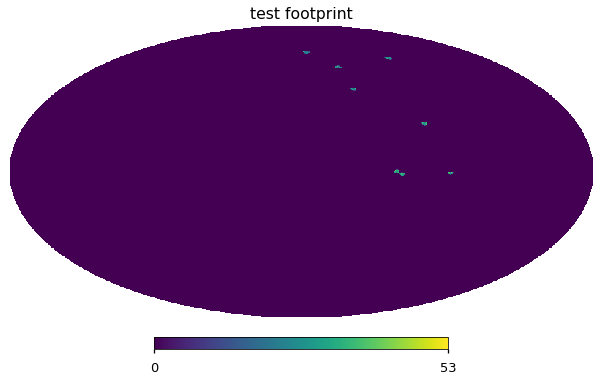

In [94]:
footprint = hpixsum(nside = 512, 
                    ra = X_tst[:,1].astype(np.float), 
                    dec = X_tst[:,2].astype(np.float))

hp.mollview(footprint, rot = -85, cmap = 'viridis', title = 'test footprint')

#### Resample training set to match desired ratio 

In [95]:
# per_cat_num = (.80 * np.array([10000, 100000, 125000, 60000])).astype(int) #number of objects to include per category
# replace = True

# # # Create balanced training / test data set using undersampled majority class records
# X_sampled0, y_sampled0 = resample(X_train[y_train == 0], y_train[y_train == 0],
#                 replace=replace,
#                 n_samples=per_cat_num[0])

# X_sampled1, y_sampled1 = resample(X_train[y_train == 1], y_train[y_train == 1],
#                 replace=replace,
#                 n_samples=per_cat_num[1])

# X_sampled2, y_sampled2 = resample(X_train[y_train == 2], y_train[y_train == 2],
#                 replace=replace,
#                 n_samples=per_cat_num[2])

# X_sampled3, y_sampled3 = resample(X_train[y_train == 3], y_train[y_train == 3],
#                 replace=replace,
#                 n_samples=per_cat_num[3])

# #combine
# X_balanced = np.vstack((X_sampled0, X_sampled1, X_sampled2, X_sampled3))#, X_sampled4))
# y_balanced = np.hstack((y_sampled0, y_sampled1, y_sampled2, y_sampled3))#, y_sampled4))

# #shuffle
# combined = np.hstack((X_balanced, y_balanced.reshape(-1,1)))
# combined = shuffle(combined)

# X_balanced = combined[:,0:-1]
# y_balanced = combined[:,-1]

In [96]:
# # # # change for binary classifier
# per_cat_num = (.80 * np.array([50000, 263000, 79000])).astype(int) #number of objects to include per category
# replace = True

# # # Create balanced training / test data set using undersampled majority class records
# X_sampled0, y_sampled0 = resample(X_trn[y_trn == 0], y_trn[y_trn == 0],
#                 replace=replace,
#                 n_samples=per_cat_num[0])

# X_sampled1, y_sampled1 = resample(X_trn[y_trn == 1], y_trn[y_trn == 1],
#                 replace=replace,
#                 n_samples=per_cat_num[1])

# X_sampled2, y_sampled2 = resample(X_trn[y_trn == 2], y_trn[y_trn == 2],
#                 replace=replace,
#                 n_samples=per_cat_num[2])

# # X_sampled3, y_sampled3 = resample(X_trn[y_trn == 3], y_trn[y_trn == 3],
# #                 replace=replace,
# #                 n_samples=per_cat_num[3])

# #combine
# X_balanced = np.vstack((X_sampled0, X_sampled1, X_sampled2))#, X_sampled3))#, X_sampled4))
# y_balanced = np.hstack((y_sampled0, y_sampled1, y_sampled2))#, y_sampled3))#, y_sampled4))

# #shuffle
# combined = np.hstack((X_balanced, y_balanced.reshape(-1,1)))
# combined = shuffle(combined)

# X_balanced = combined[:,0:-1]
# y_balanced = combined[:,-1]

In [97]:
#np.unique(y_balanced)
np.unique(y_trn)

array([0, 1, 2])

In [98]:
np.intersect1d(X.loc[indices_trn]['TARGETID'], X.loc[indices_tst]['TARGETID'])

array([], dtype=int64)

In [99]:
#for i in range(len(np.unique(y_balanced))):
for i in range(len(np.unique(y_tst))):
    print(f"Baseline performance: for label {i} is {np.round(np.count_nonzero(y == i)/len(y), 2)}")

Baseline performance: for label 0 is 0.04
Baseline performance: for label 1 is 0.74
Baseline performance: for label 2 is 0.22


In [18]:
for i in range(len(np.unique(y_balanced))):
    print(f"Baseline performance: for label {i} is {np.round(np.count_nonzero(y_balanced == i)/len(y_balanced), 2)}")

NameError: name 'y_balanced' is not defined

In [100]:
#for i in range(len(np.unique(y_balanced))):
for i in range(len(np.unique(y_tst))):
    print(f"Baseline set: for label {i} is {(y == i).sum()}")
    print(f"Baseline training set: for label {i} is {(y_trn == i).sum()/len(y_trn) * 100}")
    print(f"Baseline test set: for label {i} is {(y_tst == i).sum()/len(y_tst) * 100}")

Baseline set: for label 0 is 15052
Baseline training set: for label 0 is 4.242677970240899
Baseline test set: for label 0 is 4.03331566170931
Baseline set: for label 1 is 263712
Baseline training set: for label 1 is 73.63057547054616
Baseline test set: for label 1 is 73.46884678701973
Baseline set: for label 2 is 79549
Baseline training set: for label 2 is 22.126746559212936
Baseline test set: for label 2 is 22.497837551270962


In [95]:
# (per_cat_num[1] + per_cat_num[2])/per_cat_num.sum()

#### Train

In [101]:
#!pip3 install memory_profiler
%load_ext memory_profiler

In [102]:
#%%memit
clf=RandomForestClassifier(class_weight={0: 0.325, 1: 0.35, 2: 0.325},
                       max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=20) #based on randomsearchCV tuning 

#Train the model using the training sets y_pred=clf.predict(X_test)
#clf.fit(X_balanced[:,6:], y_balanced.astype(int))
clf.fit(X_trn[:,7:], y_trn.astype(int))

y_prd = clf.predict(X_tst[:,7:])

Training takes an average of $34$ s on Cori and $27.4$ s on Perlmutter. So over $10$ nodes, should take $1$ hour each.

In [430]:
#optionally load previously saved
# import pickle
# with open('../dat/photoz_RF.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [132]:
y_pred_trn = clf.predict(X_trn[:,7:])
#y_pred_balanced = clf.predict(X_balanced)
#y_pred = clf.predict(X_test)

#### Statistics

In [103]:
clf

RandomForestClassifier(class_weight={0: 0.325, 1: 0.35, 2: 0.325},
                       max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10, n_estimators=20)

In [104]:
print("Accuracy:",accuracy_score(y_tst, y_prd))
print("Feature importance:",clf.feature_importances_)
print(X.columns[7:-1])

Accuracy: 0.769078378302966
Feature importance: [0.06961152 0.08289132 0.12227281 0.08993082 0.30987027 0.07706615
 0.08682379 0.16153331]
Index(['MAG_G', 'MAG_R', 'MAG_Z', 'g-r', 'r-z', 'gfib', 'rfib', 'zfib'], dtype='object')


In [135]:
print("Accuracy in training:",accuracy_score(y_trn, y_pred_trn))
#print("Accuracy in balanced training:",accuracy_score(y_balanced, y_pred_balanced))

Accuracy in training: 0.833212971200307


In [105]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, classification_report

In [106]:
print(classification_report(y_tst, y_prd))

              precision    recall  f1-score   support

           0       0.48      0.06      0.10      2891
           1       0.81      0.92      0.86     52661
           2       0.57      0.41      0.48     16126

    accuracy                           0.77     71678
   macro avg       0.62      0.46      0.48     71678
weighted avg       0.74      0.77      0.74     71678



In [120]:
print(accuracy_score(y_tst, y_prd))
print(precision_score(y_tst, y_prd, average='macro'))
print(recall_score(y_tst, y_prd, average='macro'))

0.7556627289476536
0.5589229889324397
0.4644014726701868


In [234]:
#cross validation
# from sklearn.model_selection import cross_val_score, KFold
# cv_score = cross_val_score(clf, X_train, y_train, cv=KFold(shuffle=True))
# print(cv_score)

In [162]:
confusion_matrix(y_tst, y_prd, normalize='pred')

array([[0.25223214, 0.03333843, 0.06805831],
       [0.42410714, 0.82358133, 0.44500992],
       [0.32366071, 0.14308024, 0.48693177]])

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


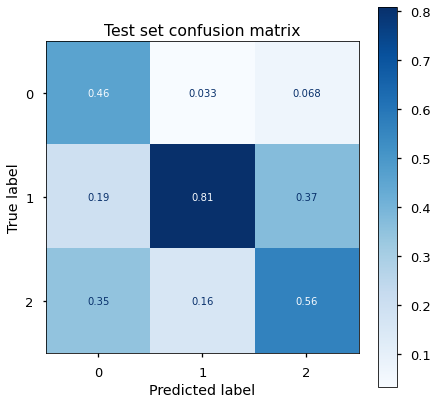

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, X_tst[:,7:], y_tst, normalize='pred', cmap=plt.cm.Blues, ax=ax)
plt.title("Test set confusion matrix")
plt.show()
#plt.savefig("../plots/conf_matrix.pdf", dpi = 450, bbox_inches = 'tight')

First we plot each label in the training and the test sample and look at the qualitative distribution

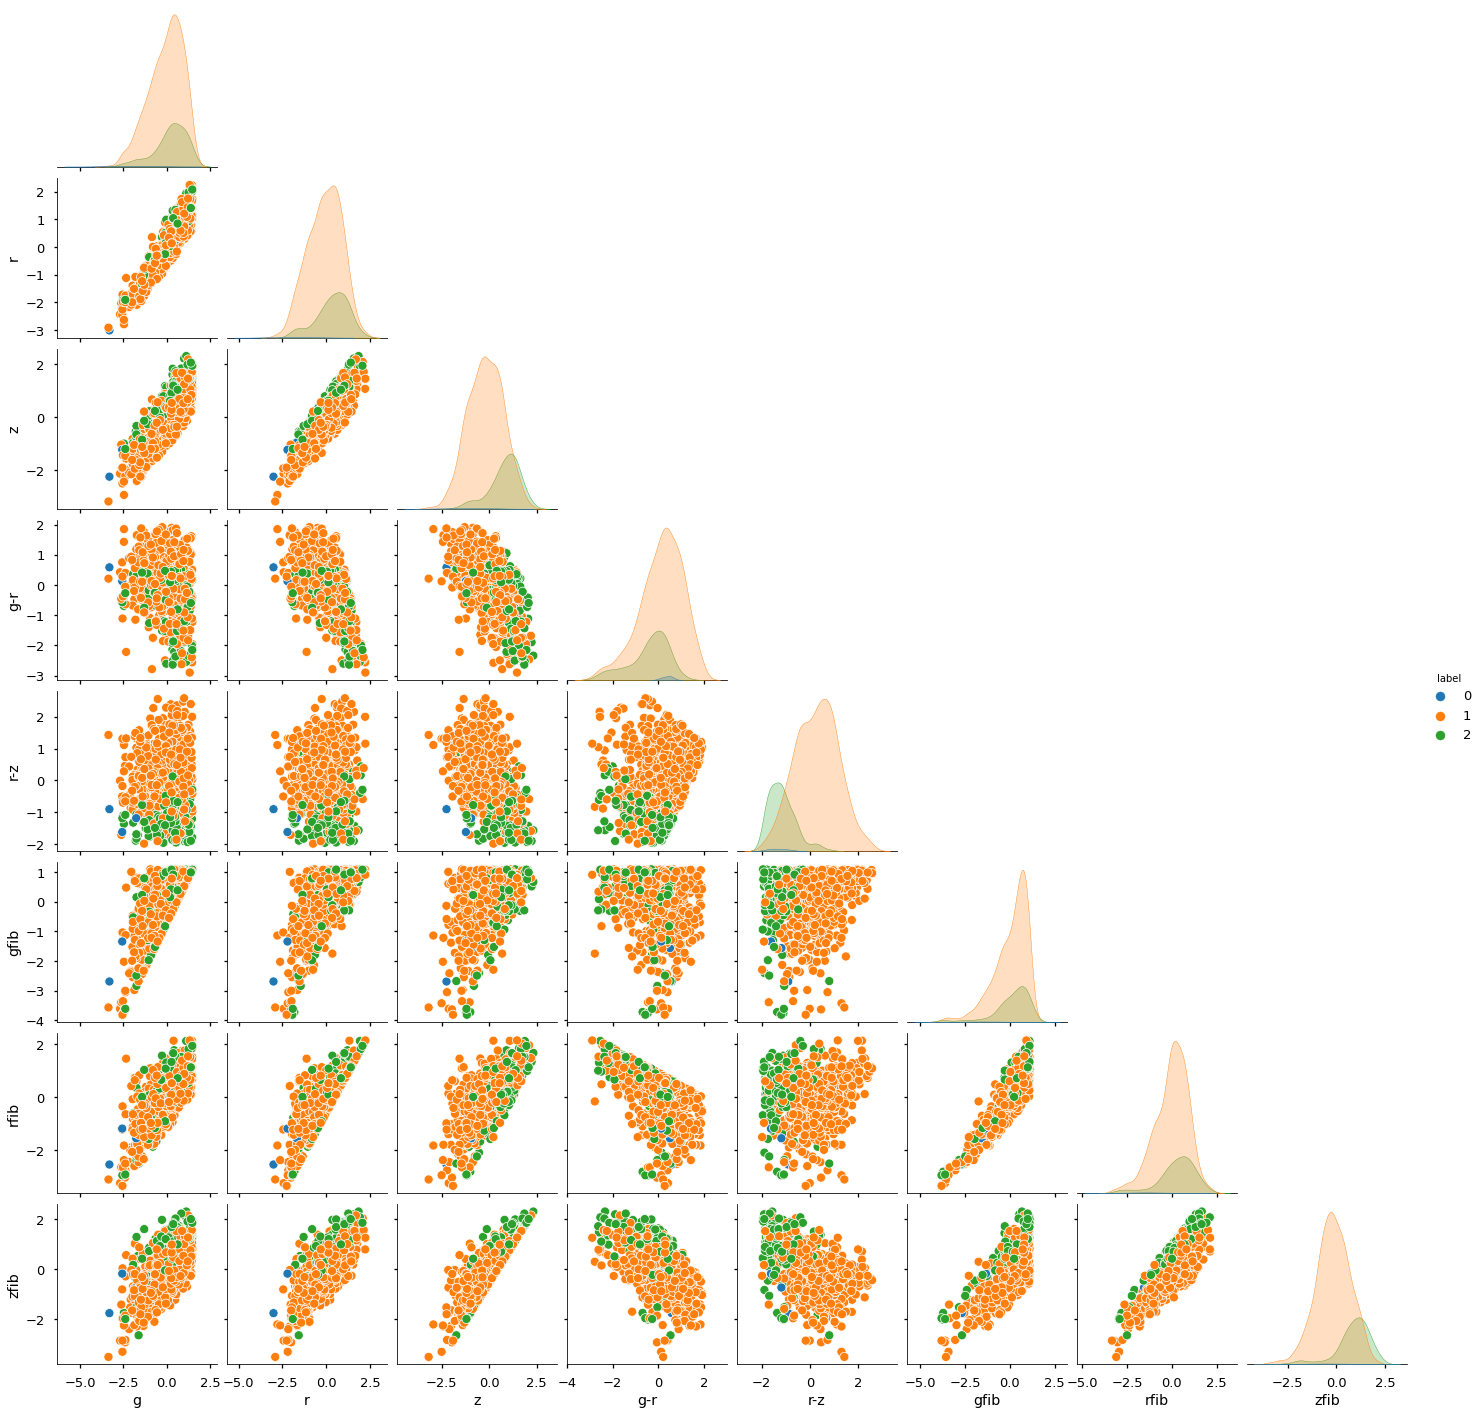

In [124]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.hstack((X_tst[::100,6:], y_prd[::100].reshape(-1,1))), columns=['g','r','z', 'g-r', 'r-z', 
                                                                              'gfib', 'rfib', 'zfib', 'label']), 
             hue = 'label', palette="tab10", corner = True)

Save random forest model

In [107]:
import pickle 
pickle.dump(clf, open("../dat/photoz_RF_single-tomo-classifier.pkl", 'wb'))

% in tomo bin 2 with bad redshift: 0.15722215700414227


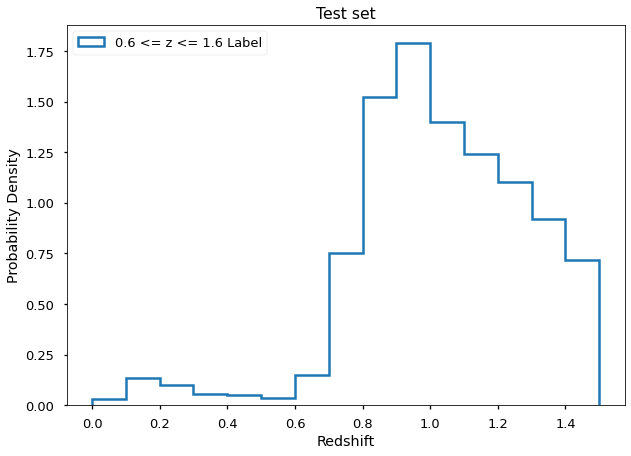

In [109]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 1.6, 0.1)

# test_specz = X.iloc[indices_tst][y_prd == 0]['Z']
# print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
# tst_1 = plt.hist(test_specz[test_specz != -99], 
# bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "z < 0.6 Label");

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.6 Label");

# tst_2_clipped = plt.hist(test_specz[(test_specz != -99) & (test_specz >= 0.6)], 
# bins = zrange, density = False, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.65 Label clipped");
#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

In [69]:
#save it as pandas 
# tmpd = {'Redshift_mid' : tst_2[1][:-1] + np.diff(tst_2[1])/2,
#     'pz' : tst_2[0] * (1 - 0.1574)}
# pzdz = pd.DataFrame(tmpd)

tmpd = {'Redshift_mid' : tst_2[1][:-1] + np.diff(tst_2[1])/2,
    'pz' : tst_2[0]} #dn/(dz * ddeg2)
pzdz = pd.DataFrame(tmpd)

In [23]:
# pzdz.to_csv("../dat/nz_fuji_singletomo.csv")
pzdz.to_csv("../dat/nz_fuji_singletomo_number.csv")

In [27]:
pzdz['pz'].sum() * .1

35.595714285714294

% in tomo bin 1 with bad redshift: 0.3359497645211931
% in tomo bin 2 with bad redshift: 0.16238159675236807


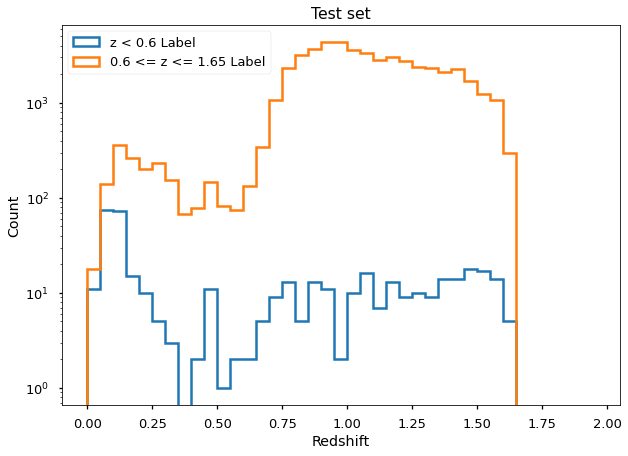

In [126]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 2, 0.05)

test_specz = X.iloc[indices_tst][y_prd == 0]['Z']
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = False, histtype = 'step', lw = 2.5, label = "z < 0.6 Label");

test_specz = X.iloc[indices_tst][y_prd == 1]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = False, histtype = 'step', lw = 2.5, label = "0.6 <= z <= 1.65 Label");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

## Test 5: What is the confusion matrix inside the bad region?

We ask this to see whether RF systematically underperforms in this region. If so, then it is better to clip it than include it in our analysis.

In [136]:
##--TO GET THIS, GO TO THE NEXT SECTION AND FIGURE OUT THE CONTOUR THERE
tmpxx_scaled, tmpyy_scaled = circle_cut(.5, -1.8, .18)

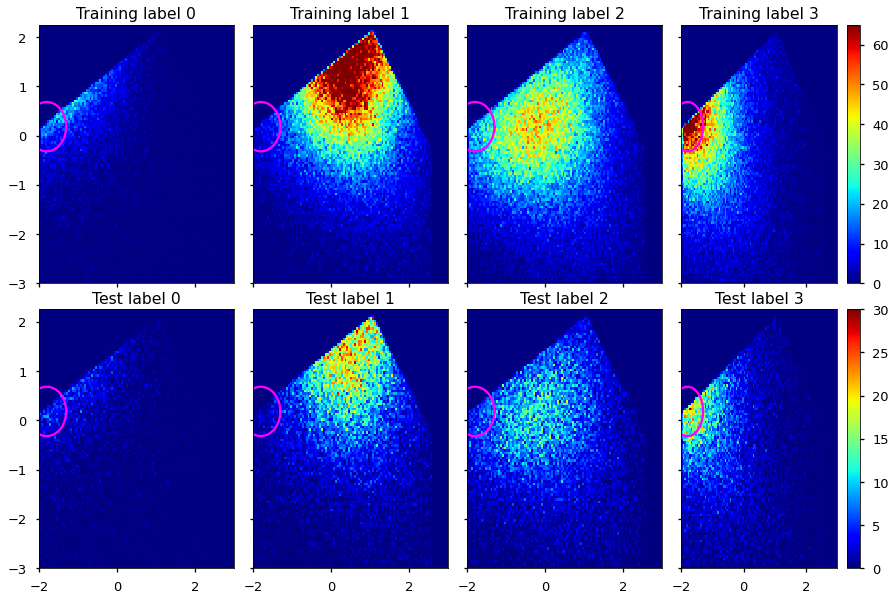

In [138]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(4):
    #training sample
    im0 = axs[0,i].hist2d(X_train[:,4][y_train == i], X_train[:,3][y_train == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 65, range = [[-2, 3], [-3, 2.25]]);
    axs[0,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
    axs[0,i].set_title(f"Training label {i}")
    
    #test sample
    im1 = axs[1,i].hist2d(X_test[:,4][y_test == i], X_test[:,3][y_test == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 30, range = [[-2, 3], [-3, 2.25]]);
    axs[1,i].set_title(f"Test label {i}")
    axs[1,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[0][3])
cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
# fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

In [141]:
#define points in the circle ##--TO GET THIS, GO TO THE NEXT SECTION AND FIGURE OUT THE CONTOUR THERE
is_in_circle = ((X_test[:,4] - -1.8)**2 + (X_test[:,3] - .18)**2 < .5**2)

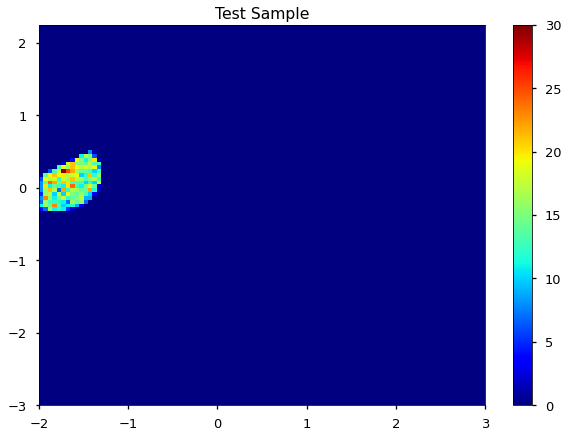

In [142]:
plt.figure(figsize = (10, 7))
# plt.hist2d(X_test[:,0][y_test == 3], X_test[:,1][y_test == 3], 
#            bins = 100, cmap = plt.cm.jet, vmin = 0);
plt.hist2d(X_test[:,4][(y_test == 3) & is_in_circle], X_test[:,3][(y_test == 3) & is_in_circle], 
           bins = 100, cmap = plt.cm.jet, vmin = 0, vmax = 30, range = [[-2, 3], [-3, 2.25]]);
# plt.hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
#             bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0);
plt.title("Test Sample")
plt.colorbar()
#fdr_plot()
#plt.plot(tmpxx, tmpyy, c = 'magenta')

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Outside the circle')

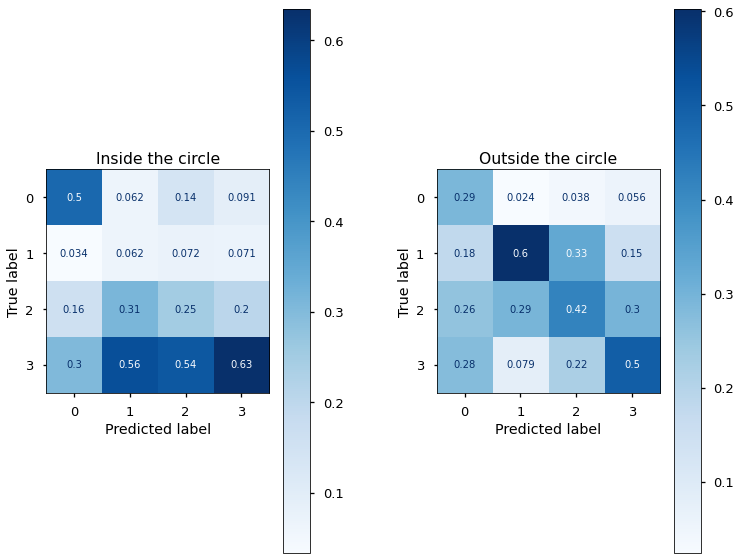

In [143]:
fig, axs = plt.subplots(1, 2, figsize = (12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

plot_confusion_matrix(clf, X_test[is_in_circle], y_test[is_in_circle], normalize='pred', cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title("Inside the circle")
plot_confusion_matrix(clf, X_test[~is_in_circle], y_test[~is_in_circle], normalize='pred', cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title("Outside the circle")

#### How do each of the predicted labels' locus compare to the real locus?

In [52]:
%time y_pred_balanced = clf.predict(X_balanced)

CPU times: user 9.22 s, sys: 128 ms, total: 9.35 s
Wall time: 9.35 s


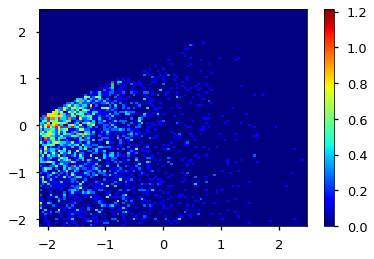

In [53]:
#tmptmp = (y_pred_balanced == 4)
tmptmp = (y_pred == 4)
# tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
#                  density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
tmpa = plt.hist2d(X_balanced[:,0][indices_test][tmptmp], 
                  X_balanced[:,1][indices_test][tmptmp], bins = 100,  cmap = plt.cm.jet,
                  density = True, range = [[X_balanced[:,0][indices_test][tmptmp].min(),
                                            X_balanced[:,0][indices_test][tmptmp].max()], 
                                           [X_balanced[:,0][indices_test][tmptmp].min(), 
                                            X_balanced[:,0][indices_test][tmptmp].max()]]);
plt.colorbar()
plt.show()

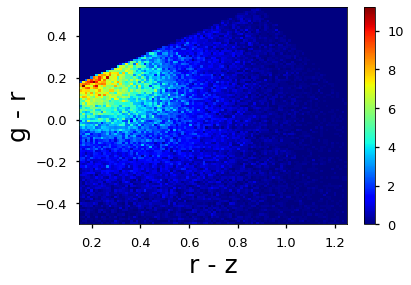

In [54]:
# plt.hist2d(mag_bad['r-z'], mag_bad['g-r'], 
#           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
#           vmax = 180);
# tmpb = plt.hist2d(mag_good['r-z'][lowz_bad_bin & cond], mag_good['g-r'][lowz_bad_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_1_bin & cond], mag_good['g-r'][tomo_1_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_2_bin & cond], mag_good['g-r'][tomo_2_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][highz_bad_bin & cond], mag_good['g-r'][highz_bad_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
tmpb = plt.hist2d(mag_bad['r-z'][cond_bad], mag_bad['g-r'][cond_bad], 
           bins = 100, cmap = plt.cm.jet, range = [[mag_good['r-z'][cond].min(), mag_good['r-z'][cond].max()], 
                                                   [mag_good['g-r'][cond].min(), mag_good['g-r'][cond].max()]],
                  density = True);
# plt.plot(np.arange(4/9, 2/3, 0.01), np.arange(4/9, 2/3, 0.01) * 1.4 - 0.5, lw = 4.5, c = 'magenta')
# plt.plot(tmpx, tmpy, c = 'magenta', lw = 4.5)
# plt.plot(tmpxx, tmpyy, c = 'magenta', lw = 4.5)
#plt.title("ZWARN != 0")
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.colorbar()
plt.show()

#### Where do labels predicted as not 4 but actually are 4 reside on the colour-colour space?

Text(0.5, 1.0, '(4, 1)')

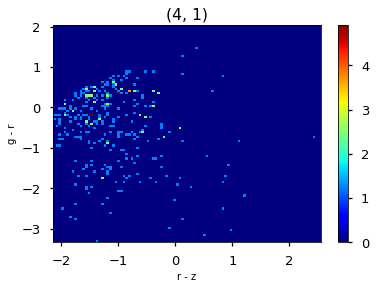

In [55]:
tupp = (4,1)
tmptmp = (y_pred_balanced == tupp[0]) & (y_balanced == tupp[1])
tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
                 density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
plt.colorbar()
plt.xlabel("r - z", fontsize = 10)
plt.ylabel("g - r", fontsize = 10)
plt.title(f"({tupp[0]}, {tupp[1]})")

#### Tomographic dndz based on classifier
We plot the redshift distributions of the two tomographic bins based on this classifier

In [184]:
from astropy.cosmology import Planck18
from astropy.constants import c

In [185]:
#plot CMB lensing kernel
def cmb_kernel(z):
    return 3/2 * Planck18.Om0/c * Planck18.H0**2/Planck18.H(z) * (1 + z) * Planck18.comoving_distance(z) * (1 - Planck18.comoving_distance(z)/Planck18.comoving_distance(1090))

### What fraction of objects with missing redshifts per tomographic bin are `GALAXY`, `STAR` or `QSO`for i in range (1,3):

In [156]:
for i in range (1,3):
    tmp_spectype = X_sampled[indices_test][(y_pred == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

/tmp/ipykernel_28146/1203028275.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99


% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 1 is 75.59
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 1 is 0.75
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 1 is 23.67
% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 2 is 90.38
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 2 is 0.44
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 2 is 9.17


% in tomo bin 1 with bad redshift: 0.07825510279271977
% in tomo bin 2 with bad redshift: 0.22476287803787565


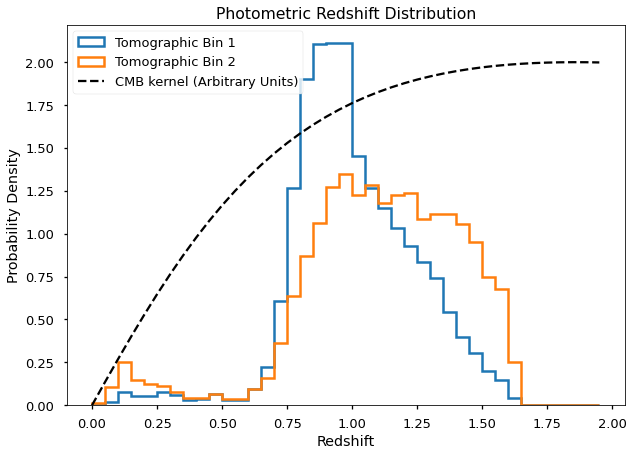

In [241]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X.iloc[indices_test]['Z'][y_pred == 1]
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X.iloc[indices_test]['Z'][y_pred == 2]
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Photometric Redshift Distribution")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()
#plt.savefig("../plots/tomo_dndz.pdf", bbox_inches = 'tight', dpi = 450)

### Where do the failures of the tomographic bins lie?

In [148]:
X.loc[indices_test][y_pred == 1]['Z'] == -99

33464     False
113208    False
180389    False
333935    False
288065    False
          ...  
78338     False
175483    False
182724     True
349109    False
112919     True
Name: Z, Length: 27230, dtype: bool

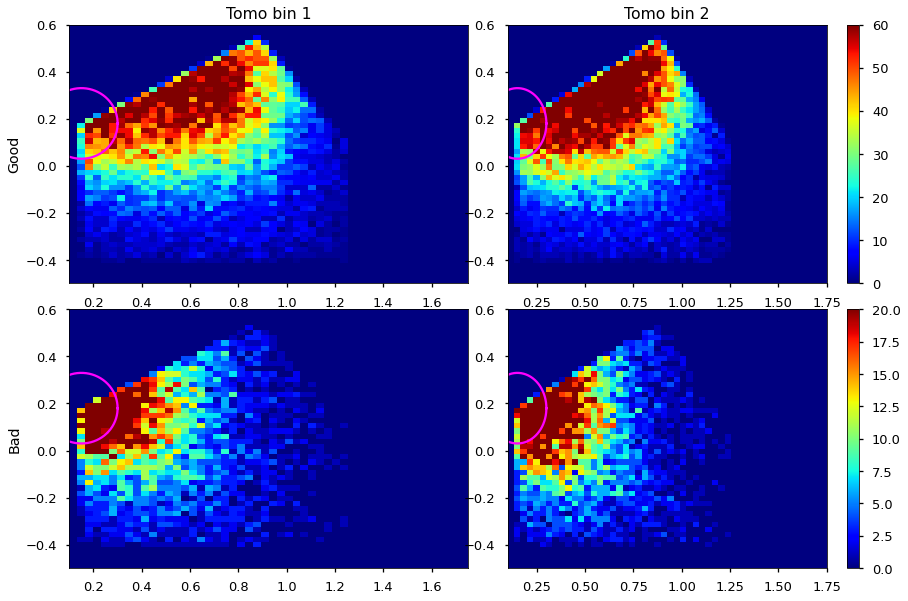

In [150]:
fig, axs = plt.subplots(2,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

imall = {}
imbad = {}

for i in range(1,3):
    tmp_spectype = X.loc[indices_test][(y_pred == i)]
    bad_redshift_cond = (tmp_spectype['Z'] == -99)
    
    #histogram all data
    imall[i] = axs[0, i-1].hist2d(tmp_spectype['r-z'], tmp_spectype['g-r'], 
                    bins = 50, cmap = plt.cm.jet, vmin = vmin, vmax = 60, range = range2d);
    axs[0, i-1].plot(tmpxx, tmpyy, c = 'magenta')
    axs[0, i-1].set_title(f"Tomo bin {i}")
    
    #histogram bad redshift
    imbad[i] = axs[1, i-1].hist2d(tmp_spectype.loc[bad_redshift_cond]['r-z'], tmp_spectype.loc[bad_redshift_cond]['g-r'], 
                    bins = 50, cmap = plt.cm.jet, vmin = vmin, vmax = 20, range = range2d);
    axs[1, i-1].plot(tmpxx, tmpyy, c = 'magenta')
    #axs[i-1].set_title(f"Tomo bin {i}")

axs[0,0].set_ylabel("Good")
axs[1,0].set_ylabel("Bad")
#add common colorbar
cbar1 = fig.colorbar(imall[i][3], ax=axs[0][1])
cbar2 = fig.colorbar(imbad[i][3], ax=axs[1][1])

# hide tick and tick label of the big axis
#fig.suptitle("Distribution of all redshifts per tomographic bin full region", fontsize = 15)

### Is the amount of bad redshifts per pixels consistent everywhere?

This question looks into whether we can use the derived dndz without modeling additional tails. The idea is to compare what is the relative abundance of targets with bad redshift compared to the total number of targets per pixel. We notice in the plot above that for the tomographic bins, the loci of the overall targets are coincident with bad targets. This means that the trend we see for bad redshifts may be explained away by the overall incidence. To test this, we take bins with at least 1 bad target and find its ratio with the same bins with all the targets. If the bad targets are randomly distributed, then we would expect this ratio to be roughly uniform with some tail. 

However, we also have to consider the fact that there might be shot noise, so we may need to increase the grid size.

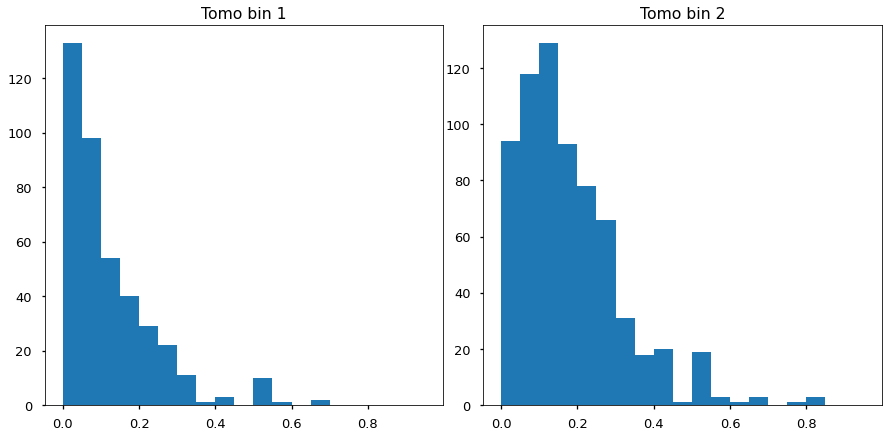

In [247]:
fig, axs = plt.subplots(1,2, figsize = (15, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(1,3):
    cond_bad_redz_pixels = (imbad[i][0] > 0)
    bins_with_bad_redshifts_bad_binning = imbad[i][0][cond_bad_redz_pixels]
    bins_with_bad_redshifts_all_binning = imall[i][0][cond_bad_redz_pixels]
    
    axs[i-1].hist(bins_with_bad_redshifts_bad_binning/bins_with_bad_redshifts_all_binning, bins = np.arange(0, 1, 0.05), cumulative = False, density = False)
    #axs[i-1].set_yscale("log")
    axs[i-1].set_title(f"Tomo bin {i}")

#### Save dndz

In [58]:
bin_ledge = tst_1[1]
bin_mid = bin_ledge[:-1] + np.diff(bin_ledge)/2
bin_ledge = bin_ledge[:-1] #remove the rightmost edge to have same shape as bin_mid

tomo1_values = tst_1[0]
tomo2_values = tst_2[0]

In [59]:
tomograph1 = pd.DataFrame(np.vstack((bin_ledge, bin_mid, tomo1_values)).T, 
                          columns=['Redshift_Ledge', 'Redshift_mid', 'dndz'])
tomograph2 = pd.DataFrame(np.vstack((bin_ledge, bin_mid, tomo2_values)).T, 
                          columns=['Redshift_Ledge', 'Redshift_mid', 'dndz'])

tomograph1.to_csv("../dat/nz_fuji_tomo1.csv", index = False,)
tomograph2.to_csv("../dat/nz_fuji_tomo2.csv", index = False,)

<AxesSubplot:xlabel='Redshift_mid'>

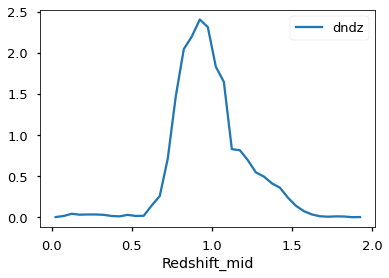

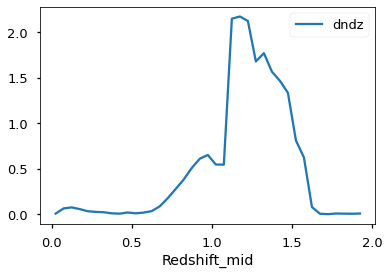

In [60]:
tomograph1.plot('Redshift_mid', 'dndz')
tomograph2.plot('Redshift_mid', 'dndz')

#### Save model

In [62]:
import pickle
# now you can save it to a file
with open('../dat/photoz_RF.pkl', 'wb') as f:
    pickle.dump(clf, f)

## Test 6: What is the dndz of good galaxies inside the circle look like in comparison to the overall dndz?

The goal of this test is to determine whether the dndz inside the circle is systematically different and if that can give us a clue to how to model the dndz of the bad targets.

/tmp/ipykernel_28146/4038206183.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.046708495169803806


/tmp/ipykernel_28146/4038206183.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred == 2)][:,-1].astype(np.float)


% in tomo bin 2 with bad redshift: 0.10779808081179455


/tmp/ipykernel_28146/4038206183.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred != 3) & is_in_circle_test][:,-1].astype(np.float)
/tmp/ipykernel_28146/4038206183.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 1) & is_in_

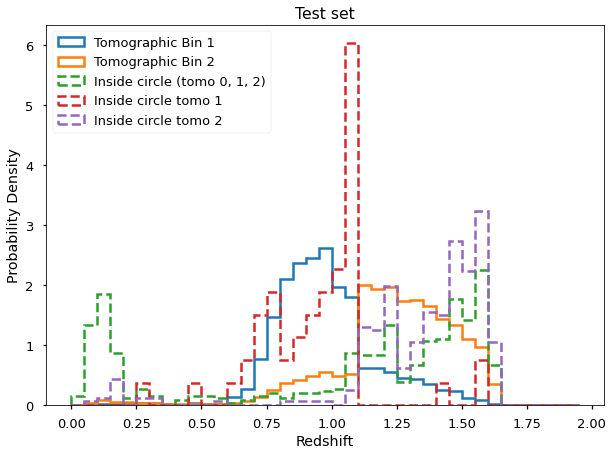

In [272]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled[indices_test][(y_pred == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled[indices_test][(y_pred == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plot dndz inside the circle
test_specz = X_sampled[indices_test][(y_pred != 3) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed", label = 'Inside circle (tomo 0, 1, 2)')

test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 1) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed",  label = 'Inside circle tomo 1')

test_specz = X_sampled[indices_test][(y_pred != 3) & (y_pred == 2) & is_in_circle_test][:,-1].astype(np.float)
tst_circ = plt.hist(test_specz[test_specz != -99],
                   bins = zrange, density = True, histtype = 'step', lw = 2.5, ls = "dashed",  label = 'Inside circle tomo 2')


#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

## Test 6: How does RF perform when the worst region is removed? 

In [267]:
#cut region
r = .4
h = .15
k = .18
tmpxx, tmpyy = circle_cut(r, h, k)
is_in_circle_df = ((df['r-z'] - h)**2 + (df['g-r'] - k)**2 < r**2)

In [268]:
print(f"% of ELGs removed: {is_in_circle_df.sum()/len(df)}")
print(f"% of bad ELGs inside: {((is_in_circle_df) & (df['label'] == 3)).sum()/len(df[is_in_circle_df])}")
print(f"% of bad ELGs outside: {((~is_in_circle_df) & (df['label'] == 3)).sum()/len(df[~is_in_circle_df])}")

% of ELGs removed: 0.33044291376039053
% of bad ELGs inside: 0.4403030502451384
% of bad ELGs outside: 0.12725419985547137


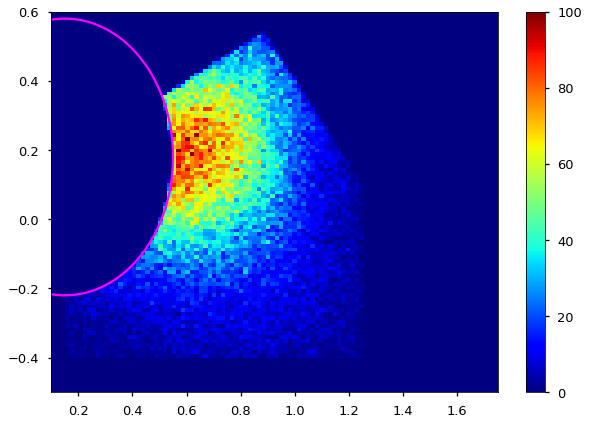

In [269]:
plt.figure(figsize = (10, 7))
i = 2
plt.hist2d(df.loc[(df['label'] == i) & (~is_in_circle_df)]['r-z'], df.loc[(df['label'] == i) & (~is_in_circle_df)]['g-r'], 
           bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0, vmax = 100);
# plt.hist2d(zcat_elg['r-z'][~is_oii_good], zcat_elg['g-r'][~is_oii_good], 
#             bins = 100, cmap = plt.cm.jet, range = range2d, vmin = 0);
plt.colorbar()
#fdr_plot()
plt.plot(tmpxx, tmpyy, c = 'magenta')

In [270]:
df_remove = df[~is_in_circle_df]

In [271]:
df_remove.head()

TARGETID   SPECTYPE   SHAPE_R      MAG_G      MAG_R  \
202453  39627884867882965  b'GALAXY'  0.596420  22.246650  21.854917   
343099  39633149671508869  b'GALAXY'  0.362617  23.515922  23.254010   
166003  39627830652305694  b'GALAXY'  0.419995  22.956668  23.268269   
50416   39632991265230194  b'GALAXY'  0.201395  23.360048  23.391629   
233830  39627805905915946  b'GALAXY'  0.270797  23.196672  23.163778   

            MAG_Z       g-r       r-z       gfib       rfib       zfib  \
202453  21.212177  0.391733  0.642740  23.103881  22.712148  22.069408   
343099  22.366760  0.261911  0.887250  24.058851  23.796939  22.909689   
166003  22.610416 -0.311602  0.657854  23.573985  23.885586  23.227733   
50416   22.694471 -0.031582  0.697158  23.725712  23.757294  23.060135   
233830  22.515329  0.032893  0.648450  23.633082  23.600188  22.951739   

               Z  label  
202453  0.835611      1  
343099  0.873654      1  
166003  1.269916      2  
50416   0.970413      1  
233830  1.198327      2

In [272]:
df_remove.groupby('label').count()#/df.groupby('redz_bin').count()['r-z'].sum()

TARGETID  SPECTYPE  SHAPE_R   MAG_G   MAG_R   MAG_Z     g-r     r-z  \
label                                                                        
0          5570      5570     5570    5570    5570    5570    5570    5570   
1        123192    123192   123192  123192  123192  123192  123192  123192   
2         86211     86211    86211   86211   86211   86211   86211   86211   
3         31345     31345    31345   31345   31345   31345   31345   31345   

         gfib    rfib    zfib       Z  
label                                  
0        5570    5570    5570    5570  
1      123192  123192  123192  123192  
2       86211   86211   86211   86211  
3       31345   31345   31345   31345

In [273]:
#split into features and classes
X_remove, y_remove = df_remove.drop(["label"], axis=1), df_remove["label"].values

#scale features
sc = StandardScaler()
X_transformed_remove = sc.fit_transform(X_remove.iloc[:,3:-1])

# Create train/test sets
X_train_remove, X_test_remove, y_train_remove, y_test_remove, indices_train_remove, indices_test_remove = train_test_split(X_transformed_remove, y_remove, np.arange(0, len(X_transformed_remove)), #last element is to track indices
                                                                                 test_size=0.20, shuffle=True,
                                                                                 stratify=y_remove)

In [274]:
#resample training set
per_cat_num_remove = (.80 * np.array([5500, 43000, 86000, 21000])).astype(int) #number of objects to include per category
replace = True

# # Create balanced training / test data set using undersampled majority class records
X_sampled0_remove, y_sampled0_remove = resample(X_train_remove[y_train_remove == 0], y_train_remove[y_train_remove == 0],
                replace=replace,
                n_samples=per_cat_num_remove[0])

X_sampled1_remove, y_sampled1_remove = resample(X_train_remove[y_train_remove == 1], y_train_remove[y_train_remove == 1],
                replace=replace,
                n_samples=per_cat_num_remove[1])

X_sampled2_remove, y_sampled2_remove = resample(X_train_remove[y_train_remove == 2], y_train_remove[y_train_remove == 2],
                replace=replace,
                n_samples=per_cat_num_remove[2])

X_sampled3_remove, y_sampled3_remove = resample(X_train_remove[y_train_remove == 3], y_train_remove[y_train_remove == 3],
                replace=replace,
                n_samples=per_cat_num_remove[3])

#combine
X_balanced_remove = np.vstack((X_sampled0_remove, X_sampled1_remove, X_sampled2_remove, X_sampled3_remove))#, X_sampled4))
y_balanced_remove = np.hstack((y_sampled0_remove, y_sampled1_remove, y_sampled2_remove, y_sampled3_remove))#, y_sampled4))

#shuffle
combined_remove = np.hstack((X_balanced_remove, y_balanced_remove.reshape(-1,1)))
combined_remove = shuffle(combined_remove)

X_balanced_remove = combined_remove[:,0:-1]
y_balanced_remove = combined_remove[:,-1]

In [275]:
for i in range(len(per_cat_num_remove)):
    print(f"Baseline performance: for label {i} is {np.round(per_cat_num_remove[i]/per_cat_num_remove.sum(), 2)}")

Baseline performance: for label 0 is 0.04
Baseline performance: for label 1 is 0.28
Baseline performance: for label 2 is 0.55
Baseline performance: for label 3 is 0.14


In [276]:
np.intersect1d(X_remove.iloc[indices_test_remove]['TARGETID'], X_remove.iloc[indices_train_remove]['TARGETID'])

array([], dtype=int64)

In [277]:
#Create a Gaussian Classifier
clf_remove=RandomForestClassifier(max_depth=70, min_samples_split=5, n_estimators=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_remove.fit(X_balanced_remove, y_balanced_remove)

y_pred_remove=clf_remove.predict(X_test_remove)

In [278]:
print("Accuracy:",accuracy_score(y_test_remove, y_pred_remove))
print("Feature importance:",clf_remove.feature_importances_)

Accuracy: 0.4833955829814875
Feature importance: [0.11494184 0.1113791  0.12107101 0.14716933 0.12902706 0.12168796
 0.12005541 0.13466829]


In [279]:
# #cross validation
# from sklearn.model_selection import cross_val_score
# cv_score = cross_val_score(clf, X_train, y_train, cv=5)
# print(cv_score)

In [280]:
tmpxx_scaled, tmpyy_scaled = circle_cut(.7, -2, .05)
is_in_circle_test = ((X_test_remove[:,4] - -2)**2 + (X_test_remove[:,3] - .05)**2 < .45**2)

Text(0.5, 0.98, 'Remove circle')

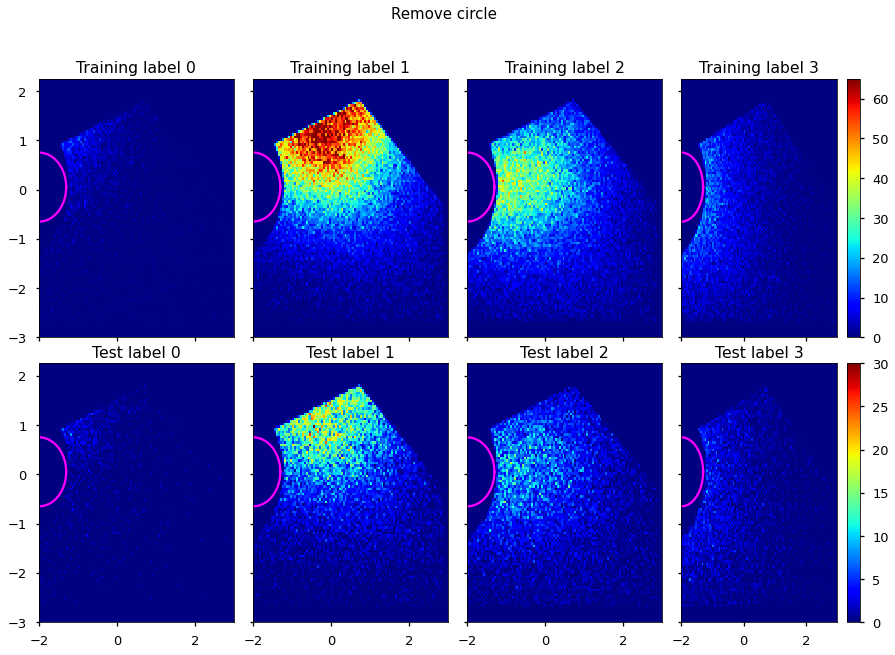

In [281]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(4):
    #training sample
    im0 = axs[0,i].hist2d(X_train_remove[:,4][y_train_remove == i], X_train_remove[:,3][y_train_remove == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 65, range = [[-2, 3], [-3, 2.25]]);
    axs[0,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
    axs[0,i].set_title(f"Training label {i}")
    
    #test sample
    im1 = axs[1,i].hist2d(X_test_remove[:,4][y_test_remove == i], X_test_remove[:,3][y_test_remove == i], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 30, range = [[-2, 3], [-3, 2.25]]);
    axs[1,i].set_title(f"Test label {i}")
    axs[1,i].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')

    #add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[0][3])
cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("Remove circle", fontsize = 15)
# fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Remove circle')

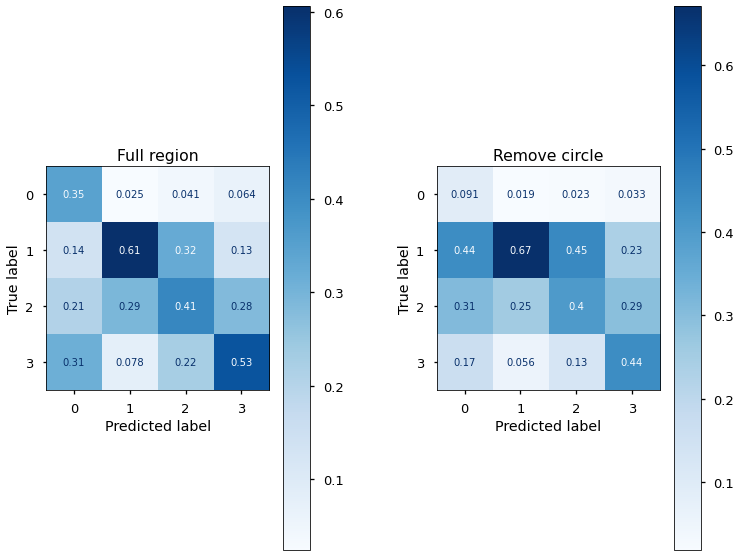

In [282]:
fig, axs = plt.subplots(1, 2, figsize = (12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

plot_confusion_matrix(clf, X_test, y_test, normalize='pred', cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title("Full region")
plot_confusion_matrix(clf_remove, X_test_remove, y_test_remove, normalize='pred', cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title("Remove circle")

In [ ]:
plt.figure(figsize=(10,7))
zrange = np.arange(0, 2, 0.05)

test_specz = X_remove.iloc[indices_test_remove][y_pred_remove == 1]['Z']
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_remove.iloc[indices_test_remove][y_pred_remove == 2]['Z']
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Photometric Redshift Distribution - circle removed")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()
#plt.savefig("../plots/tomo_dndz.pdf", bbox_inches = 'tight', dpi = 450)

% in tomo bin 1 with bad redshift: 0.05642036571273197
% in tomo bin 2 with bad redshift: 0.12653681894655106


### What fraction of objects with missing redshifts per tomographic bin are `GALAXY`, `STAR` or `QSO`for i in range (1,3):

In [181]:
for i in range (1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

/tmp/ipykernel_28146/883675222.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99


% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 1 is 70.83
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 1 is 1.89
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 1 is 27.27
% of bad redshifts belonging to SPECTYPE GALAXY in tomo bin 2 is 88.47
% of bad redshifts belonging to SPECTYPE STAR in tomo bin 2 is 0.2
% of bad redshifts belonging to SPECTYPE QSO in tomo bin 2 is 11.33


/tmp/ipykernel_28146/327605384.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.04717936498480967


/tmp/ipykernel_28146/327605384.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 2)][:,-1].astype(np.float)


% in tomo bin 2 with bad redshift: 0.08742671009771986


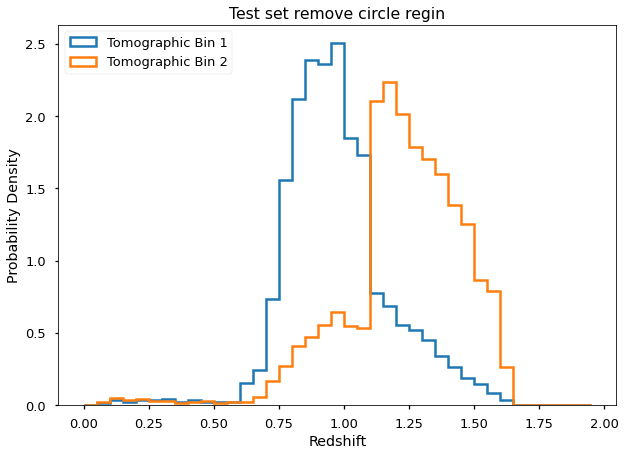

In [182]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled_remove[indices_test_remove][(y_pred_remove == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set remove circle regin")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

### Where do the failures of the tomographic bins lie?

In [ ]:
tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == 1)]
bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)

In [185]:
tmp_spectype[bad_redshift_cond]

array([['0.4487882538970531', '0.11076165053066234',
        '23.643226561322805', ..., '39627794329636499', 'GALAXY',
        '-99.0'],
       ['0.6399097522279362', '0.03004563609142963',
        '23.790178498856253', ..., '39627763581190378', 'GALAXY',
        '-99.0'],
       ['0.3772651105485316', '-0.040251042888421296',
        '23.62046919899541', ..., '39633158328549842', 'GALAXY', '-99.0'],
       ...,
       ['0.6940713099318465', '0.28880161243674607',
        '23.704389163508928', ..., '39627769604213664', 'GALAXY',
        '-99.0'],
       ['0.8362046945127588', '-0.009394474600021852',
        '23.383131280147442', ..., '39632941734693315', 'GALAXY',
        '-99.0'],
       ['0.39200302524917063', '-0.18006552994642888',
        '23.186591222445326', ..., '39633127676575863', 'GALAXY',
        '-99.0']], dtype=object)

/tmp/ipykernel_28146/2219817557.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)
/tmp/ipykernel_28146/2219817557.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im0 = axs[i-1].hist2d(tmp_spectype[bad_redshift_cond][:,0].astype(np.float), tmp_spectype[bad_redshift_cond

Text(0.5, 0.98, 'Distribution of bad redshifts per tomographic bin')

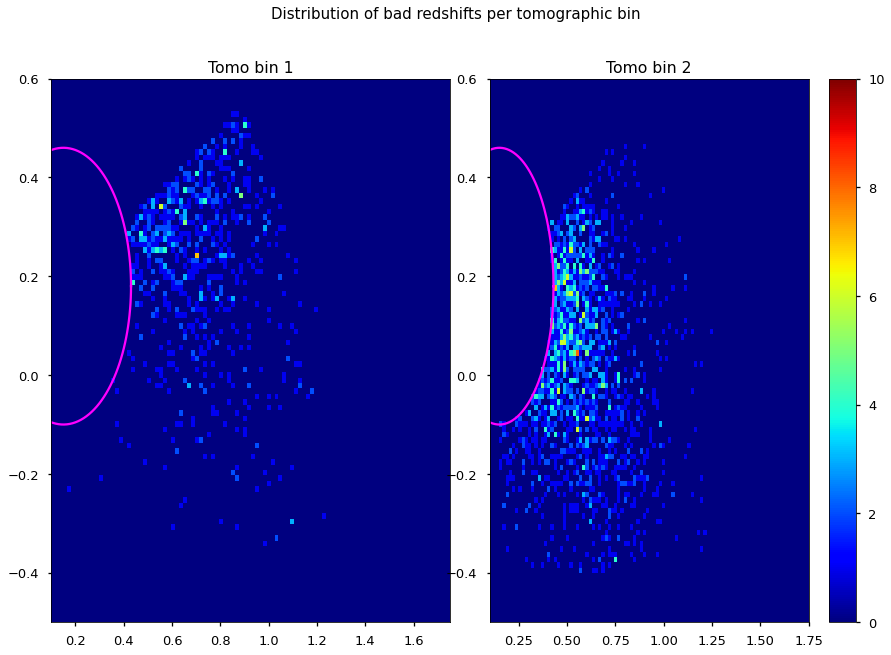

In [194]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = (tmp_spectype[:,-1].astype(np.float) == -99)
    
    #histogram
    im0 = axs[i-1].hist2d(tmp_spectype[bad_redshift_cond][:,0].astype(np.float), tmp_spectype[bad_redshift_cond][:,1].astype(np.float), 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = range2d);
    axs[i-1].plot(tmpxx, tmpyy, c = 'magenta')
    axs[i-1].set_title(f"Tomo bin {i}")
        
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("Distribution of bad redshifts per tomographic bin", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

In [184]:
for i in range (1,3):
    tmp_spectype = X_sampled_remove[indices_test_remove][(y_pred_remove == i)]
    bad_redshift_cond = tmp_spectype[:,-1].astype(np.float) == -99 
    for stype in ['GALAXY', 'STAR', 'QSO']:
        #print("# of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {(tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()}")
        print("% of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype[bad_redshift_cond]) * 100,2)}")
        #print("% overall of bad redshifts belonging to SPECTYPE " + stype + f" in tomo bin {i} is {np.round((tmp_spectype[bad_redshift_cond][:,-2] == stype).sum()/len(tmp_spectype) * 100,2)}")

array([['0.4487882538970531', '0.11076165053066234',
        '23.643226561322805', ..., '39627794329636499', 'GALAXY',
        '-99.0'],
       ['0.6399097522279362', '0.03004563609142963',
        '23.790178498856253', ..., '39627763581190378', 'GALAXY',
        '-99.0'],
       ['0.3772651105485316', '-0.040251042888421296',
        '23.62046919899541', ..., '39633158328549842', 'GALAXY', '-99.0'],
       ...,
       ['0.6940713099318465', '0.28880161243674607',
        '23.704389163508928', ..., '39627769604213664', 'GALAXY',
        '-99.0'],
       ['0.8362046945127588', '-0.009394474600021852',
        '23.383131280147442', ..., '39632941734693315', 'GALAXY',
        '-99.0'],
       ['0.39200302524917063', '-0.18006552994642888',
        '23.186591222445326', ..., '39633127676575863', 'GALAXY',
        '-99.0']], dtype=object)

## Test 6: Where do the confused, i.e. `(y_test == 3) & (y_pred !=3)` galaxies lie? 

This will tell us for both training cases, why the RF is unable to learn more information. Naively, we would expect by removing the bad region, we can improve the accuracy. 

Text(0.5, 0.98, '(y_test == 3) & (y_pred != 3)')

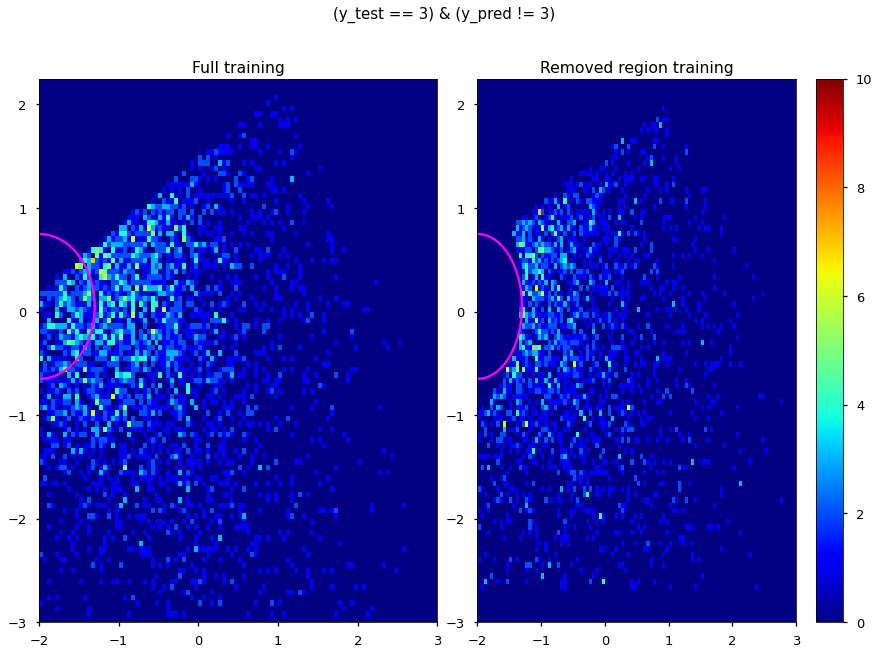

In [614]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#full region
im0 = axs[0].hist2d(X_test[:,0][(y_test == 3) & (y_pred != 3)], X_test[:,1][(y_test == 3) & (y_pred != 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[0].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[0].set_title(f"Full training")
    
    
im0 = axs[1].hist2d(X_test_remove[:,0][(y_test_remove == 3) & (y_pred_remove != 3)], X_test_remove[:,1][(y_test_remove == 3) & (y_pred_remove != 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[1].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[1].set_title(f"Removed region training")
    
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("(y_test == 3) & (y_pred != 3)", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

Text(0.5, 0.98, '(y_test != 3) & (y_pred == 3)')

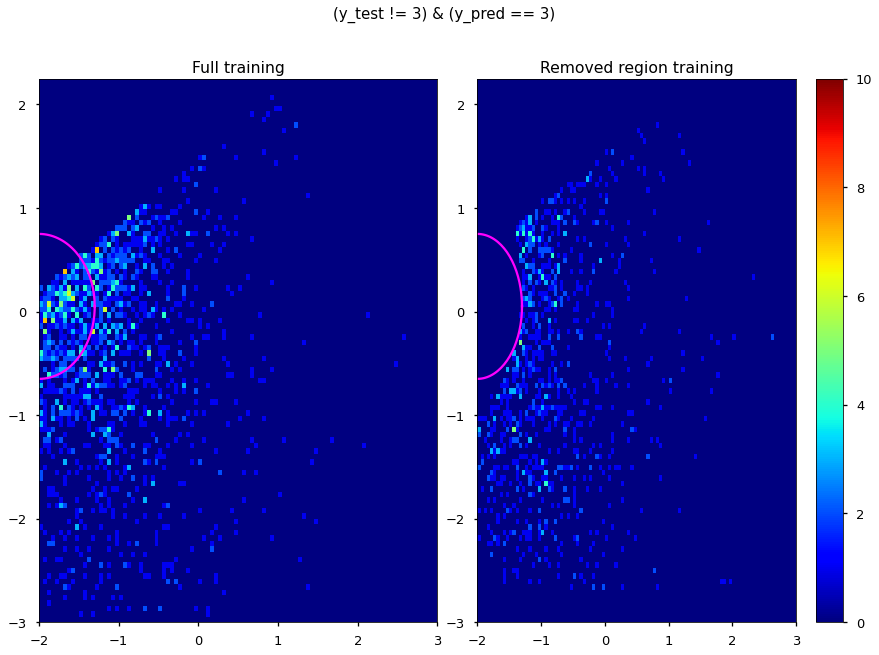

In [615]:
fig, axs = plt.subplots(1,2, figsize = (15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#full region
im0 = axs[0].hist2d(X_test[:,0][(y_test != 3) & (y_pred == 3)], X_test[:,1][(y_test != 3) & (y_pred == 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[0].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[0].set_title(f"Full training")
    
    
im0 = axs[1].hist2d(X_test_remove[:,0][(y_test_remove != 3) & (y_pred_remove == 3)], X_test_remove[:,1][(y_test_remove != 3) & (y_pred_remove == 3)], 
                    bins = 100, cmap = plt.cm.jet, vmin = vmin, vmax = 10, range = [[-2, 3], [-3, 2.25]]);
axs[1].plot(tmpxx_scaled, tmpyy_scaled, c = 'magenta')
axs[1].set_title(f"Removed region training")
    
#add common colorbar
cbar1 = fig.colorbar(im0[3], ax=axs[1])
# cbar2 = fig.colorbar(im1[3], ax=axs[1][3])

# hide tick and tick label of the big axis
fig.suptitle("(y_test != 3) & (y_pred == 3)", fontsize = 15)
# # fig.supxlabel('r-z', fontsize = 15)
# fig.supylabel('g-r', fontsize = 15)

## Test 9: What happens if we move the pivot redshift?

Daniel was surprised at how well the split is at z = 1.1. The question is, is the redshift special because this is where the Balmer break enters z-band, or is it something else?

To test this out, we will train the model with pivot = 0.9 and pivot 1.2. 

In [299]:
#make bins
pivot = 1.2
lowz_interloper_bin = zcat_elg['Z'] < 0.6
tomo_1_bin = (zcat_elg['Z'] > 0.6) & (zcat_elg['Z'] < pivot)
tomo_2_bin = (zcat_elg['Z'] >= pivot) & (zcat_elg['Z'] <= 1.65)
misc_bad_bin = (~is_spectype) | is_bad_flux | (~(is_oii_good.filled(False))) #either spectype does not match GALAXY, flux is missing or negative or does not meet Anand's cut

#bin categories; 0 = lowz, 1 = 1st tomo bin, 2 = 2nd tomo bin, 3 = highz
bin_cat = -99 * np.ones(len(zcat_elg))

#the ordering is important because ELGs in misc bad bin have redshift so if misc_bad_bin is not executed first, assignment of label bins will be wrong. Order of importance: misc_bad_bin, lowz, tomo1, tomo2
for i in range(len(zcat_elg)):
    if(misc_bad_bin[i]):
        bin_cat[i] = 3
    elif(lowz_interloper_bin[i]):
        bin_cat[i] = 0
    elif(tomo_1_bin[i]):
        bin_cat[i] = 1
    elif(tomo_2_bin[i]):
        bin_cat[i] = 2

In [300]:
for i in range(4):
    print(f"% of ELGs in bin {i} is: {(bin_cat == i).sum()/len(bin_cat)}")

% of ELGs in bin 0 is: 0.043489272219820366
% of ELGs in bin 1 is: 0.4610400075722498
% of ELGs in bin 2 is: 0.25103287021522075
% of ELGs in bin 3 is: 0.24443784999270915


In [301]:
zcat_elg['bin_label'] = bin_cat.astype(int)

In [302]:
cond = is_not_incomplete & (~misc_bad_bin)
cond_bad = is_not_incomplete & misc_bad_bin

print(f"good: {cond.sum()}")
print(f"total: {len(cond)}")
print(f"bad: {(~cond).sum()} and %: {(~cond).sum()/len(cond)}")

good: 286664
total: 390901
bad: 104237 and %: 0.26665830990455386


In [303]:
mag_dict = {}
mag_dict['g'] = np.concatenate((zcat_elg['MAG_G'][cond], zcat_elg['MAG_G'][cond_bad])) #combine both ZWARN == 0 and != 0
mag_dict['r'] = np.concatenate((zcat_elg['MAG_R'][cond], zcat_elg['MAG_R'][cond_bad]))
mag_dict['z'] = np.concatenate((zcat_elg['MAG_Z'][cond], zcat_elg['MAG_Z'][cond_bad]))
mag_dict['gr'] = np.concatenate((zcat_elg['g-r'][cond], zcat_elg['g-r'][cond_bad]))
mag_dict['rz'] = np.concatenate((zcat_elg['r-z'][cond], zcat_elg['r-z'][cond_bad]))
mag_dict['shape_r'] = np.concatenate((zcat_elg['SHAPE_R'][cond], zcat_elg['SHAPE_R'][cond_bad]))
mag_dict['TARGETID'] = np.concatenate((zcat_elg['TARGETID'][cond], zcat_elg['TARGETID'][cond_bad]))
mag_dict['SPECTYPE'] = np.concatenate((zcat_elg['SPECTYPE'][cond], zcat_elg['SPECTYPE'][cond_bad]))
mag_dict['specz'] = np.concatenate((np.array(zcat_elg['Z'][cond]), -99*np.ones_like(zcat_elg['Z'][cond_bad])))
mag_dict['label'] = np.concatenate((bin_cat[cond], bin_cat[cond_bad]))

data_array = np.array([mag_dict['rz'], mag_dict['gr'], mag_dict['g'], mag_dict['r'],
                       mag_dict['z'], mag_dict['shape_r'], mag_dict['TARGETID'], mag_dict['SPECTYPE'].astype(str), mag_dict['specz'], mag_dict['label'].astype(int)])
df = pd.DataFrame(data_array.T, columns = ['r-z','g-r', 'g', 'r', 'z', 'shape_r', 'targetid', 'spectype',
                                           'specz', 'redz_bin'])

df = df.sample(frac=1)

print(df)

                       r-z                   g-r                   g  \
360393  0.2815537137167716   0.16659458137425176   23.24214481828513   
333072  0.2463514200100576   0.14394697768425146  22.892897983025676   
8101     1.132787402120801  0.024521480809237772  23.646958373087834   
147298  0.6747830108460171    0.3648150068171354   23.39062584931873   
128522  0.9433385345494756    0.2480439727543775  23.405664983792665   
...                    ...                   ...                 ...   
79370   0.7094994378656416    0.3353157888071614   22.29391066816531   
258157  0.3531286816668491   0.25006740114995907   23.28153595641588   
138715  0.9073101775606567   0.24371388785682768   23.72092346027408   
123087  0.9377786540971869    0.3264446185609984   22.35222462869833   
303155  0.4331041638264317    0.1279273131280938   22.00658828637045   

                         r                   z     shape_r           targetid  \
360393   23.07555023691088  22.793996523194107  0.3802

In [304]:
df.groupby('redz_bin').count()#/df.groupby('redz_bin').count()['r-z'].sum()

r-z     g-r       g       r       z  shape_r  targetid  spectype  \
redz_bin                                                                        
0          16312   16312   16312   16312   16312    16312     16312     16312   
1         176140  176140  176140  176140  176140   176140    176140    176140   
2          94212   94212   94212   94212   94212    94212     94212     94212   
3          89852   89852   89852   89852   89852    89852     89852     89852   

           specz  
redz_bin          
0          16312  
1         176140  
2          94212  
3          89852

In [305]:
replace = True
#split into features and classes
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
X, y = df.drop(["redz_bin"], axis=1), df["redz_bin"].astype(int).values.flatten()

per_cat_num =np.array([10000, 56000, 94000, 28000]) #number of objects to include per category

# Create balanced training / test data set using undersampled majority class records
X_sampled0, y_sampled0 = resample(X[y == 0], y[y == 0],
                replace=replace,
                n_samples=per_cat_num[0])

X_sampled1, y_sampled1 = resample(X[y == 1], y[y == 1],
                replace=replace,
                n_samples=per_cat_num[1])

X_sampled2, y_sampled2 = resample(X[y == 2], y[y == 2],
                replace=replace,
                n_samples=per_cat_num[2])

X_sampled3, y_sampled3 = resample(X[y == 3], y[y == 3],
                replace=replace,
                n_samples=per_cat_num[3])

# X_sampled4, y_sampled4 = resample(X[y == 4], y[y == 4],
#                 replace=replace,
#                 n_samples=per_cat_num[4])

#combine
X_sampled_pivot = np.vstack((X_sampled0, X_sampled1, X_sampled2, X_sampled3))#, X_sampled4))
y_balanced_pivot = np.hstack((y_sampled0, y_sampled1, y_sampled2, y_sampled3))#, y_sampled4))

#scale features
sc = StandardScaler()
X_balanced_pivot = sc.fit_transform(X_sampled_pivot[:, [0, 1, 2, 3, 4, 5]]) #drop the specz column for training, but keep it in X_sampled for plotting dndz

# Create train/test sets
X_train_pivot, X_test_pivot, y_train_pivot, y_test_pivot, indices_train_pivot,indices_test_pivot = train_test_split(X_balanced_pivot, y_balanced_pivot,
                                      np.arange(0, len(X_balanced_pivot)),
                                      test_size=0.20, stratify=None)

In [306]:
for i in range(len(per_cat_num)):
    print(f"Baseline performance: for label {i} is {np.round(per_cat_num[i]/per_cat_num.sum(), 2)}")

Baseline performance: for label 0 is 0.05
Baseline performance: for label 1 is 0.3
Baseline performance: for label 2 is 0.5
Baseline performance: for label 3 is 0.15


In [307]:
#Create a Gaussian Classifier
clf_pivot=RandomForestClassifier(n_estimators=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_pivot.fit(X_train_pivot,y_train_pivot)

y_pred_pivot=clf_pivot.predict(X_test_pivot)

print("Accuracy:",accuracy_score(y_test_pivot, y_pred_pivot))
print("Feature importance:",clf_pivot.feature_importances_)

Accuracy: 0.7000531914893617
Feature importance: [0.20858817 0.18564445 0.16103518 0.15594716 0.16966702 0.11911802]


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


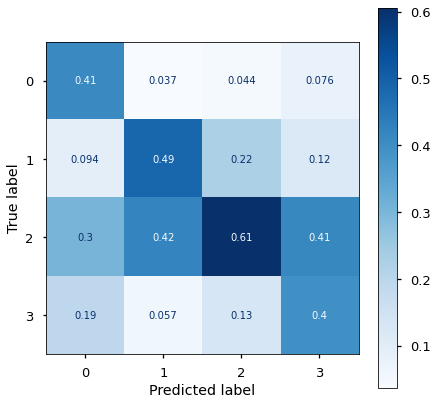

In [308]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, X_test_pivot, y_test_pivot, normalize='pred', cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 1)][:,-1].astype(np.float)
print(f"% in tomo bin {1} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_1 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 2)][:,-1].astype(np.float)
print(f"% in tomo bin {2} with bad redshift: {len(test_specz[test_specz == -99])/len(test_specz)}")
tst_2 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

#plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title(r"Test set, $z_{\rm pivot} = 1.2$")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

/tmp/ipykernel_28146/11483884.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_specz = X_sampled_pivot[indices_test_pivot][(y_pred_pivot == 1)][:,-1].astype(np.float)


% in tomo bin 1 with bad redshift: 0.05230335948501308


## dndz uncertainty

In [2]:
dndz_curves = np.zeros((1000, 16))
bad_percnt = np.zeros(1000)

In [3]:
count = 0
for h in range(10):
    #tmparr = np.load("/pscratch/sd/t/tanveerk/photo-z/" + str(h) + "_normed.npy", allow_pickle=True)
    tmparr = np.load("/global/cscratch1/sd/tanveerk/perlmutter_backup/photo-z/" + str(h) +
                     "_normed.npy", allow_pickle=True) #for cori
    for i in range(10):
        for j in range(10):
            idx = h * 100 + i * 10 + j                
            #print(idx)
            dndz_curves[idx] = tmparr[i][j][0]
            bad_percnt[idx] = tmparr[i][j][2]
            count += 1

### Distribution of percentage of ELGs without redshift

(array([ 4.,  7.,  7., 23., 36., 68., 74., 88., 97., 88., 80., 88., 76.,
        63., 52., 38., 33., 20., 17., 12., 12.,  4.,  7.,  2.,  4.]),
 array([0.12646742, 0.12964033, 0.13281323, 0.13598614, 0.13915904,
        0.14233195, 0.14550485, 0.14867776, 0.15185066, 0.15502357,
        0.15819647, 0.16136938, 0.16454228, 0.16771519, 0.17088809,
        0.174061  , 0.1772339 , 0.18040681, 0.18357972, 0.18675262,
        0.18992553, 0.19309843, 0.19627134, 0.19944424, 0.20261715,
        0.20579005]),
 <BarContainer object of 25 artists>)

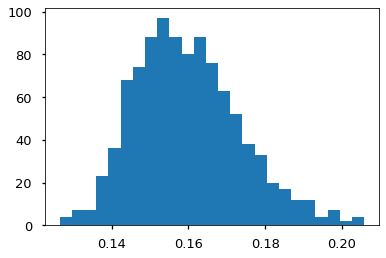

In [112]:
plt.hist(bad_percnt, bins = 25)

### Plot dndz curves and baseline curve

In [116]:
tst_2[1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5])

In [115]:
tmparr[0][0][1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6])

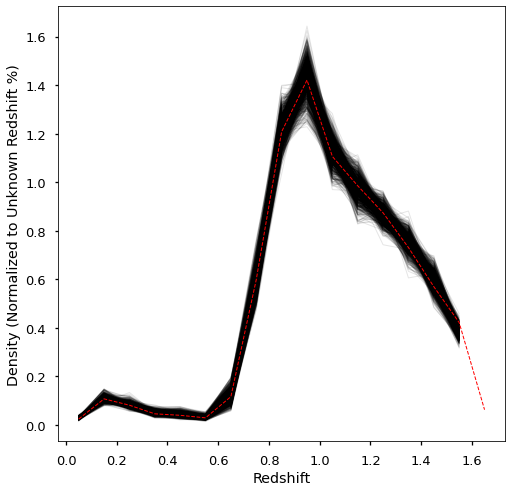

In [45]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot(tst_2[1][:-2] + np.diff(tst_2[1][:-1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Calculate photo-z covariance

In [46]:
cov = np.cov(dndz_curves.T)
err = np.std(dndz_curves.T, axis = 1, ddof = 1)
corr = cov/np.outer(err, err)

zranges = tst_2[1][:-1] + np.diff(tst_2[1])/2

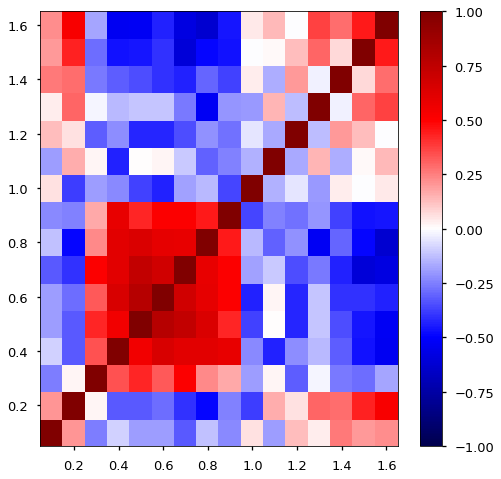

In [47]:
plt.figure(figsize=(8, 8))
plt.pcolor(zranges, zranges, corr, vmin = -1, vmax = +1, cmap = 'seismic')
plt.colorbar()

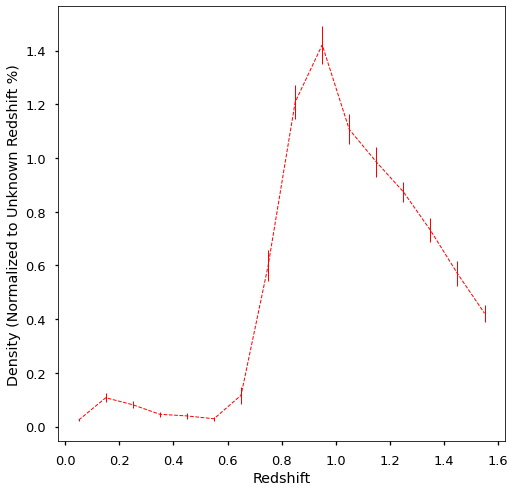

In [49]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.errorbar(tst_2[1][:-2] + np.diff(tst_2[1][:-1])/2, tst_2[0][:-1] * (1 - (test_specz == -99).sum()/len(test_specz)), yerr = err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density (Normalized to Unknown Redshift %)")
plt.show()

Signal-to-noise per redshift bin

In [162]:
yval = tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz))

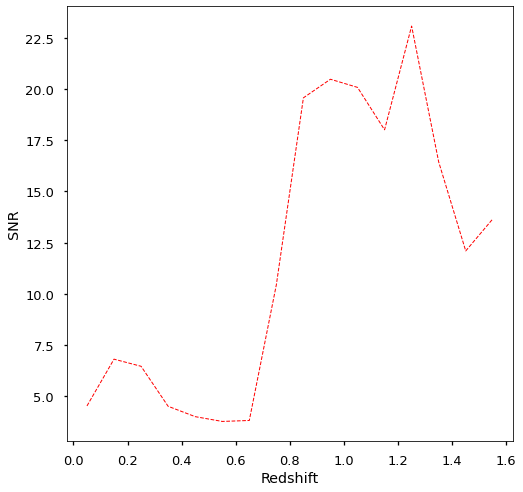

In [163]:
plt.figure(figsize=(8,8))
# for ii in range(1000):
#     plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, dndz_curves[ii] * (1 - bad_percnt[ii]), alpha = 0.1, c = 'k', lw = 1)
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, yval/err, alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("SNR")
plt.show()

#### Add exponential decay to curve

In [4]:
# define decay constant function 
decay_const = lambda P0, area : P0/area

# define exponential decay; zr is the rightmost bin defined in the actual hist
tail_pz = lambda P0, area, z, zr : P0*np.exp(-(P0/area)*(z - zr))

In [7]:
zrange_hist = tmparr[0][0][1][:-1] + np.diff(tmparr[0][0][1])/2 #actual histogram bin centers 
zextend_max = 3 #max redshift we will estimate out to 
zrange_extend = np.arange(zrange_hist[-1], zextend_max, 0.1) #maintain same binning width
zrange_comb = np.concatenate((zrange_hist, zrange_extend)) # full redshift bin center range 

def extended_pz(idx):
    m = bad_percnt[idx]
    r = np.random.default_rng(20220901).uniform(0, m)
    normed_curve = dndz_curves[idx] * (1 - r)
    
    tail_curve = tail_pz(normed_curve[-1], r, zrange_extend, zrange_hist[-1])
    pz_comb = np.concatenate((normed_curve, tail_curve))
    
    return pz_comb

In [8]:
dndz_curves_extended = np.zeros((len(dndz_curves), len(zrange_comb)))

for jj in range(len(dndz_curves)):
    dndz_curves_extended[jj] = extended_pz(jj)

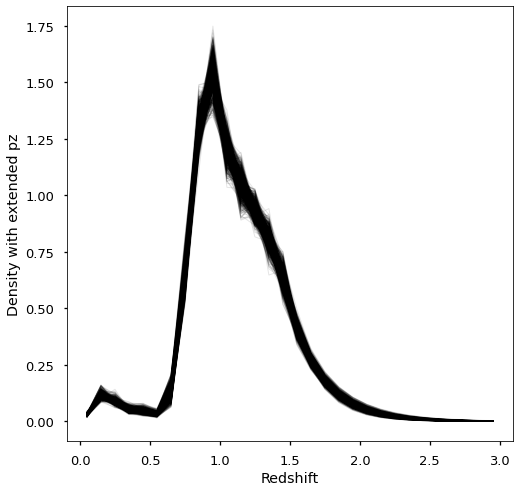

In [10]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot(zrange_comb, dndz_curves_extended[ii], alpha = 0.1, c = 'k', lw = 1)
#plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Redshift")
plt.ylabel("Density with extended pz")
plt.savefig("../plots/dndz_contour.pdf", bbox_inches = 'tight', dpi = 450)
plt.show()

In [25]:
# delete the same element appearing twice 
zrange_comb = np.delete(zrange_comb, 15, 0) #15th and 16th elements are the same
dndz_curves_extended = np.delete(dndz_curves_extended, 15, axis = 1)

In [27]:
#dict to save for use
dndz_final_dict = {}
dndz_final_dict['zrange'] = zrange_comb
dndz_final_dict['dndz'] = dndz_curves_extended

In [33]:
import pickle

# save dndz curves for usage
pickle.dump(dndz_final_dict, open("/global/cscratch1/sd/tanveerk/perlmutter_backup/photo-z/dndz_extended.p", "wb" ))

In [128]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

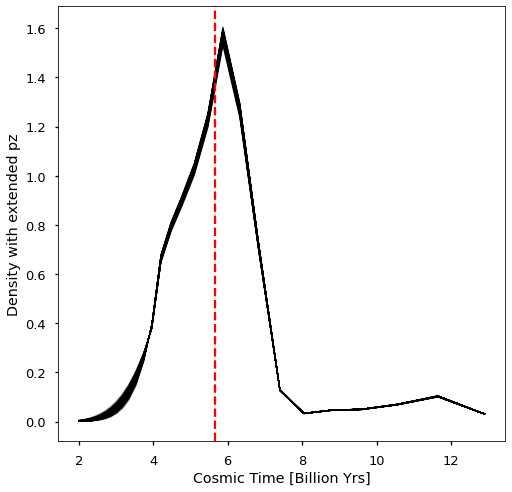

In [144]:
plt.figure(figsize=(8,8))
for ii in range(1000):
    plt.plot((13.6 - cosmo.lookback_time(zrange_comb).value), dndz_curves_extended[ii], 
             alpha = 0.1, c = 'k', lw = 1)
plt.axvline(13.6 - cosmo.lookback_time(1).value, ls = "--", c = 'r')
#plt.plot(tst_2[1][:-1] + np.diff(tst_2[1])/2, tst_2[0] * (1 - (test_specz == -99).sum()/len(test_specz)), alpha = 1, lw = 1, c = 'r', ls = '--')
plt.xlabel("Cosmic Time [Billion Yrs]")
plt.ylabel("Density with extended pz")
plt.show()

Check area under the curve

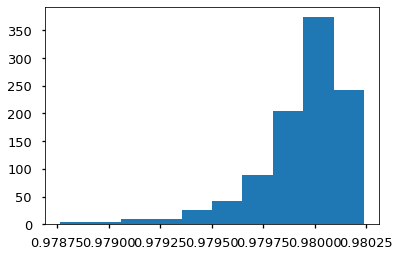

In [148]:
areas_all = np.trapz(dndz_curves_extended, zrange_comb, dx = 0.1)
plt.hist(areas_all, bins = 10);

In [104]:
zrange_extend = np.arange(zrange_hist[-1], 5, 0.1)
tail_curve_ii = tail_pz(normed_curve_ii[-1], r, zrange_extend, zrange_hist[-1])
np.trapz(tail_curve_ii, zrange_extend, dx = 0.1)

0.10313165319678917

In [100]:
pz_comb = np.concatenate((normed_curve_ii, tail_curve_ii))
zrange_comb = np.concatenate((zrange_hist, zrange_extend))

In [101]:
np.trapz(pz_comb, zrange_comb, dx = 0.1)

0.9781247784155741

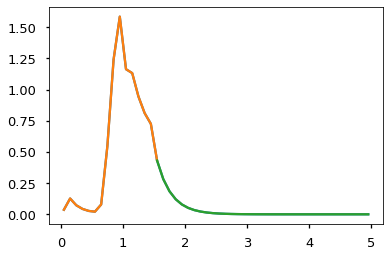

In [107]:
plt.plot(zrange_comb, pz_comb)
plt.plot(zrange_hist, normed_curve_ii)
plt.plot(zrange_extend, tail_curve_ii)

# Scratch

In [40]:
plt.figure(figsize=(10,7))
full_1 = plt.hist(X_sampled[:,5][y_pred_balanced == 1][X_sampled[:,5][y_pred_balanced == 1] != -99], 
         bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
full_2 = plt.hist(X_sampled[:,5][y_pred_balanced == 2][X_sampled[:,5][y_pred_balanced == 2] != -99], 
         bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");
plt.legend(loc = 'best')
plt.title("dndz - Full Sample Training")
#plt.yscale("log")

NameError: name 'y_pred_balanced' is not defined

<Figure size 720x504 with 0 Axes>

### New cut sample with 5 labels

In [86]:
cond = is_not_badz
cond_bad = is_badz

In [87]:
#build dataframe

#convert band magnitude to proper units
mag_dict = {}
mag_dict['g'] = np.concatenate((mag_good['G'][cond], mag_bad['G'][cond_bad])) #combine both ZWARN == 0 and != 0
mag_dict['r'] = np.concatenate((mag_good['R'][cond], mag_bad['R'][cond_bad]))
mag_dict['z'] = np.concatenate((mag_good['Z'][cond], mag_bad['Z'][cond_bad]))
mag_dict['gr'] = np.concatenate((mag_good['g-r'][cond], mag_bad['g-r'][cond_bad]))
mag_dict['rz'] = np.concatenate((mag_good['r-z'][cond], mag_bad['r-z'][cond_bad]))
mag_dict['specz'] = np.concatenate((np.array(zcat_elg['Z'][cond]), -99*np.ones_like(zcat_elg_bad_z['Z'][cond_bad])))
mag_dict['label'] = np.concatenate((bin_cat[cond], np.array(4 * np.ones_like(mag_bad['r-z'][cond_bad]))))

data_array = np.array([mag_dict['rz'], mag_dict['gr'], mag_dict['g'], mag_dict['r'], mag_dict['z'], mag_dict['specz'], mag_dict['label']])
df = pd.DataFrame(data_array.T, columns = ['r-z','g-r', 'g', 'r', 'z', 'specz', 'redz_bin'])

df = df.sample(frac=1)

print(df)

             r-z       g-r          g          r          z      specz  \
115809  0.579214  0.202723  23.233651  23.030927  22.451713   1.389076   
189870  0.812021  0.334983  22.891119  22.556136  21.744115   1.006445   
9042    0.576625  0.064036  23.471807  23.407772  22.831146   1.442411   
28175   0.756401  0.473868  23.463560  22.989692  22.233291   0.814617   
61054   0.678332  0.054240  23.001596  22.947356  22.269023   1.321111   
...          ...       ...        ...        ...        ...        ...   
215215  0.385875 -0.110110  23.387971  23.498082  23.112207 -99.000000   
188049  0.693718  0.328517  22.338502  22.009985  21.316268   0.812189   
112127  0.901074  0.114054  22.835503  22.721449  21.820375   1.357030   
118078  0.774656  0.051635  23.731915  23.680280  22.905624   0.917361   
77971   0.956576 -0.029884  23.230494  23.260378  22.303803   0.844087   

        redz_bin  
115809       2.0  
189870       1.0  
9042         2.0  
28175        1.0  
61054        2.0

In [89]:
df.groupby('redz_bin').count()/df.groupby('redz_bin').count()['r-z'].sum()

r-z       g-r         g         r         z     specz
redz_bin                                                            
0.0       0.030675  0.030675  0.030675  0.030675  0.030675  0.030675
1.0       0.518157  0.518157  0.518157  0.518157  0.518157  0.518157
2.0       0.329983  0.329983  0.329983  0.329983  0.329983  0.329983
3.0       0.012170  0.012170  0.012170  0.012170  0.012170  0.012170
4.0       0.109015  0.109015  0.109015  0.109015  0.109015  0.109015

#### Standardize

In [96]:
replace = True
#split into features and classes
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
#X, y = df.drop(["redz_bin", "g", "r", "z"], axis=1), df["redz_bin"].values.flatten()
X, y = df.drop(["redz_bin"], axis=1), df["redz_bin"].values.flatten()

per_cat_num =np.array([2700, 30000, 73500, 2700, 15000]) #number of objects to include per category

# Create balanced training / test data set using undersampled majority class records
X_sampled0, y_sampled0 = resample(X[y == 0], y[y == 0],
                replace=replace,
                n_samples=per_cat_num[0])

X_sampled1, y_sampled1 = resample(X[y == 1], y[y == 1],
                replace=replace,
                n_samples=per_cat_num[1])

X_sampled2, y_sampled2 = resample(X[y == 2], y[y == 2],
                replace=replace,
                n_samples=per_cat_num[2])

X_sampled3, y_sampled3 = resample(X[y == 3], y[y == 3],
                replace=replace,
                n_samples=per_cat_num[3])

X_sampled4, y_sampled4 = resample(X[y == 4], y[y == 4],
                replace=replace,
                n_samples=per_cat_num[4])

#combine
X_sampled = np.vstack((X_sampled0, X_sampled1, X_sampled2, X_sampled3, X_sampled4))
y_balanced = np.hstack((y_sampled0, y_sampled1, y_sampled2, y_sampled3, y_sampled4))

#scale features
sc = StandardScaler()
X_balanced = sc.fit_transform(X_sampled[:, [0, 1, 2, 3, 4]]) #drop the specz column for training, but keep it in X_sampled for plotting dndz

# Create train/test sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_balanced, y_balanced,
                                                                                 np.arange(0, len(X_balanced)), 
                                                                                 test_size=0.20, 
                                                                                 stratify=None)

In [97]:
for i in range(len(per_cat_num)):
    print(f"Baseline performance: for label {i} is {per_cat_num[i]/per_cat_num.sum()}")

Baseline performance: for label 0 is 0.021791767554479417
Baseline performance: for label 1 is 0.24213075060532688
Baseline performance: for label 2 is 0.5932203389830508
Baseline performance: for label 3 is 0.021791767554479417
Baseline performance: for label 4 is 0.12106537530266344


In [325]:
(per_cat_num[1] + per_cat_num[2])/per_cat_num.sum()

0.8353510895883777

In [327]:
.73 - (per_cat_num[2])/per_cat_num.sum()

0.13677966101694916

In [98]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [99]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Feature importance:",clf.feature_importances_)

Accuracy: 0.7176755447941888
Feature importance: [0.20142446 0.2172878  0.18441842 0.18403246 0.21283685]


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


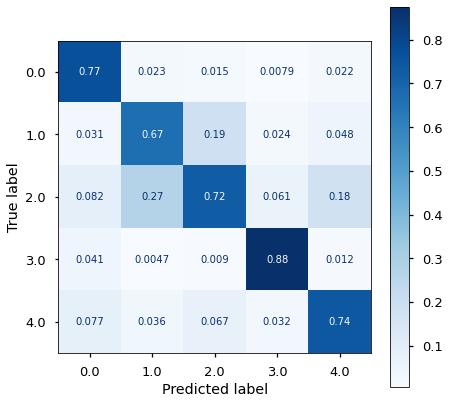

In [100]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, X_test, y_test, normalize='pred', cmap=plt.cm.Blues, ax=ax)
plt.show()

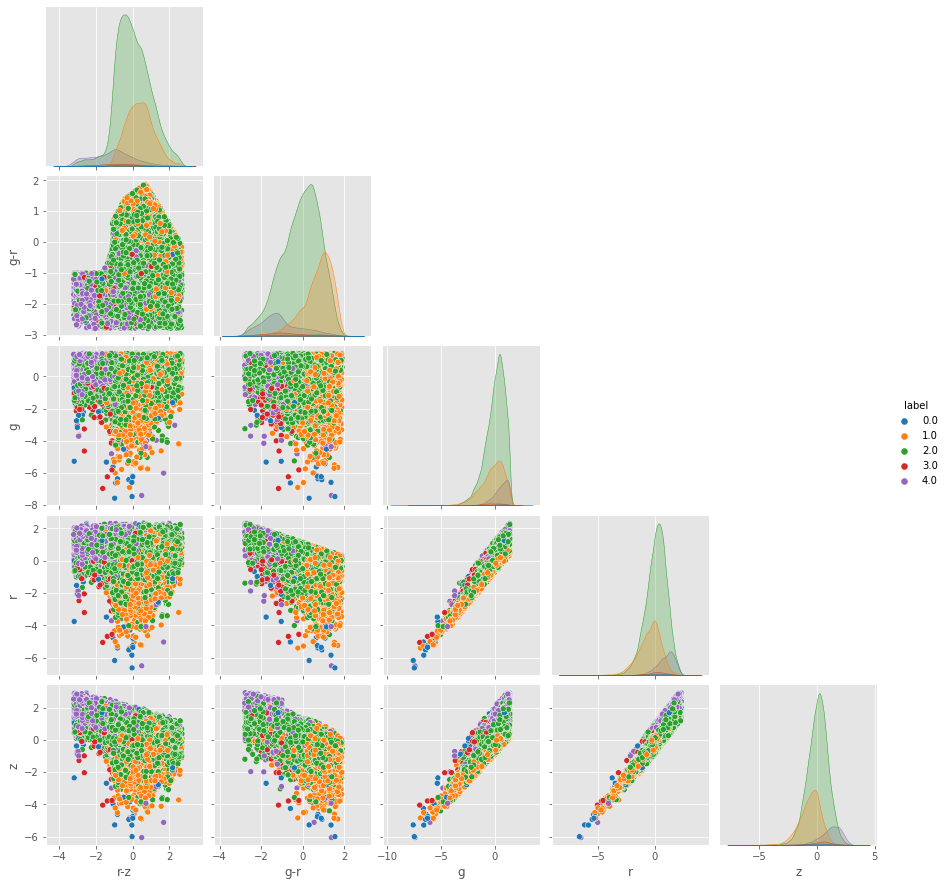

In [170]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.hstack((X_test, y_pred.reshape(-1,1))), columns=['r-z', 'g-r',
                                          'g','r','z', 'label']), hue = 'label', palette="tab10",
            corner = True)

#### How do each of the predicted labels' locus compare to the real locus?

In [324]:
%time y_pred_balanced = clf.predict(X_balanced)

CPU times: user 6.34 s, sys: 11.9 ms, total: 6.35 s
Wall time: 6.35 s


/tmp/ipykernel_44259/201039174.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
/tmp/ipykernel_44259/201039174.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


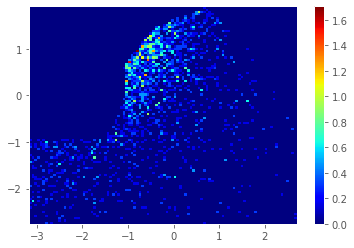

In [336]:
tmptmp = (y_pred_balanced == 0)
tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
                 density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
plt.colorbar()

/tmp/ipykernel_44259/3723769727.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmpb = plt.hist2d(mag_good['r-z'][lowz_bad_bin & cond], mag_good['g-r'][lowz_bad_bin & cond],
/tmp/ipykernel_44259/3723769727.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


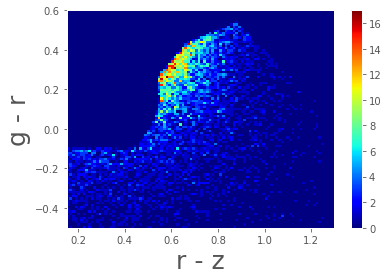

In [337]:
# plt.hist2d(mag_bad['r-z'], mag_bad['g-r'], 
#           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]], 
#           vmax = 180);
tmpb = plt.hist2d(mag_good['r-z'][lowz_bad_bin & cond], mag_good['g-r'][lowz_bad_bin & cond], 
           bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_1_bin & cond], mag_good['g-r'][tomo_1_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][tomo_2_bin & cond], mag_good['g-r'][tomo_2_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_good['r-z'][highz_bad_bin & cond], mag_good['g-r'][highz_bad_bin & cond], 
#            bins = 100, cmap = plt.cm.jet, range = [[.15, 1.3], [-0.5, .6]]);
# tmpb = plt.hist2d(mag_bad['r-z'][cond_bad], mag_bad['g-r'][cond_bad], 
#            bins = 100, cmap = plt.cm.jet, range = [[mag_good['r-z'][cond].min(), mag_good['r-z'][cond].max()], 
#                                                    [mag_good['g-r'][cond].min(), mag_good['g-r'][cond].max()]],
#                   density = True);
# plt.plot(np.arange(4/9, 2/3, 0.01), np.arange(4/9, 2/3, 0.01) * 1.4 - 0.5, lw = 4.5, c = 'magenta')
# plt.plot(tmpx, tmpy, c = 'magenta', lw = 4.5)
# plt.plot(tmpxx, tmpyy, c = 'magenta', lw = 4.5)
#plt.title("ZWARN != 0")
plt.xlabel("r - z", fontsize = 25)
plt.ylabel("g - r", fontsize = 25)
plt.colorbar()
plt.show()

#### Where do labels predicted as not 4 but actually are 4 reside on the colour-colour space?

/tmp/ipykernel_44259/2253695475.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
/tmp/ipykernel_44259/2253695475.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 1.0, '(0, 2)')

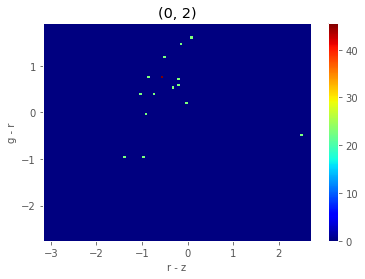

In [339]:
tupp = (0,2)
tmptmp = (y_pred_balanced == tupp[0]) & (y_balanced == tupp[1])
tmpa = plt.hist2d(X_balanced[:,0][tmptmp], X_balanced[:,1][tmptmp], bins = 100,  cmap = plt.cm.jet,
                 density = True, range = [[X_balanced[:,0].min(), X_balanced[:,0].max()], [X_balanced[:,1].min(), X_balanced[:,1].max()]]);
plt.colorbar()
plt.xlabel("r - z", fontsize = 10)
plt.ylabel("g - r", fontsize = 10)
plt.title(f"({tupp[0]}, {tupp[1]})")

#### Tomographic dndz based on classifier
We plot the redshift distributions of the two tomographic bins based on this classifier

In [105]:
len(zrange)

40

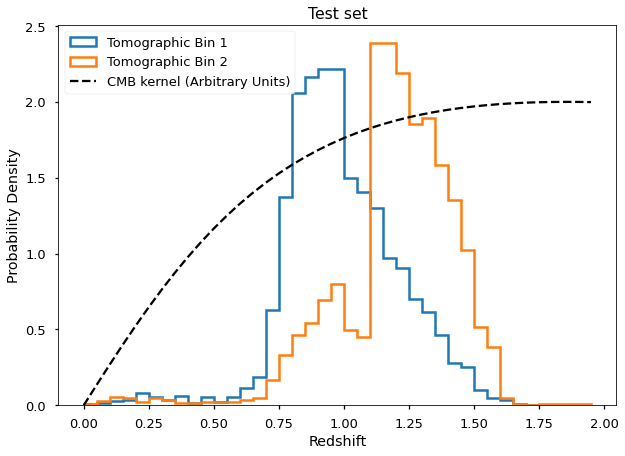

In [101]:
plt.figure(figsize=(10,7))
# tst_1 = plt.hist(X_sampled[indices_test][(y_test == 1)][X_sampled[indices_test][(y_test == 1)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
# tst_2 = plt.hist(X_sampled[indices_test][(y_test == 2)][X_sampled[indices_test][(y_test == 2)] != -99], 
# bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

zrange = np.arange(0, 2, 0.05)

test_specz = X_sampled[indices_test][(y_pred == 1)][:,-1]
tst_11 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");

test_specz = X_sampled[indices_test][(y_pred == 2)][:,-1]
tst_12 = plt.hist(test_specz[test_specz != -99], 
bins = zrange, density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");

plt.plot(zrange, cmb_kernel(zrange)/cmb_kernel(zrange).max() * 2, label = 'CMB kernel (Arbitrary Units)', ls = '--', c = 'k')
#plt.yscale("log")
plt.legend(loc = 'upper left')
plt.title("Test set")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.show()

Text(0.5, 1.0, 'dndz - New Colour Cut')

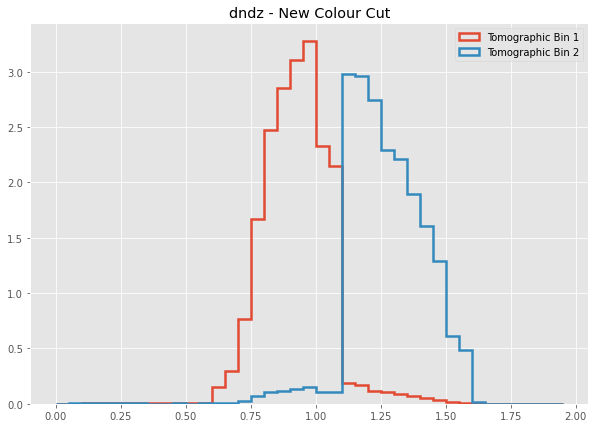

In [340]:
plt.figure(figsize=(10,7))
new_1 = plt.hist(X_sampled[:,5][y_pred_balanced == 1][X_sampled[:,5][y_pred_balanced == 1] != -99], 
     bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 1");
new_2 = plt.hist(X_sampled[:,5][y_pred_balanced == 2][X_sampled[:,5][y_pred_balanced == 2] != -99], 
         bins = np.arange(0, 2, .05), density = True, histtype = 'step', lw = 2.5, label = "Tomographic Bin 2");
plt.legend(loc = 'best')
plt.title("dndz - New Colour Cut")
#plt.yscale("log")

### Compare the two classifiers

In [346]:
new_1[1][:-1] + np.diff(new_1[1])

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])

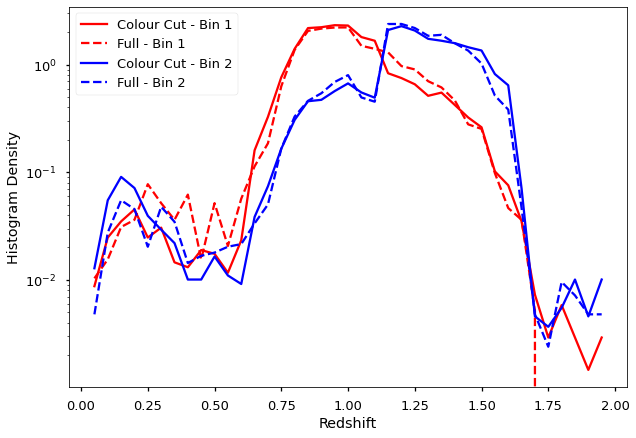

In [104]:
plt.figure(figsize=(10,7))
plt.plot(tst_1[1][:-1] + np.diff(tst_1[1]), tst_1[0], label = "Colour Cut - Bin 1", c = 'r')
plt.plot(tst_11[1][:-1] + np.diff(tst_11[1]), tst_11[0], label = "Full - Bin 1", c = 'r', ls = '--')
plt.plot(tst_2[1][:-1] + np.diff(tst_2[1]), tst_2[0], label = "Colour Cut - Bin 2", c = 'b')
plt.plot(tst_12[1][:-1] + np.diff(tst_12[1]), tst_12[0], label = "Full - Bin 2", c = 'b', ls = '--')
plt.legend(loc = 'best')
plt.xlabel("Redshift")
plt.ylabel("Histogram Density")
plt.yscale("log")

Text(0, 0.5, 'Histogram Density')

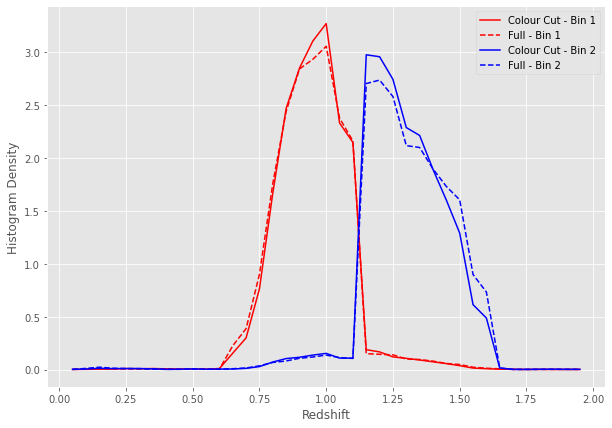

In [355]:
plt.figure(figsize=(10,7))
plt.plot(new_1[1][:-1] + np.diff(new_1[1]), new_1[0], label = "Colour Cut - Bin 1", c = 'r')
plt.plot(full_1[1][:-1] + np.diff(full_1[1]), full_1[0], label = "Full - Bin 1", c = 'r', ls = '--')
plt.plot(new_2[1][:-1] + np.diff(new_2[1]), new_2[0], label = "Colour Cut - Bin 2", c = 'b')
plt.plot(full_2[1][:-1] + np.diff(full_2[1]), full_2[0], label = "Full - Bin 2", c = 'b', ls = '--')
plt.legend(loc = 'best')
plt.xlabel("Redshift")
plt.ylabel("Histogram Density")
#plt.yscale("log")

In [103]:
#do ks test
from scipy.stats import ks_2samp

print(ks_2samp(tst_1[0], tst_11[0]))
print(ks_2samp(tst_2[0], tst_12[0]))

KstestResult(statistic=0.1794871794871795, pvalue=0.562189184580869)
KstestResult(statistic=0.10256410256410256, pvalue=0.9884530799873196)


# SCRATCH

TypeError: Input z must be 2D, not 5D

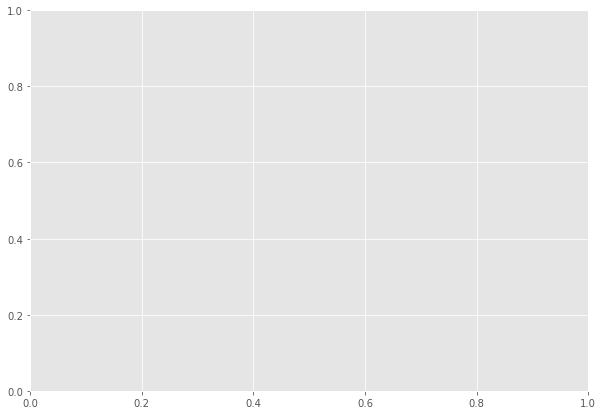

In [335]:
# define bounds of the domain
min1, max1 = X['r-z'].min()-.01, X['r-z'].max()+.01
min2, max2 = X['g-r'].min()-.01, X['g-r'].max()+.01
min3, max3 = X['g'].min()-.01, X['g'].max()+.01
min4, max4 = X['r'].min()-.01, X['r'].max()+.01
min5, max5 = X['z'].min()-.01, X['z'].max()+.01


# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
x3grid = np.arange(min3, max3, 0.1)
x4grid = np.arange(min4, max4, 0.1)
x5grid = np.arange(min5, max5, 0.1)

# create all of the lines and rows of the grid
xx, yy, zz, ww, vv = np.meshgrid(x1grid, x2grid, x3grid, x4grid, x5grid)

# flatten each grid to a vector
r1, r2, r3, r4, r5 = xx.flatten(), yy.flatten(), zz.flatten(), ww.flatten(), vv.flatten()
r1, r2, r3, r4, r5 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1)), r3.reshape((len(r3), 1)), r4.reshape((len(r4), 1)), r5.reshape((len(r5), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2,r3,r4,r5))

# make predictions for the grid
yhat = clf.predict(grid)

# reshape the predictions back into a grid
pp = yhat.reshape(xx.shape)

plt.figure(figsize = (10, 7))
#plt.hist2d(rz[tomo_1_bin], gr[tomo_1_bin], 
#           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]]);
plt.contourf(xx, yy, pp, cmap=cmap, alpha = 0.5)
plt.title("1. < z <= 1.6")
plt.colorbar()
#fdr_plot()

# To Do:
- Analysis for a binary classifier: Look at objects z < 0.9 and z > 1.2 and see if things are working
- Give equal weight to each classification label: CHECK
- Run Naive Bayes, SVM and Random Forest
- If necessary, apply penalty for false positive for the higher tomographic bin

In [31]:
#only focus on region of interest in the colour-colour space
cond = (rz > 0) & (rz < 1.6) & (gr > -0.5) & (gr < 1)

#convert band magnitude to proper units
mag_dict = {}
mag_dict['g'] = -2.5*np.log10(zcat_elg['FLUX_G']/mw_transmission_dict['G'])
mag_dict['r'] = -2.5*np.log10(zcat_elg['FLUX_R']/mw_transmission_dict['R'])
mag_dict['z'] = -2.5*np.log10(zcat_elg['FLUX_Z']/mw_transmission_dict['Z'])

data_array = np.array([np.array(rz[cond]), np.array(gr[cond]), 
                       np.array(mag_dict['g'][cond]), np.array(mag_dict['r'][cond]), 
                       np.array(mag_dict['z'][cond]), bin_cat[cond]])
df = pd.DataFrame(data_array.T, columns = ['r-z','g-r', 'g', 'r', 'z', 'redz_bin'])

print(df)

             r-z       g-r         g         r         z  redz_bin
0       0.902352  0.008119  0.923826  0.915707  0.013355       2.0
1       0.864276  0.184933  1.152333  0.967400  0.103124       3.0
2       0.374512  0.067998 -0.810391 -0.878388 -1.252901       3.0
3       0.921050  0.368202  0.721866  0.353664 -0.567386       1.0
4       0.187927 -0.404271  0.349999  0.754271  0.566344       0.0
...          ...       ...       ...       ...       ...       ...
277276  0.696811  0.220693  1.044476  0.823783  0.126972       2.0
277277  0.769078  0.460179  0.740266  0.280087 -0.488991       2.0
277278  0.777026  0.445583  0.316184 -0.129399 -0.906425       1.0
277279  0.728116 -0.011707  1.271704  1.283411  0.555295       2.0
277280  0.707025  0.388287  1.315167  0.926880  0.219854       0.0

[277281 rows x 6 columns]


### Standardize features and split

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Build feature/target arrays
X, y = df.drop(["redz_bin", 'g', 'r', 'z'], axis=1), df["redz_bin"].values.flatten()

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1121218, test_size=0.20, stratify=y
)

#scale features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
from sklearn.naive_bayes import GaussianNB
#train NB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

from sklearn.metrics import accuracy_score
print(f'Accuracy is: {accuracy_score(y_pred, y_test)}')

Number of mislabeled points out of a total 55457 points : 24630
Accuracy is: 0.5558721171357989


#### Draw decision boundary

In [34]:
# define bounds of the domain
min1, max1 = X['r-z'].min()-.01, X['r-z'].max()+.01
min2, max2 = X['g-r'].min()-.01, X['g-r'].max()+.01

# define the x and y scale
x1grid = np.arange(min1, max1, 0.01)
x2grid = np.arange(min2, max2, 0.01)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = gnb.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

/tmp/ipykernel_32271/3293694938.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


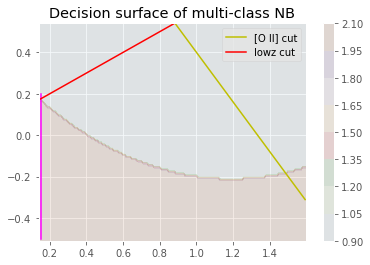

In [36]:
colors = "bryg"
plt.contourf(xx, yy, zz, cmap=plt.cm.Paired, alpha = 0.1)
plt.axis("tight")
plt.colorbar()
X = np.array(X)
#Plot also the training points
# for i, color in zip(gnb.classes_, colors):
#     #idx = np.where(y == i)
#     idx = (y == i)
#     plt.scatter(
#         X[idx, 0],
#         X[idx, 1],
#         c=color,
#         label=gnb.classes_[np.int(i)],
#         cmap=plt.cm.Paired,
#         edgecolor="black",
#         s=20,
#     )
    
plt.title("Decision surface of multi-class NB")
plt.axis("tight")

# Plot the three one-against-all classifiers
plt.legend()
#plt.xlim([-0., 2.])
#plt.ylim([-.5, 1])
fdr_plot()

##### Overlay on tomographic bin 2

/tmp/ipykernel_32271/320403798.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(rz[tomo_2_bin], gr[tomo_2_bin],
/tmp/ipykernel_32271/320403798.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


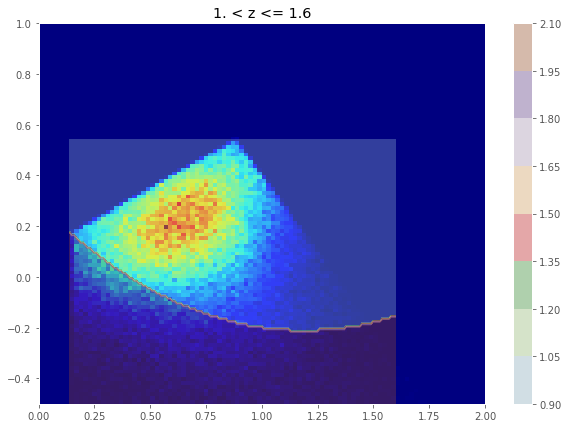

In [39]:
plt.figure(figsize = (10, 7))
plt.hist2d(rz[tomo_2_bin], gr[tomo_2_bin], 
           bins = 100, cmap = plt.cm.jet, range = [[0, 2], [-0.5, 1]]);
plt.contourf(xx, yy, zz, cmap=plt.cm.Paired, alpha = 0.3)
plt.title("1. < z <= 1.6")
plt.colorbar()
#fdr_plot()

In [122]:
# plot the grid of x, y and z values as a surface
# plt.contourf(xx, yy, zz, cmap=plt.cm.Paired)
# for class_value in range(4):
#     # get row indexes for samples with this class
#     row_ix = (y == class_value)
#     # create scatter of these samples
#     plt.scatter(df['r-z'][row_ix], df['g-r'][row_ix], cmap='Dark2', alpha = 0.3)
# #plt.xlim([-0., 2.])
# #plt.ylim([-.5, 1])
# plt.colorbar()

In [83]:
from sklearn.datasets import load_iris

In [84]:
iris = load_iris()

In [ ]:
b